# Import Statements

In [4]:
#!pip3 install --user shapely
import numpy as np
import struct
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
import math
from scipy.signal import find_peaks,peak_widths
from scipy.interpolate import interp1d
import shapely
import json


# Loading Sysmat file

In [3]:


with open('../SysMatConfig/Parameters.json') as json_file:
    parameters = json.load(json_file)

# Matrix dimension 90*90*32*6*8
NImgX_ = parameters["numImageX"]
NImgY_ = parameters["numImageY"]
NDetY_ = parameters["pixelSiPM"]
NModule_ = parameters["numPanel"]
NDetX_ = parameters["numDetectorLayer"]

sysmatPath = parameters["sysmatPath"]
inFname = 'sysmatMatrix.sysmat'
fname = sysmatPath+inFname

#fname = 'sysmat_24layer_Rot_0_of_2_2mmslitin10mm_1010_idxT0_numT1in1mm_IZ0_DZ0_100.sysmat'
f=open(fname, 'rb')

dataSize=NImgX_*NImgY_*NDetY_*NModule_*NDetX_
dataUnpack=np.asarray(struct.unpack('f'*dataSize, f.read(dataSize*4)))
dataImage=dataUnpack.reshape((NDetX_, NModule_, NDetY_, NImgX_, NImgY_))


NameError: name 'json' is not defined

In [3]:
aperture_width = 3.0
aperture_pitch = 5.0
plate_thick = 2.0
N_slits=math.floor((107.52-aperture_width)/aperture_pitch)+1
print(f"No of slits: {N_slits}")
      
apt_y_0=(107.520-int(N_slits-1)*aperture_pitch)*0.5
aperture_y = np.arange(apt_y_0,107.52,aperture_pitch)
detector_y = np.arange(1.68,107.52,3.36)
aperture_x = np.ones(aperture_y.size)*plate_thick*0.5
detector_x = np.linspace(np.zeros(detector_y.size),np.ones(detector_y.size)*7,8,axis=0)*3.36+(1.68+plate_thick)
detector_x = detector_x + 190
aperture_x = aperture_x + 190
aperture_y = aperture_y + 36.24
detector_y = detector_y + 36.24

No of slits: 21


In [4]:
import matplotlib.cm
my_cmap = matplotlib.cm.get_cmap('turbo')

# Detector Location

In [5]:
dIdxY=16
dIdxX=2

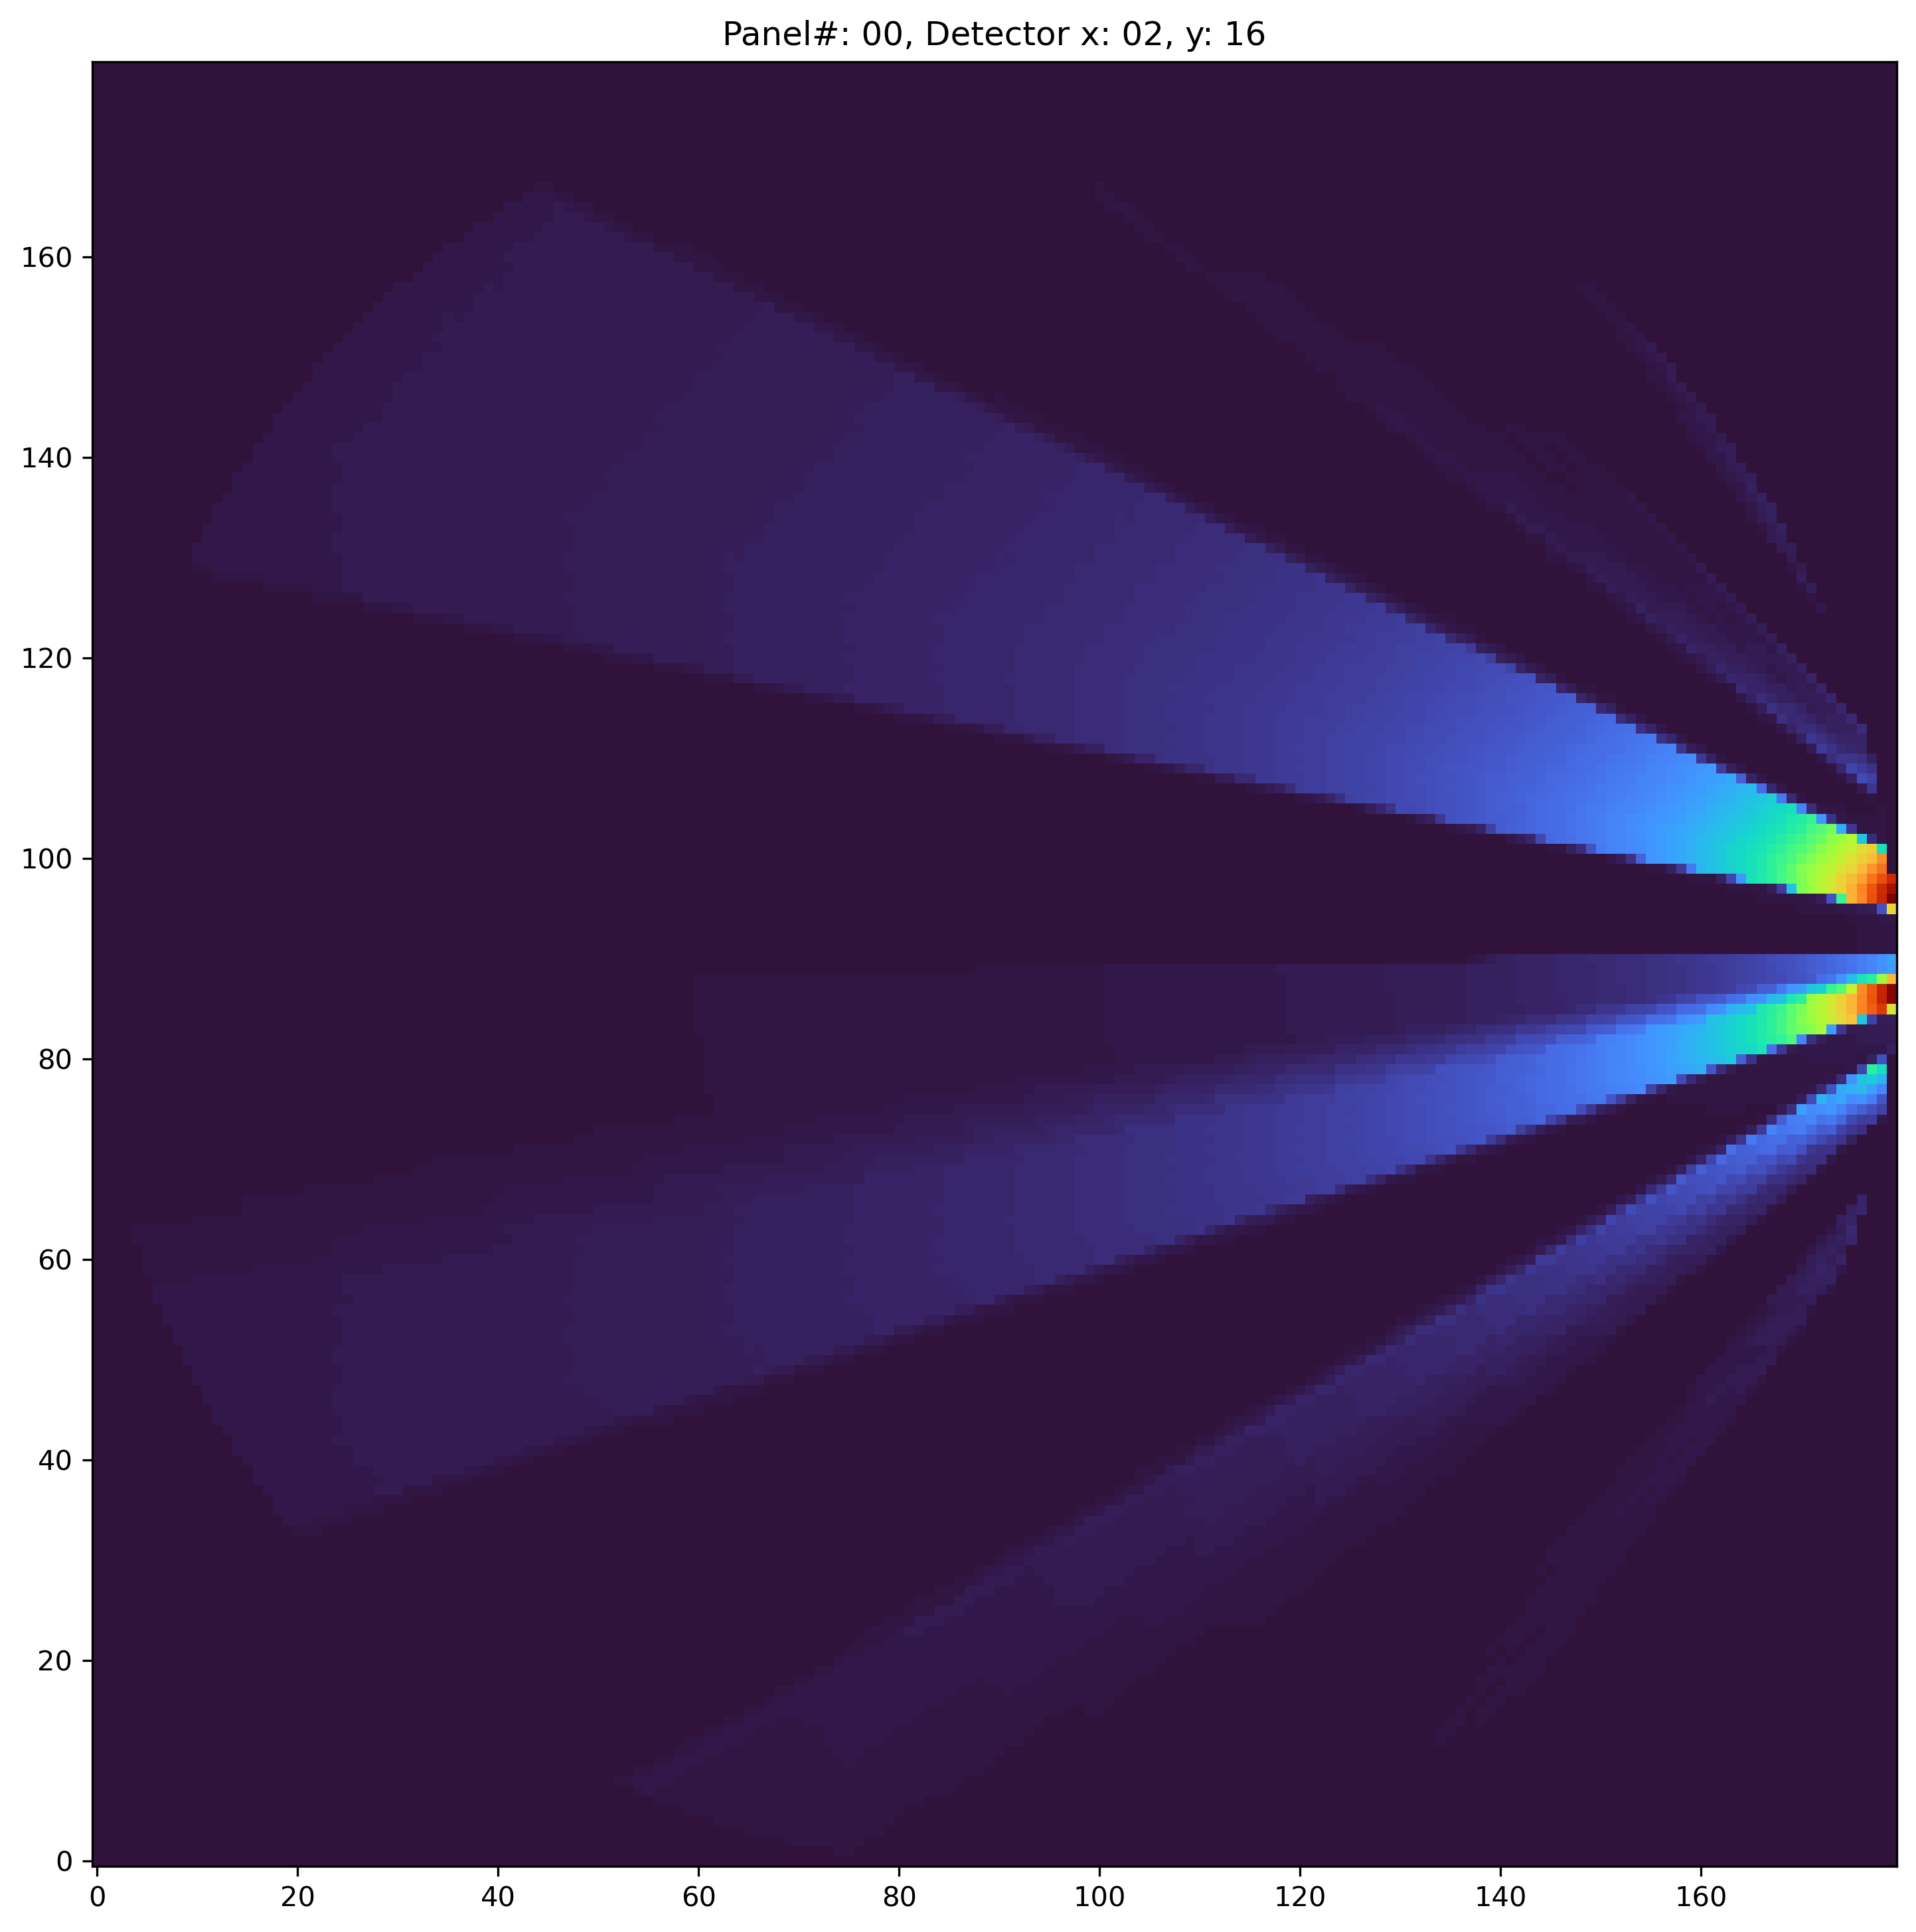

In [6]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots()
ax.add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax.add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax.add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1
pltTitle=ax.set_title('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
imshow_obj=ax.imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')

# Plot the setup

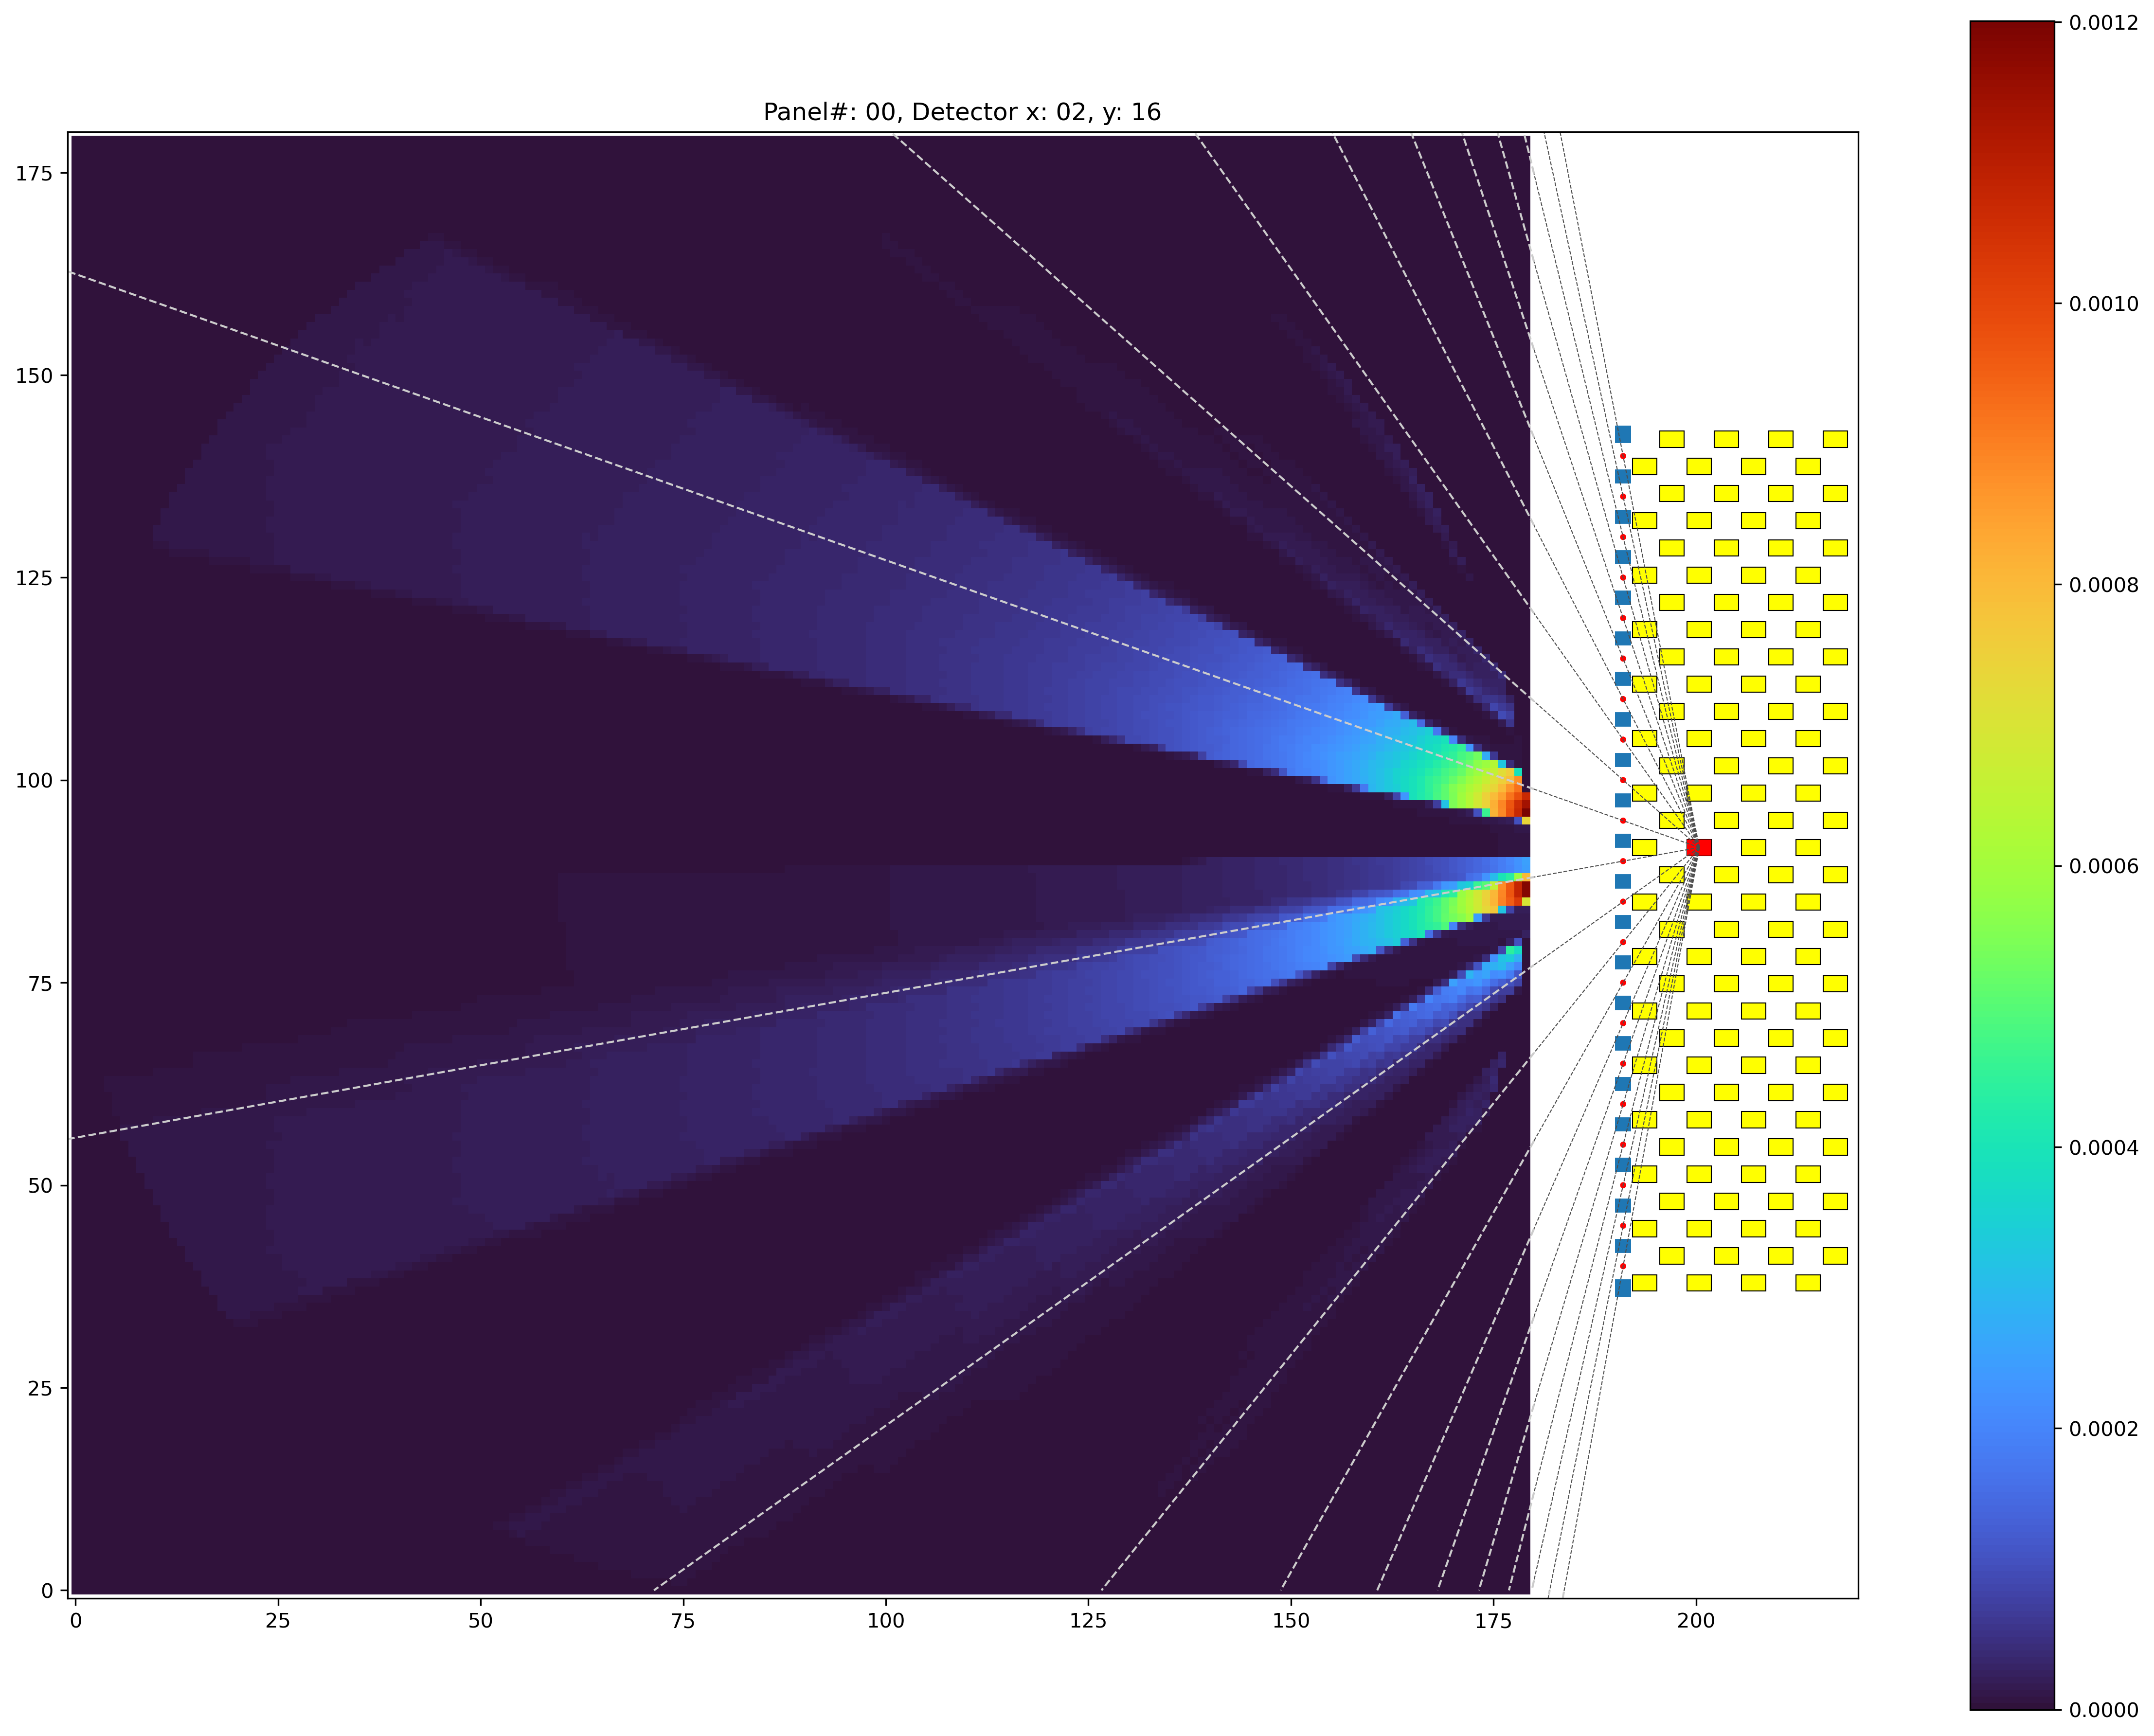

In [7]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots()
ax.add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax.add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax.add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1

pltTitle=ax.set_title('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
imshow_obj=ax.imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')
# imshow_obj=ax.imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=mpl.colormaps['turbo'],origin='lower')

for i in range (0,21):
    centerline_k = (detector_y[dIdxY]-aperture_y[i])/(detector_x[dIdxX,dIdxY]-aperture_x[i])
    centerline_b = aperture_y[i] - centerline_k*aperture_x[i]
    x1=[detector_x[dIdxX,dIdxY]]
    y1=[detector_y[dIdxY]]
    x1.append(180)
    y1.append(180*centerline_k+centerline_b)
    x2 = [180]
    y2 = [180*centerline_k+centerline_b]
    if centerline_k > 0 :
        y2.append(0)
        x2.append((0-centerline_b)/centerline_k)
    else:
        y2.append(180)
        x2.append((180-centerline_b)/centerline_k)
    ax.plot(x1,y1,linestyle='--',linewidth=0.5,color='0.3')
    ax.plot(x2,y2,linestyle='--',linewidth=1,color='0.8')
ax.set_ylim(-1,180)
ax.set_xlim(-1,220)
ax.add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
cbar=plt.colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
fig.tight_layout()
plt.savefig("test_{:d}_{:d}.png".format(dIdxX,dIdxY))

In [8]:
for ele in np.column_stack((aperture_x, aperture_y)):
    print(ele[0]-plate_thick*0.5,ele[1]-aperture_width*0.5)

190.0 38.5
190.0 43.5
190.0 48.5
190.0 53.5
190.0 58.5
190.0 63.5
190.0 68.5
190.0 73.5
190.0 78.5
190.0 83.5
190.0 88.5
190.0 93.5
190.0 98.5
190.0 103.5
190.0 108.5
190.0 113.5
190.0 118.5
190.0 123.5
190.0 128.5
190.0 133.5
190.0 138.5


Radius:  111.4322323208146


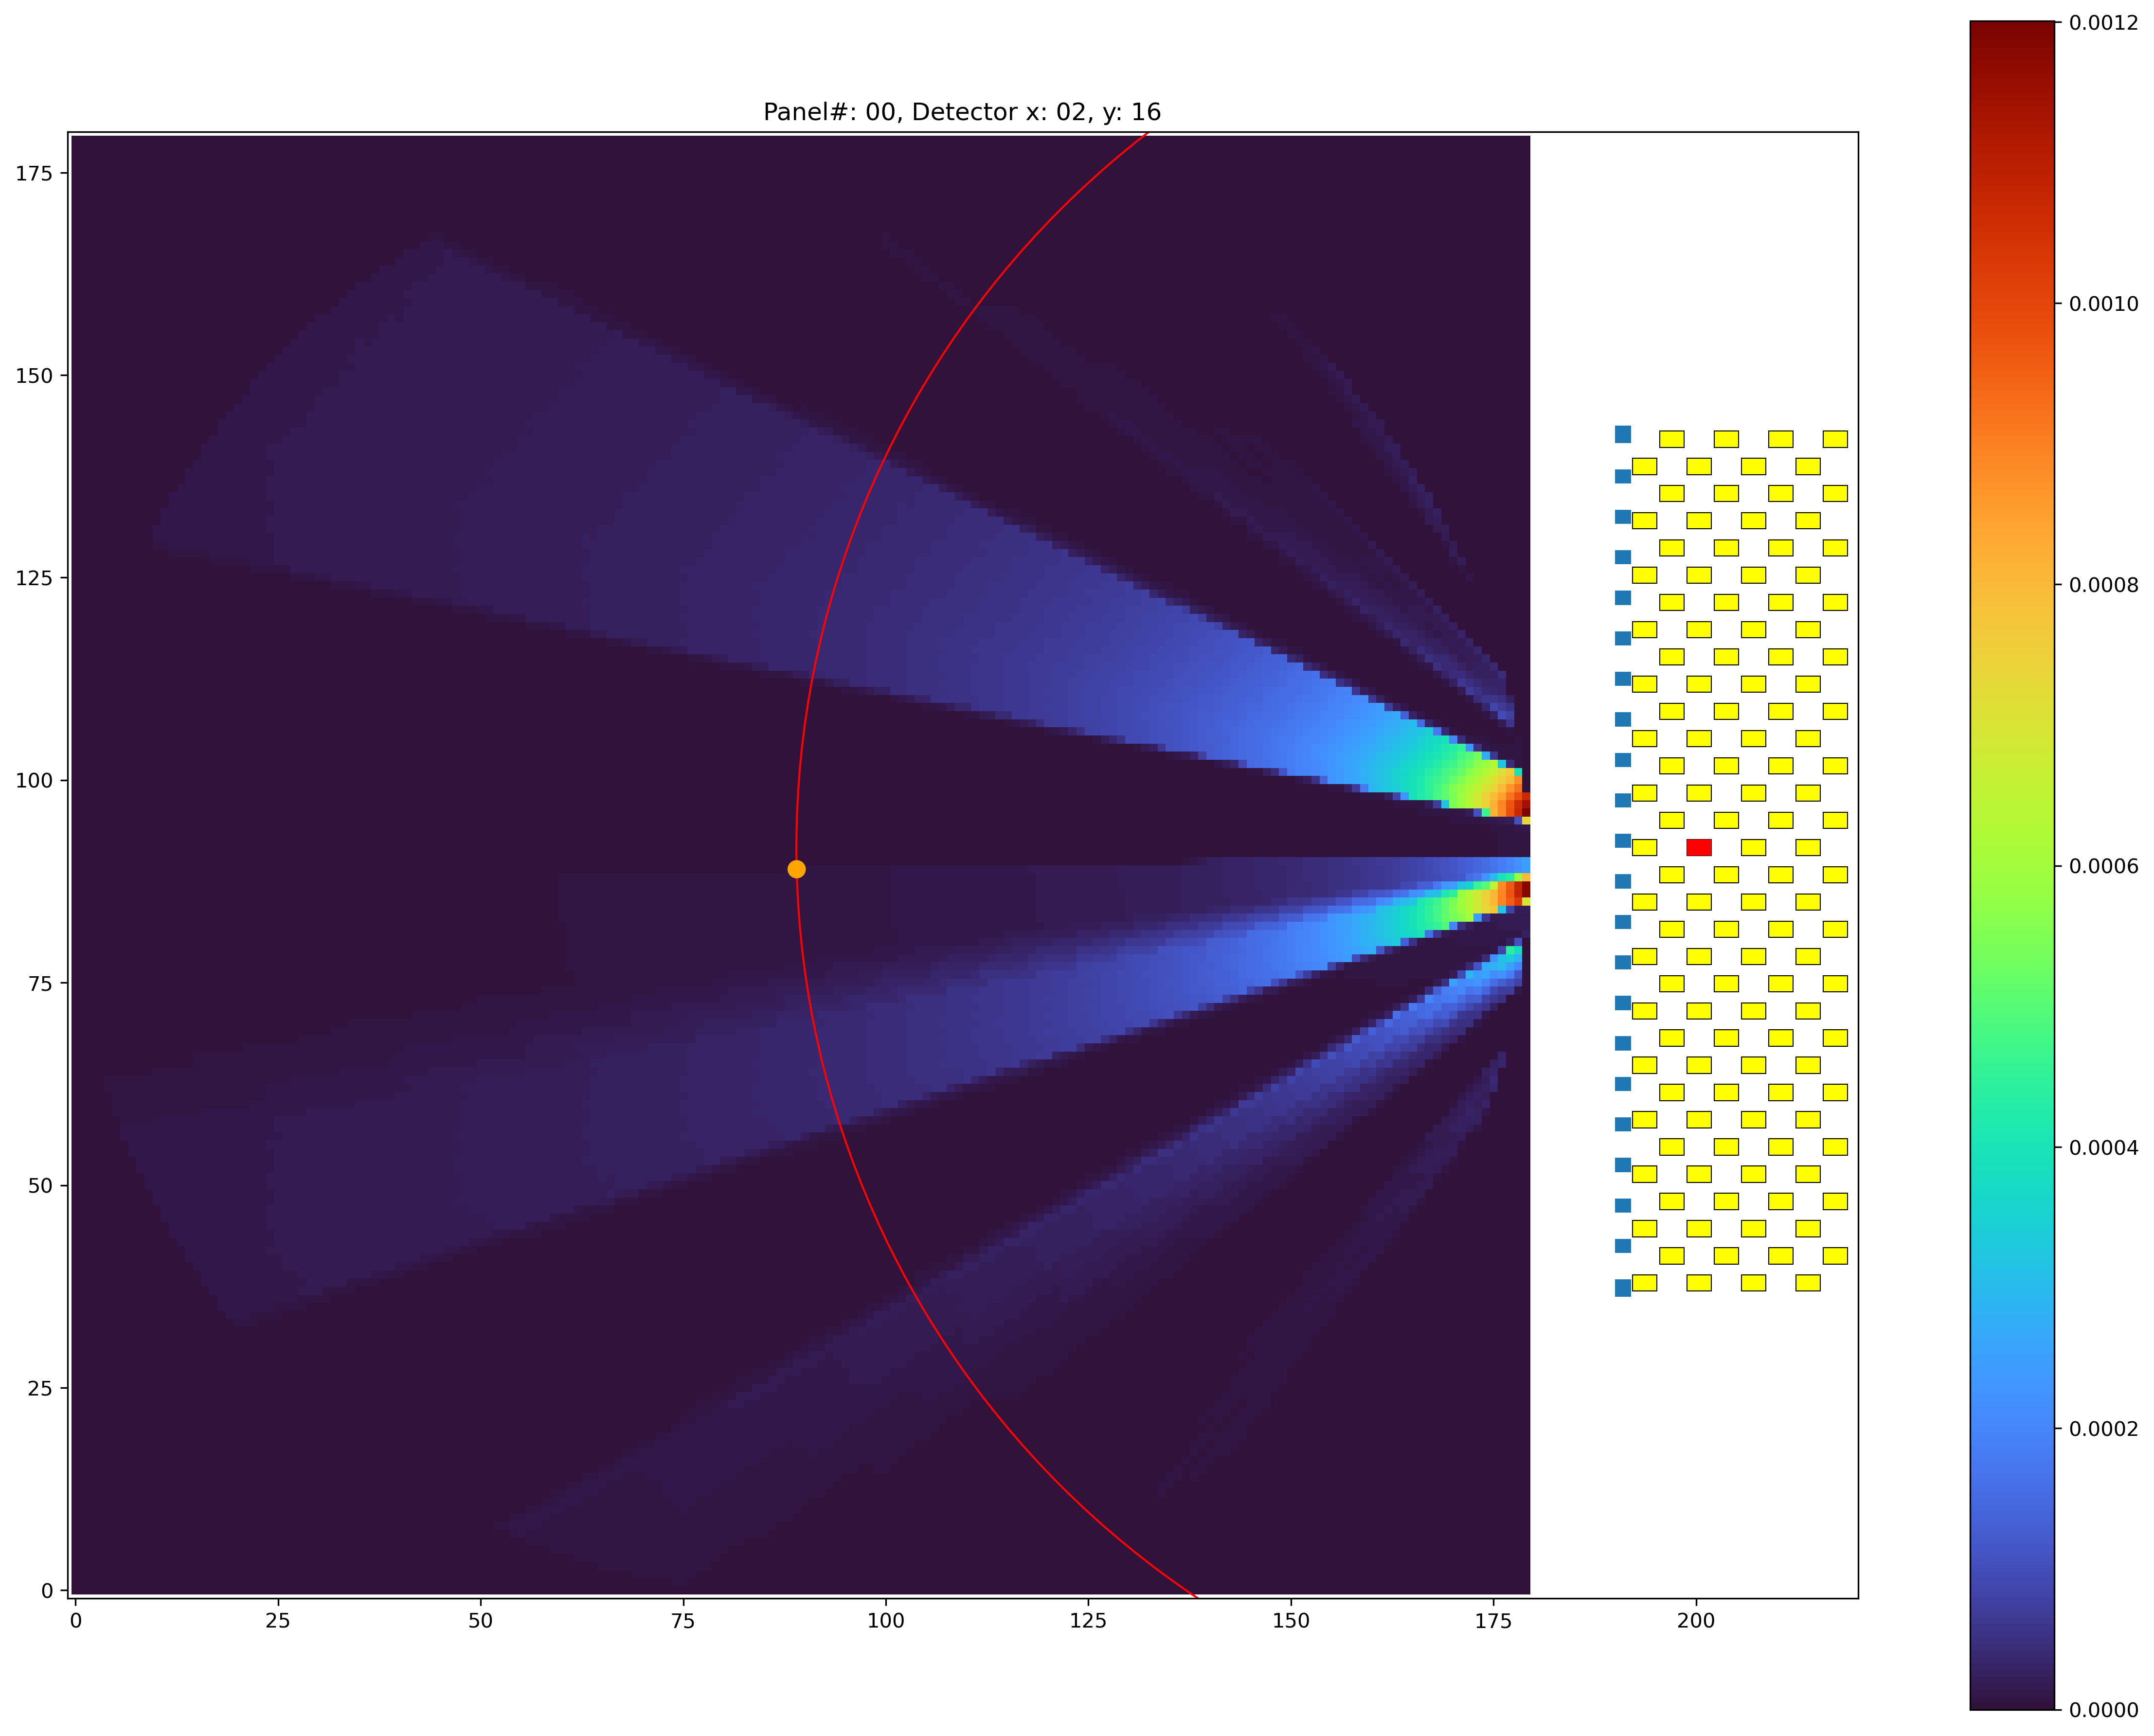

In [9]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots()
ax.add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax.add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    # ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax.add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1

pltTitle=ax.set_title('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
imshow_obj=ax.imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')
ax.set_ylim(-1,180)
ax.set_xlim(-1,220)
ax.add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
print("Radius: ",radius_det)
ax.add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False))
ax.add_patch(patches.Circle((89,89),radius = 1,color='orange'))
cbar=plt.colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
fig.tight_layout()


        

Radius:  111.4322323208146


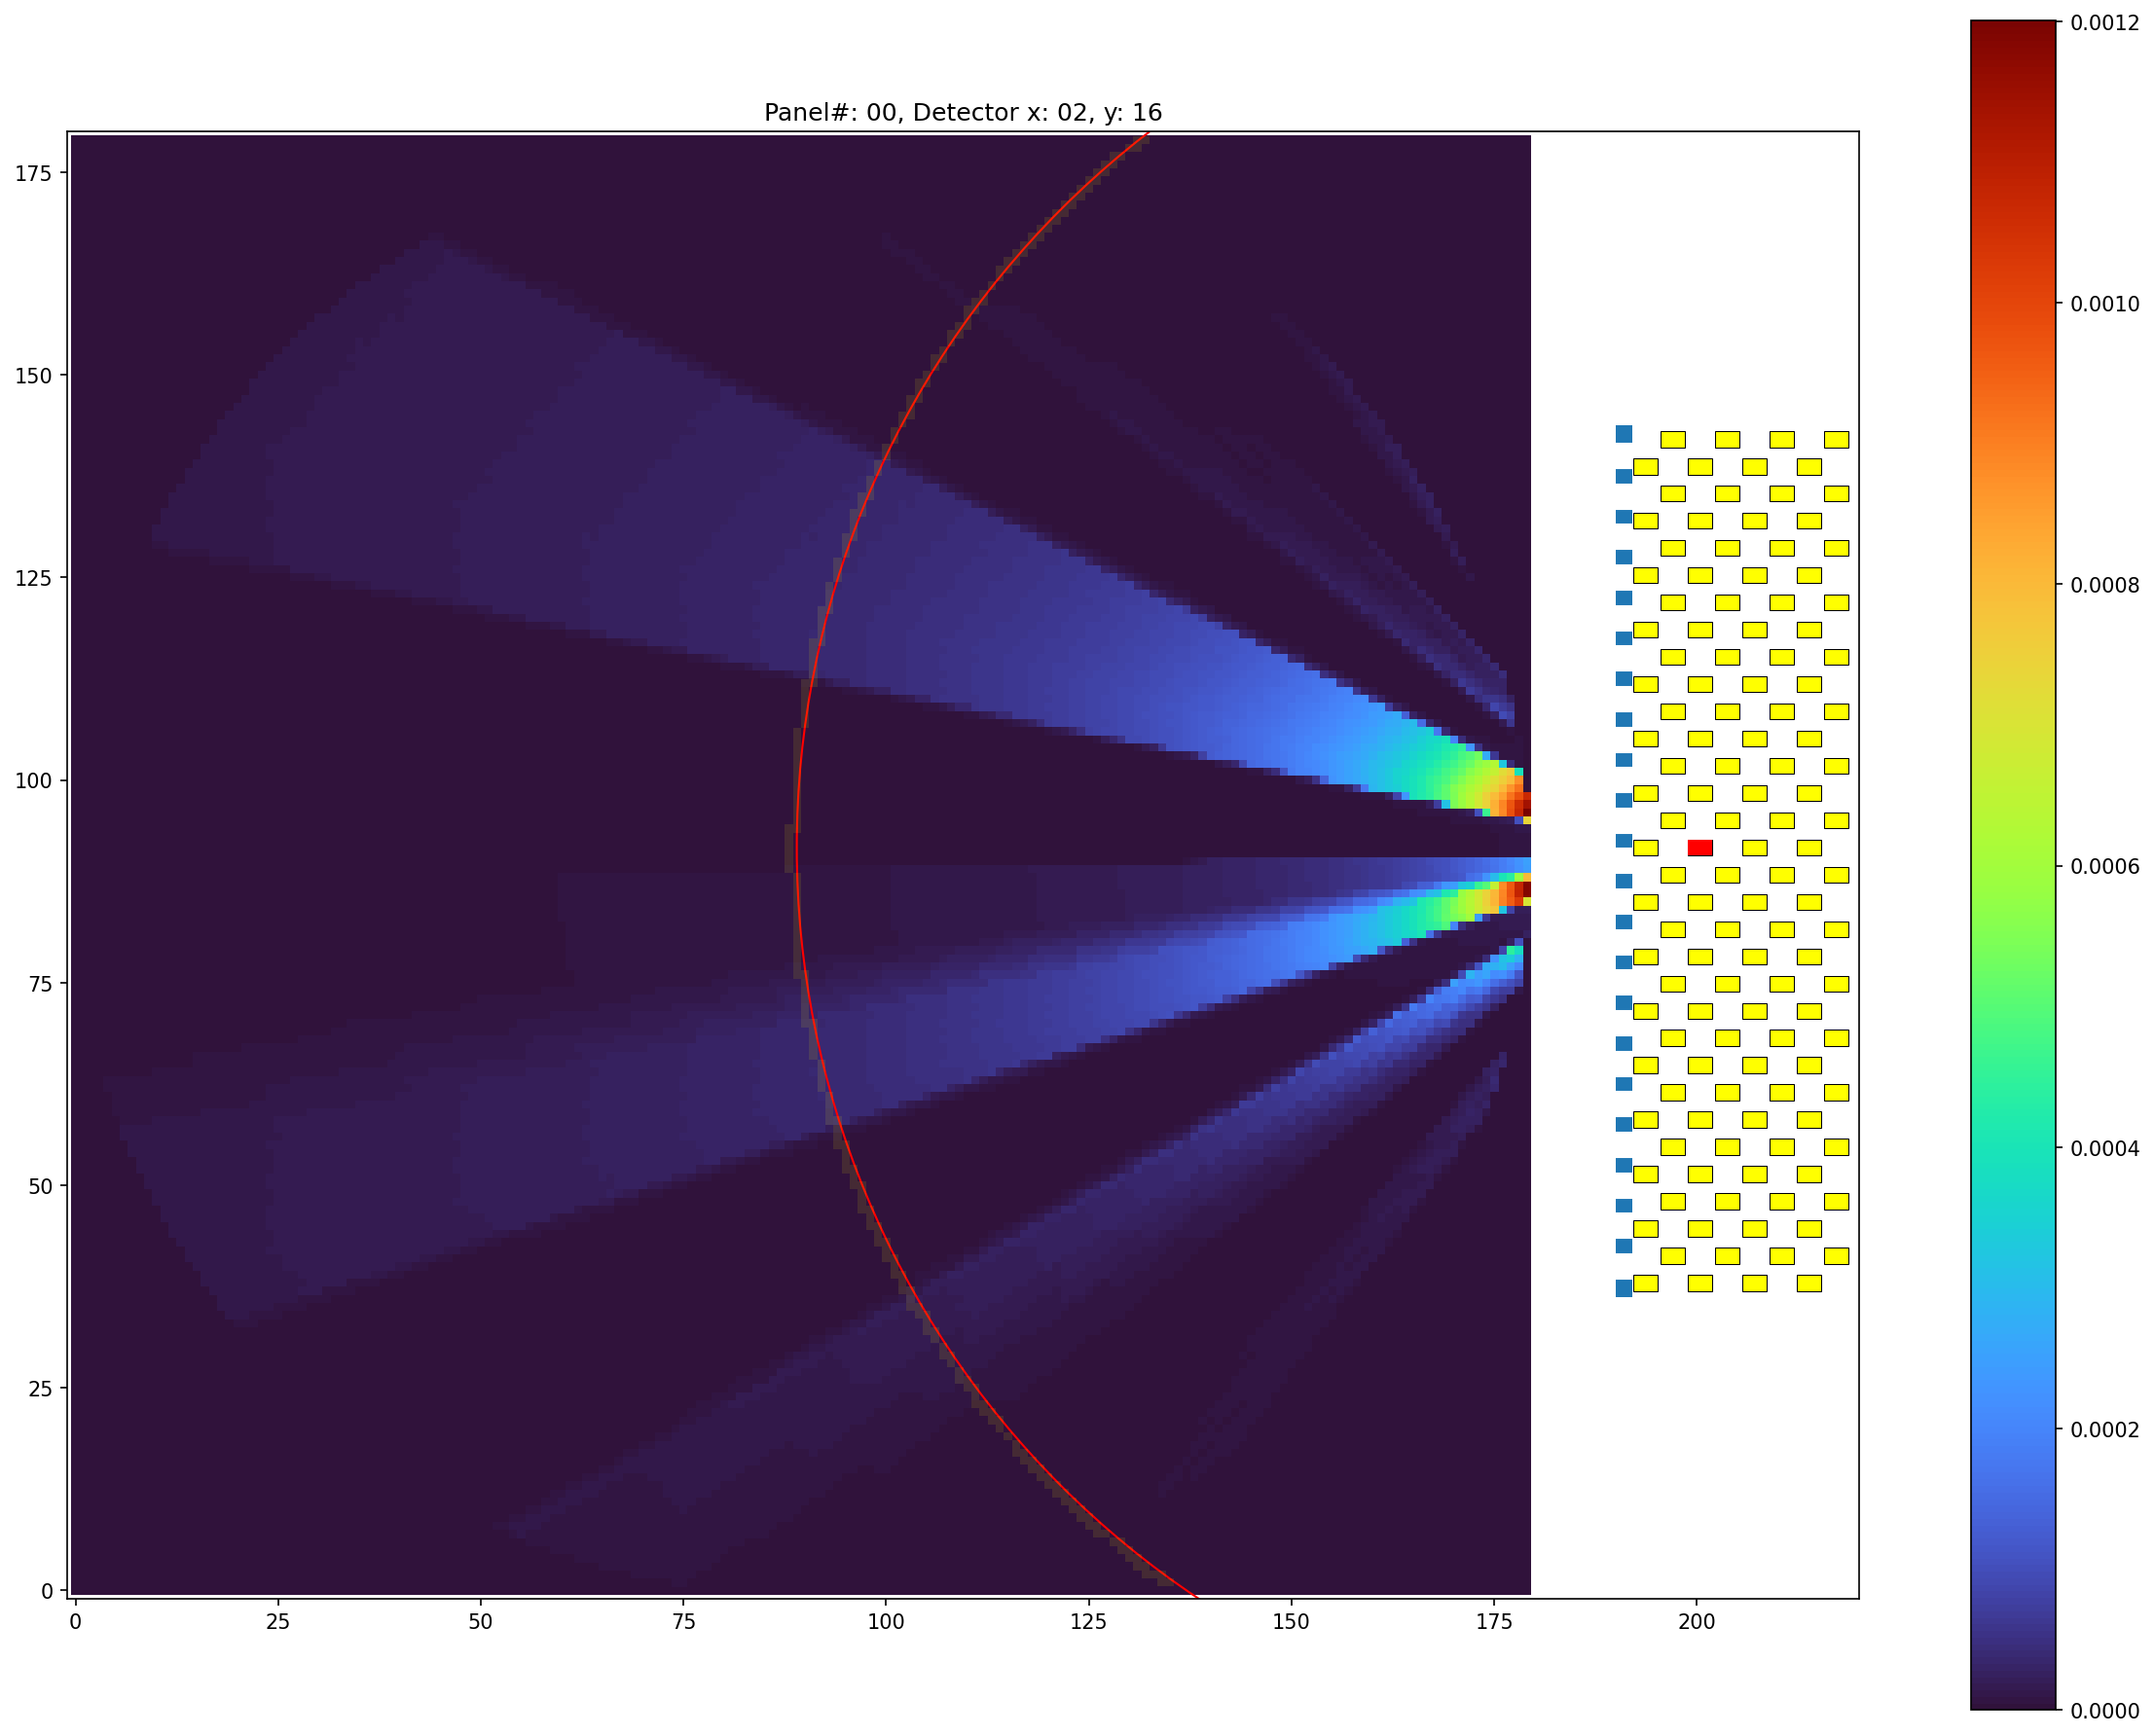

In [10]:
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 150
fig, ax = plt.subplots()
# imshow_obj=ax.imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=mpl.colormaps['turbo'],origin='lower')
# ax.add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False))

ax.add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax.add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    # ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax.add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1

pltTitle=ax.set_title('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
imshow_obj=ax.imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')
ax.set_ylim(-1,180)
ax.set_xlim(-1,220)
ax.add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
print("Radius: ",radius_det)
ax.add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False))
# ax.add_patch(patches.Circle((89,89),radius = 1,color='orange'))
cbar=plt.colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
fig.tight_layout()
hist_arr = []
n_angles = 1000
pre_x_idx = 0
pre_y_idx = 0
thetas = []
for theta in np.arange(math.pi*0.5,math.pi*(1/n_angles+2.5),math.pi/n_angles):
    y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
    x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
    x_idx = math.floor(x_cord)
    y_idx = math.floor(y_cord)
    if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
        if pre_x_idx != x_idx or pre_y_idx != y_idx:
        # print(x_idx,y_idx)
            hist_arr.append(dataImage[dIdxX,0,dIdxY,x_idx,y_idx])
            thetas.append(theta)
            ax.add_patch(patches.Rectangle((x_idx-0.5, y_idx-0.5), 1.0, 1.0, facecolor='yellow', alpha=0.1))
    pre_x_idx = x_idx
    pre_y_idx = y_idx

2.670353755551324
0.2827433388230814
[2.07526100e-04 1.06409943e-05]


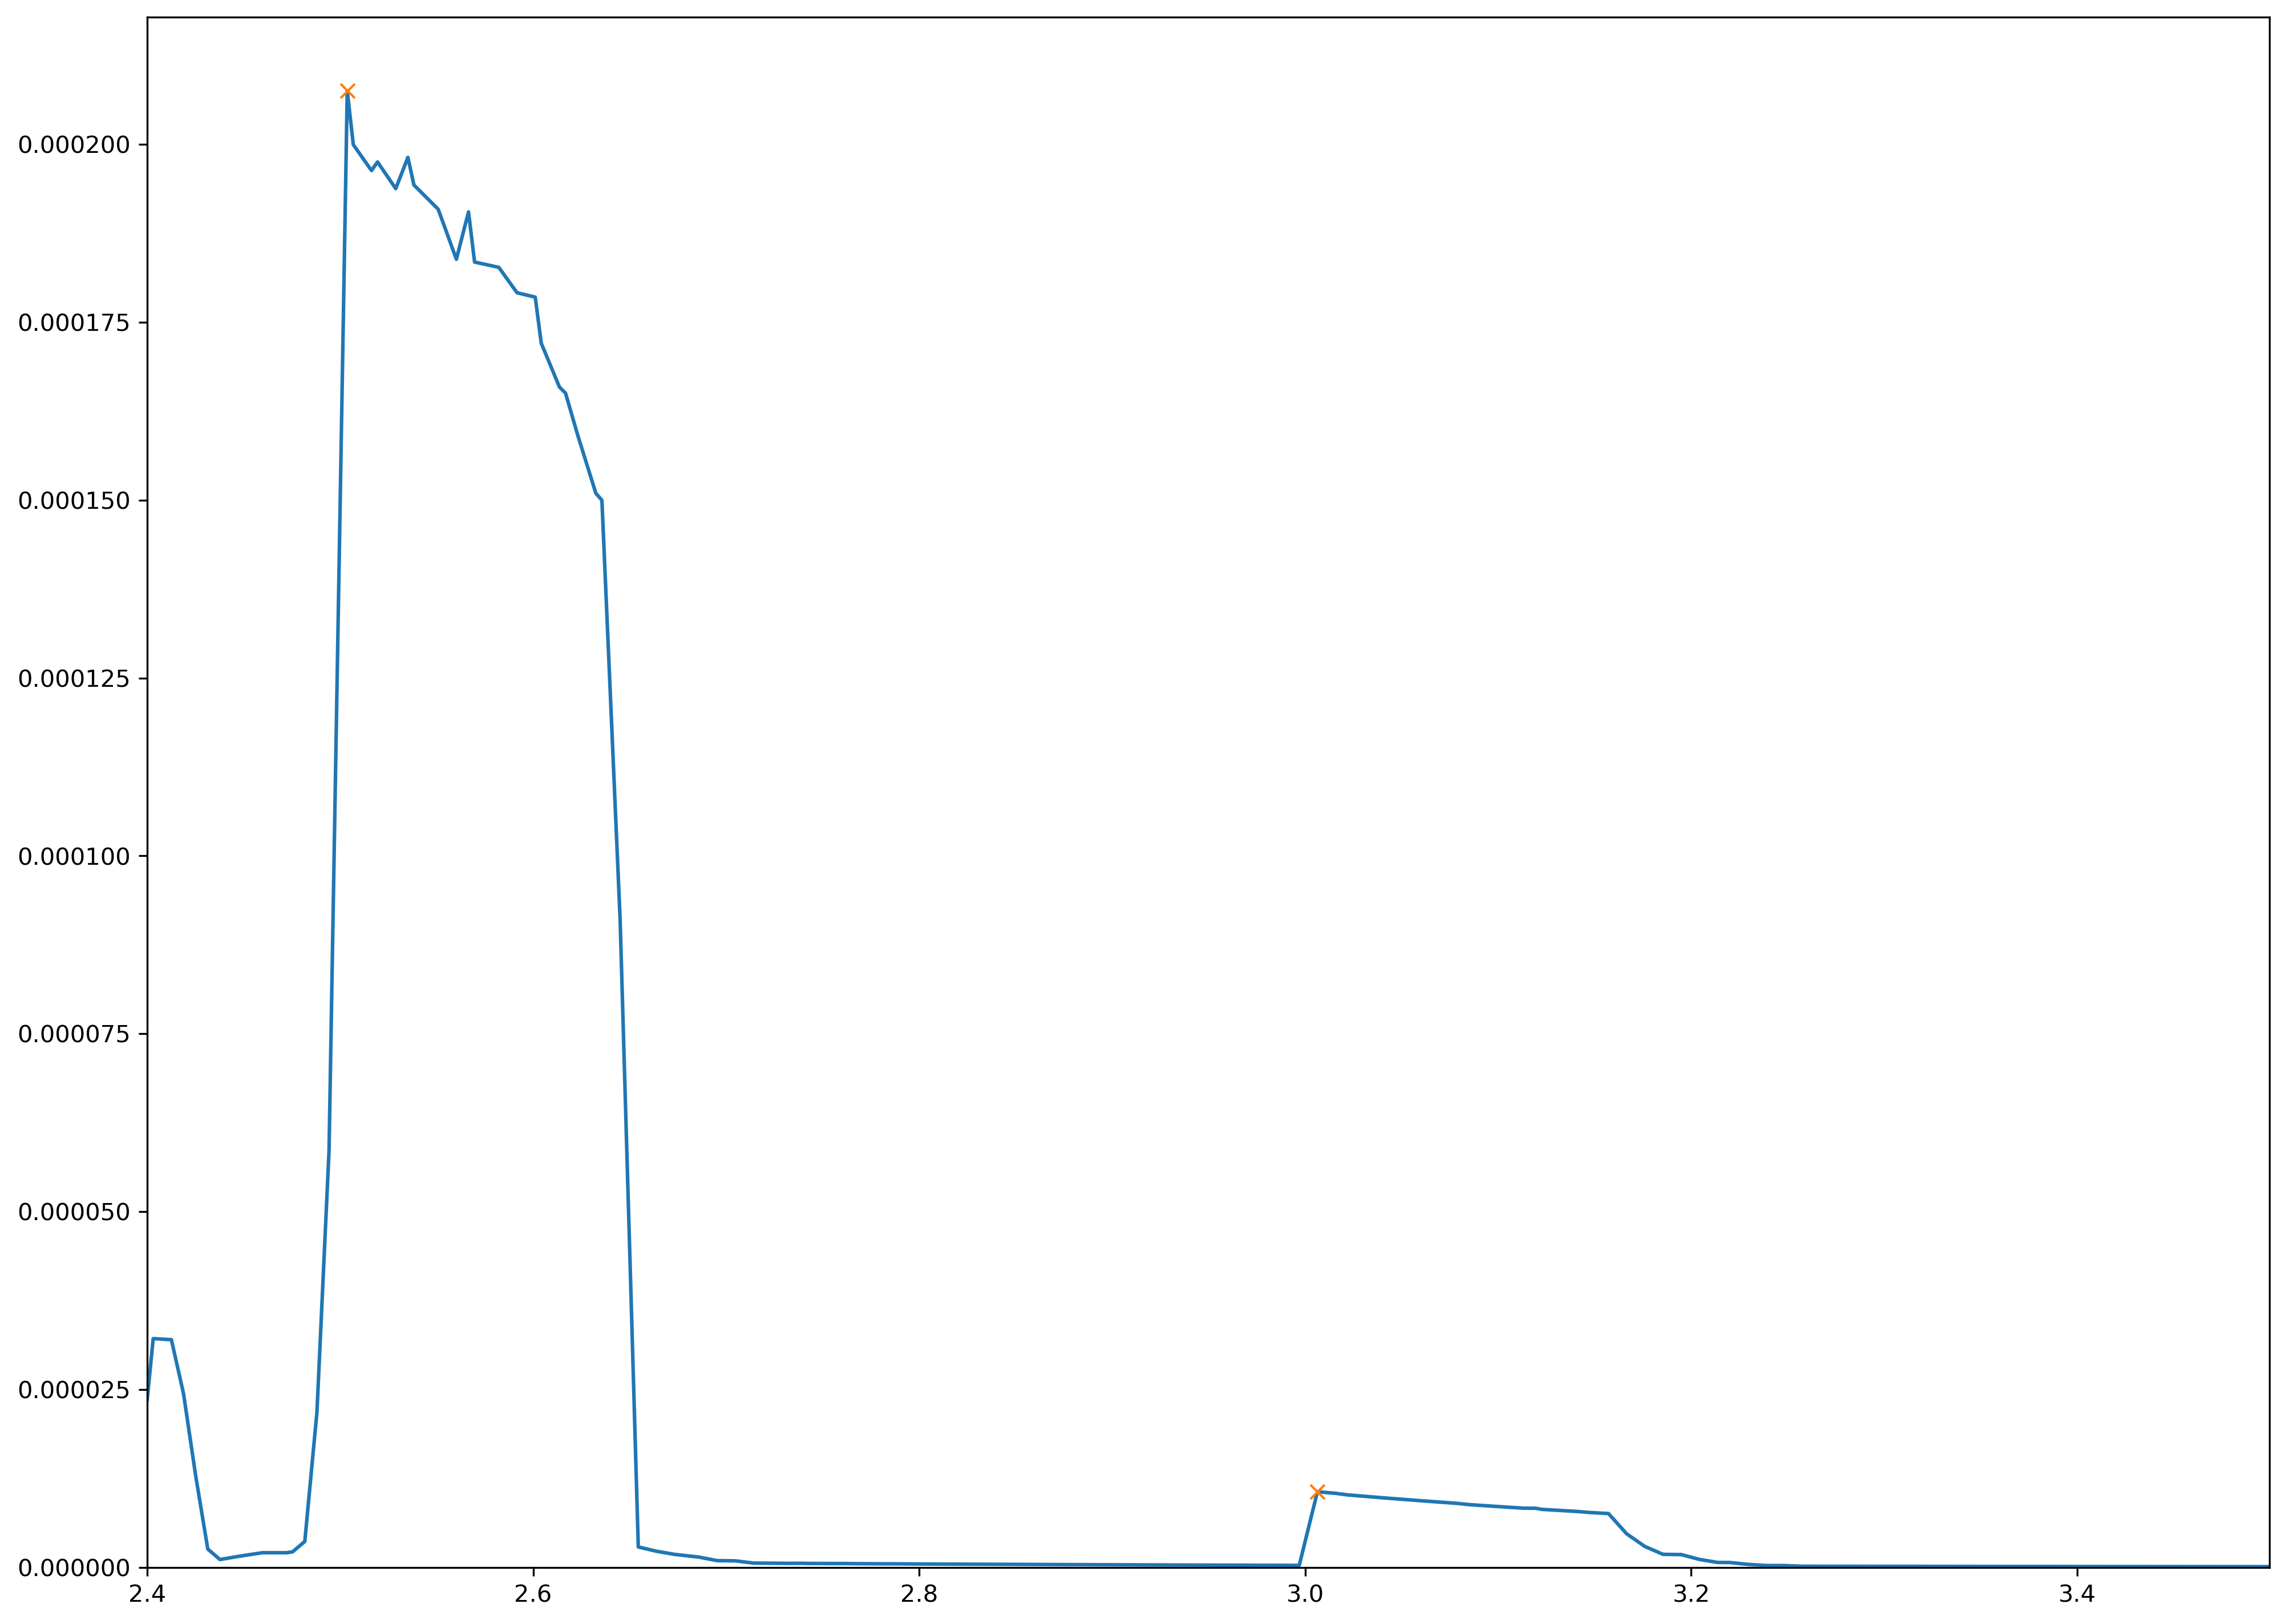

In [11]:
n_angles = 1000
arrowScale = 0.005
hist_arr = []
pre_x_idx = 0
pre_y_idx = 0
thetas = []
start_angle = 2.4
end_angle = 3.5
print(math.pi*0.85)
print(math.pi*0.09)
for theta in np.arange(start_angle,end_angle,math.pi/n_angles):
    y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
    x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
    x_idx = math.floor(x_cord)
    y_idx = math.floor(y_cord)
          
    if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
        if pre_x_idx != x_idx or pre_y_idx != y_idx:
        # print(x_idx,y_idx)
            hist_arr.append(dataImage[dIdxX,0,dIdxY,x_idx,y_idx])
            thetas.append(theta)
    pre_x_idx = x_idx
    pre_y_idx = y_idx
signal=np.asarray(hist_arr)
thetas=np.asarray(thetas)
peaks, peak_prop = find_peaks(signal, height=0, prominence= 1e-5)
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots()
ax.plot(thetas,signal)
ax.set_xlim(np.min(thetas),np.max(thetas))
ax.plot(thetas[peaks], signal[peaks], "x")
ymin,ymax = ax.get_ylim()
# ax.arrow(0,0, 10, 1e-5, head_width=1, head_length=0.1, fc='k', ec='k')
ax.set_ylim(0)
# widths, width_heights, left_ips, right_ips = peak_widths(signal, peaks, rel_height=0.5)
# ax.vlines(f1(signal[peaks[0]]*0.5), 0, ymax, linewidth = 1, color = '0.5',linestyle='--')
# ax.vlines(f2(signal[peaks[0]]*0.5), 0, ymax, linewidth = 1, color = '0.5',linestyle='--')
# for width, height, left, right in np.column_stack(peak_widths(signal, peaks, rel_height=0.5)):
#     ax.vlines(left, 0, height+5e-6, linewidth = 1, color = '0.5',linestyle='--')
#     ax.vlines(right, 0, height+5e-6, linewidth = 1, color = '0.5',linestyle='--')
#     ax.hlines(height,left,right,linewidth = 1, color='k',linestyle='dotted')
#     ax.arrow(left-3,height, 2, 0, head_length=1,width=0.5e-7, fc='k', ec='k')
#     ax.arrow(right+3,height, -2, 0, head_length=1,width=0.5e-7, fc='k', ec='k')
print(signal[peaks])

In [12]:
mycurve = shapely.geometry.LineString(np.column_stack((thetas,signal)))
hline1 = shapely.geometry.LineString(np.array([[1.5,5e-6],[2.5,5e-6]]))

widths, width_heights, left_ips, right_ips = peak_widths(signal, peaks, rel_height=0.5)
def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

In [13]:
plt.ion()

# PPDF Analysis

## Create helper functions 

In [14]:
from numpy import *
def seg_intersect(a1,a2,b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = dot( dap, db)
    num = dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def perp( a ) :
    b = empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

In [15]:
'''
Finds the intersection between the PPDF signal array and the 75% peak signal line.
'''
def get_intersection_point_75p_line(signal):
    
    #Find the index of the points in the signal array closest to the 75% of peak signal
    #We need two points since the signal curve cuts the 75% line at two places.
#     abs_diff = np.abs(signal-signal[peak_x]*0.75)
    close_point_idx_left = 0 #np.argmin(abs_diff[0:peak_x])
    close_point_idx_right = 0 #np.argmin(abs_diff[peak_x:])+peak_x
    for i in range(1, len(signal)):
        if signal[i-1]<signal[peak_x]*0.75<signal[i]:
            left_point_one=np.array([thetas[i-1],signal[i-1]])
            left_point_two=np.array([thetas[i],signal[i]])
        elif signal[i-1]>signal[peak_x]*0.75>signal[i]:
            right_point_one=np.array([thetas[i-1],signal[i-1]])
            right_point_two=np.array([thetas[i],signal[i]])
        
            
            
#     close_point_idx_left = np.argmin(abs_diff[0:peak_x])
#     close_point_idx_right = np.argmin(abs_diff[peak_x:])+peak_x
    
#     print(close_point_idx_left,close_point_idx_right)
    
#     #Find two points to the left of the peak signal that encloses the intersection point
#     #of the 75% line and the signal curve
#     if signal[close_point_idx_left]-signal[peak_x]*0.75 > 0:
#     left_point_one = np.array([thetas[close_point_idx_left-1],signal[close_point_idx_left-1]])
#     left_point_two = np.array([thetas[close_point_idx_left],signal[close_point_idx_left]])
#         print("left +ve")
#     else:
#         left_point_one = np.array([thetas[close_point_idx_left],signal[close_point_idx_left]])
#         left_point_two = np.array([thetas[close_point_idx_left+1],signal[close_point_idx_left+1]])
#         print("left -ve")
        
    print(left_point_one,left_point_two)
    
    #Find two points to the right of the peak signal that encloses the intersection point
    #of the 75% line and the signal curve
#     if signal[close_point_idx_right]-signal[peak_x]*0.75 > 0:
#         right_point_one = np.array([thetas[close_point_idx_right],signal[close_point_idx_right]])
#         right_point_two = np.array([thetas[close_point_idx_right+1],signal[close_point_idx_right+1]])
#         print("right +ve")
#     else:
#         right_point_one = np.array([thetas[close_point_idx_right-1],signal[close_point_idx_right-1]])
#         right_point_two = np.array([thetas[close_point_idx_right],signal[close_point_idx_right]])
#         print("right -ve")
        
    print(right_point_one,right_point_two)
    
    #Find the intersection point between the 75% line and the two points enclosing the intersecting
    #point on the left of the peak signal
    intersection_pt_left = seg_intersect(left_point_one,left_point_two,np.array([0,signal[peak_x]*0.75]),np.array([5,signal[peak_x]*0.75]))
    
    #Find the intersection point between the 75% line and the two points enclosing the intersecting
    #point on the right of the peak signal
    intersection_pt_right = seg_intersect(right_point_one,right_point_two,np.array([0,signal[peak_x]*0.75]),np.array([5,signal[peak_x]*0.75])) 
    
    return intersection_pt_left, intersection_pt_right

'''
Finds the intersection between the PPDF signal array and the 25% peak signal line.
'''
def get_intersection_point_25p_line(signal):

    #Find the index of the points in the signal array closest to the 25% of peak signal
    #We need two points since the signal curve cuts the 25% line at two places.
    close_point_idx_left = 0 #np.argmin(abs_diff[0:peak_x])
    close_point_idx_right = 0 #np.argmin(abs_diff[peak_x:])+peak_x
    for i in range(1, len(signal)):
        if signal[i-1]<signal[peak_x]*0.25<signal[i]:
            left_point_one=np.array([thetas[i-1],signal[i-1]])
            left_point_two=np.array([thetas[i],signal[i]])
        elif signal[i-1]>signal[peak_x]*0.25>signal[i]:
            right_point_one=np.array([thetas[i-1],signal[i-1]])
            right_point_two=np.array([thetas[i],signal[i]])
    
    #Find two points to the left of the peak signal that encloses the intersection point
    #of the 25% line and the signal curve
#     if signal[close_point_idx_left]-signal[peak_x]*0.25 > 0:
#         left_point_one = np.array([thetas[close_point_idx_left-1],signal[close_point_idx_left-1]])
#         left_point_two = np.array([thetas[close_point_idx_left],signal[close_point_idx_left]])
#     else:
#         left_point_one = np.array([thetas[close_point_idx_left],signal[close_point_idx_left]])
#         left_point_two = np.array([thetas[close_point_idx_left+1],signal[close_point_idx_left+1]])
    
    #Find two points to the right of the peak signal that encloses the intersection point
    #of the 25% line and the signal curve
#     if signal[close_point_idx_right]-signal[peak_x]*0.25 > 0:
#         right_point_one = np.array([thetas[close_point_idx_right],signal[close_point_idx_right]])
#         right_point_two = np.array([thetas[close_point_idx_right+1],signal[close_point_idx_right+1]])
#     else:
#         right_point_one = np.array([thetas[close_point_idx_right-1],signal[close_point_idx_right-1]])
#         right_point_two = np.array([thetas[close_point_idx_right],signal[close_point_idx_right]])
        
    #Find the intersection point between the 25% line and the two points enclosing the intersecting
    #point on the left of the peak signal
    intersection_pt_left = seg_intersect(left_point_one,left_point_two,np.array([0,signal[peak_x]*0.25]),np.array([5,signal[peak_x]*0.25]))
    
    #Find the intersection point between the 25% line and the two points enclosing the intersecting
    #point on the right of the peak signal
    intersection_pt_right = seg_intersect(right_point_one,right_point_two,np.array([0,signal[peak_x]*0.25]),np.array([5,signal[peak_x]*0.25])) 
    
    return intersection_pt_left, intersection_pt_right




## Plot PPDF

Radius:  111.4322323208146
[3.30181388e+00 2.44849562e-05] [3.31123866e+00 2.98383075e-05]
[3.44632714e+00 3.79449484e-05] [3.44946873e+00 1.42237795e-05]


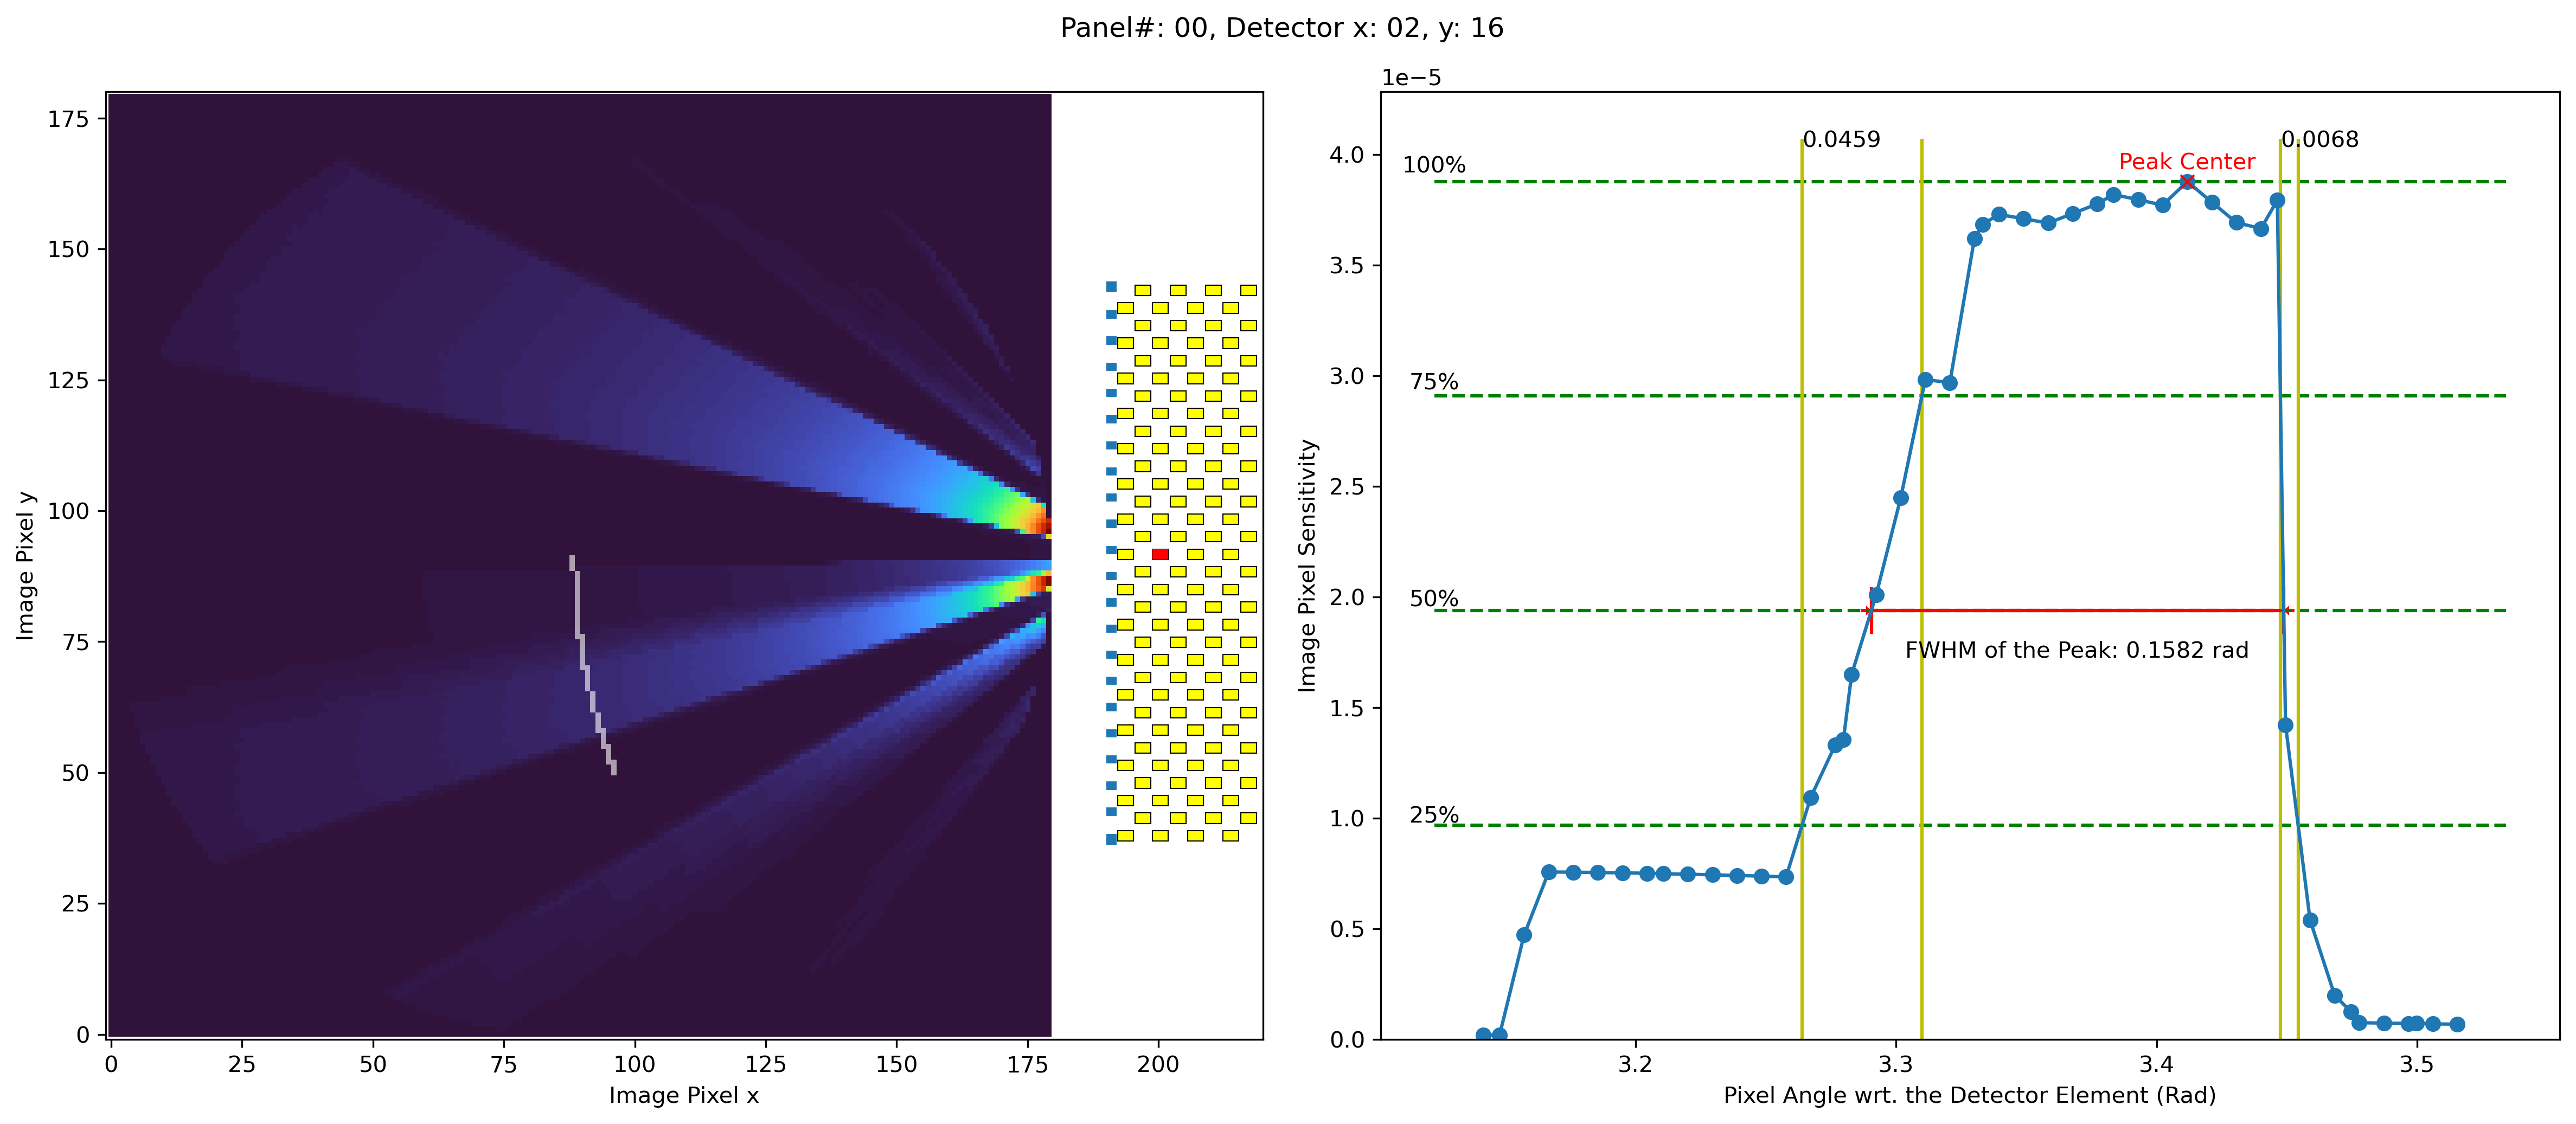

In [16]:
n_angles = 1000
arrowScale = 0.005

radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
plt.rcParams["figure.figsize"] = (16,7)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(1,2)

#Draw geometry
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
ax[0].add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax[0].add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    # ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax[0].add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1



ax[0].set_ylim(-1,180)
ax[0].set_xlim(-1,220)
ax[0].add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
print("Radius: ",radius_det)
# ax[0].add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False, linestyle=(0, (8, 8)),linewidth=0.5))
# ax.add_patch(patches.Circle((89,89),radius = 1,color='orange'))
# cbar=ax[0].colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
# fig.tight_layout()
hist_arr = []

pre_x_idx = 0
pre_y_idx = 0
thetas = []
start_angle = math.pi
angle_interval = math.pi*0.12
end_angle = start_angle+angle_interval
for theta in np.arange(start_angle,end_angle,math.pi/n_angles):
    y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
    x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
    x_idx = math.floor(x_cord)
    y_idx = math.floor(y_cord)
    if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
        if pre_x_idx != x_idx or pre_y_idx != y_idx:
        # print(x_idx,y_idx)
            hist_arr.append(dataImage[dIdxX,0,dIdxY,y_idx,x_idx])
            thetas.append(theta)
            # dataImage[dIdxX,0,dIdxY,y_idx,x_idx]=5e-4
            ax[0].add_patch(patches.Rectangle((x_idx-0.5, y_idx-0.5), 1.0, 1.0, facecolor='w', alpha=0.6))
    pre_x_idx = x_idx
    pre_y_idx = y_idx
ax[0].set_xlabel('Image Pixel x')
ax[0].set_ylabel('Image Pixel y')   
imshow_obj=ax[0].imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')

# Right plot
signal=np.asarray(hist_arr)
thetas=np.asarray(thetas)
peaks, peak_prop = find_peaks(signal, height=0, prominence= 2e-6,distance=5)
mycurve = shapely.geometry.LineString(np.column_stack((thetas,signal)))    
    
ax[1].plot(thetas,signal,"o-")
# print(widths[0])

ax[1].plot(thetas[peaks], signal[peaks], "x",color='r')
xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()
xlen = xmax-xmin
ylen = ymax-ymin

peak_idx=0
for peak_x in peaks:
    thisPeakW = 0.5
    hline1 = shapely.geometry.LineString(np.array([[thetas[peak_x]-thisPeakW,signal[peak_x]*0.5],[thetas[peak_x]+thisPeakW,signal[peak_x]*0.5]]))
    intersection = mycurve.intersection(hline1)
    peak_idx = peak_idx + 1
    xp,yp=np.transpose(shapely.get_coordinates(intersection))
    #points on the left of the peak
    left= xp[(xp-thetas[peak_x])<0]
    #points on the right of the peak
    right=xp[(xp-thetas[peak_x])>0]
    #sort the points based on the distance
    sort_index_l = np.argsort(np.abs(left-thetas[peak_x]))
    sort_index_r = np.argsort(np.abs(right-thetas[peak_x]))
    w_p_l = left[sort_index_l[0]]
    w_p_r = right[sort_index_r[0]]
    height = signal[peak_x]*0.5
    height_100 = signal[peak_x]
    height_75 = signal[peak_x]*0.75
    height_50 = signal[peak_x]*0.5
    height_25 = signal[peak_x]*0.25
    
    ax[1].arrow(w_p_l-2*arrowScale*xlen,height, arrowScale*xlen, 0, head_length=arrowScale*xlen, width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].arrow(w_p_r+2*arrowScale*xlen,height, -arrowScale*xlen, 0, head_length=arrowScale*xlen,width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].vlines(w_p_l,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    ax[1].vlines(w_p_r,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    
    #Plot horizontal line at different intensity level
    ax[1].hlines(height_100,xmin,xmax,ec='g',linestyle='--',)
    ax[1].hlines(height_75,xmin,xmax,ec='g',linestyle='--',)
    ax[1].hlines(height_50,xmin,xmax,ec='g',linestyle='--',)
    ax[1].hlines(height_25,xmin,xmax,ec='g',linestyle='--',)
    
    ax[1].text(xmin, height_100*1.01,'100%',ha="center")
    ax[1].text(xmin, height_75*1.01,'75%',ha="center")
    ax[1].text(xmin, height_50*1.01,'50%',ha="center")
    ax[1].text(xmin, height_25*1.01,'25%',ha="center")
    
    #Get the intersection points of above lines with the PPDF curve
    pt_25_left, pt_25_right = get_intersection_point_25p_line(signal)
    pt_75_left, pt_75_right = get_intersection_point_75p_line(signal)
    
    #Plot vertical line at the intersection of above lines with the PPDF curve.
    ax[1].vlines(pt_25_left[0],ymin,ymax,ec='y',linestyle='-',)
    ax[1].vlines(pt_25_right[0],ymin,ymax,ec='y',linestyle='-',)
    ax[1].vlines(pt_75_left[0],ymin,ymax,ec='y',linestyle='-',)
    ax[1].vlines(pt_75_right[0],ymin,ymax,ec='y',linestyle='-',)
    ax[1].text(pt_25_left[0], ylen*0.95,'{:.4f}'.format(pt_75_left[0]-pt_25_left[0]),ha="left")
    ax[1].text(pt_75_right[0], ylen*0.95,'{:.4f}'.format(pt_25_right[0]-pt_75_right[0]),ha="left")
    
    ax[1].hlines(height,w_p_l,w_p_r,ec='r')
    ax[1].text((w_p_r+w_p_l)*0.5, height-ylen*0.05,'FWHM of the Peak: {:.4f} rad'.format(w_p_r-w_p_l),ha="center")
    ax[1].text(thetas[peak_x], signal[peak_x]+ylen*0.02,'Peak Center',ha="center", va="center",color='r')
ax[1].set_xlabel('Pixel Angle wrt. the Detector Element (Rad)')
ax[1].set_ylabel('Image Pixel Sensitivity')
ax[1].set_ylim(0)
pltTitle=fig.suptitle('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
# ax[0].text(125,182, 'Projection Line',color='orange')
plt.tight_layout()
fig.savefig("ppdf_line/p{:02d}_dx{:02d}_dy{:02d}_{:.2f}_{:.2f}.png".format(0,dIdxX,dIdxY,start_angle,end_angle))

# Find area under the PPDF curve

Area under curve 6.894658968367437e-06
Radius:  111.4322323208146


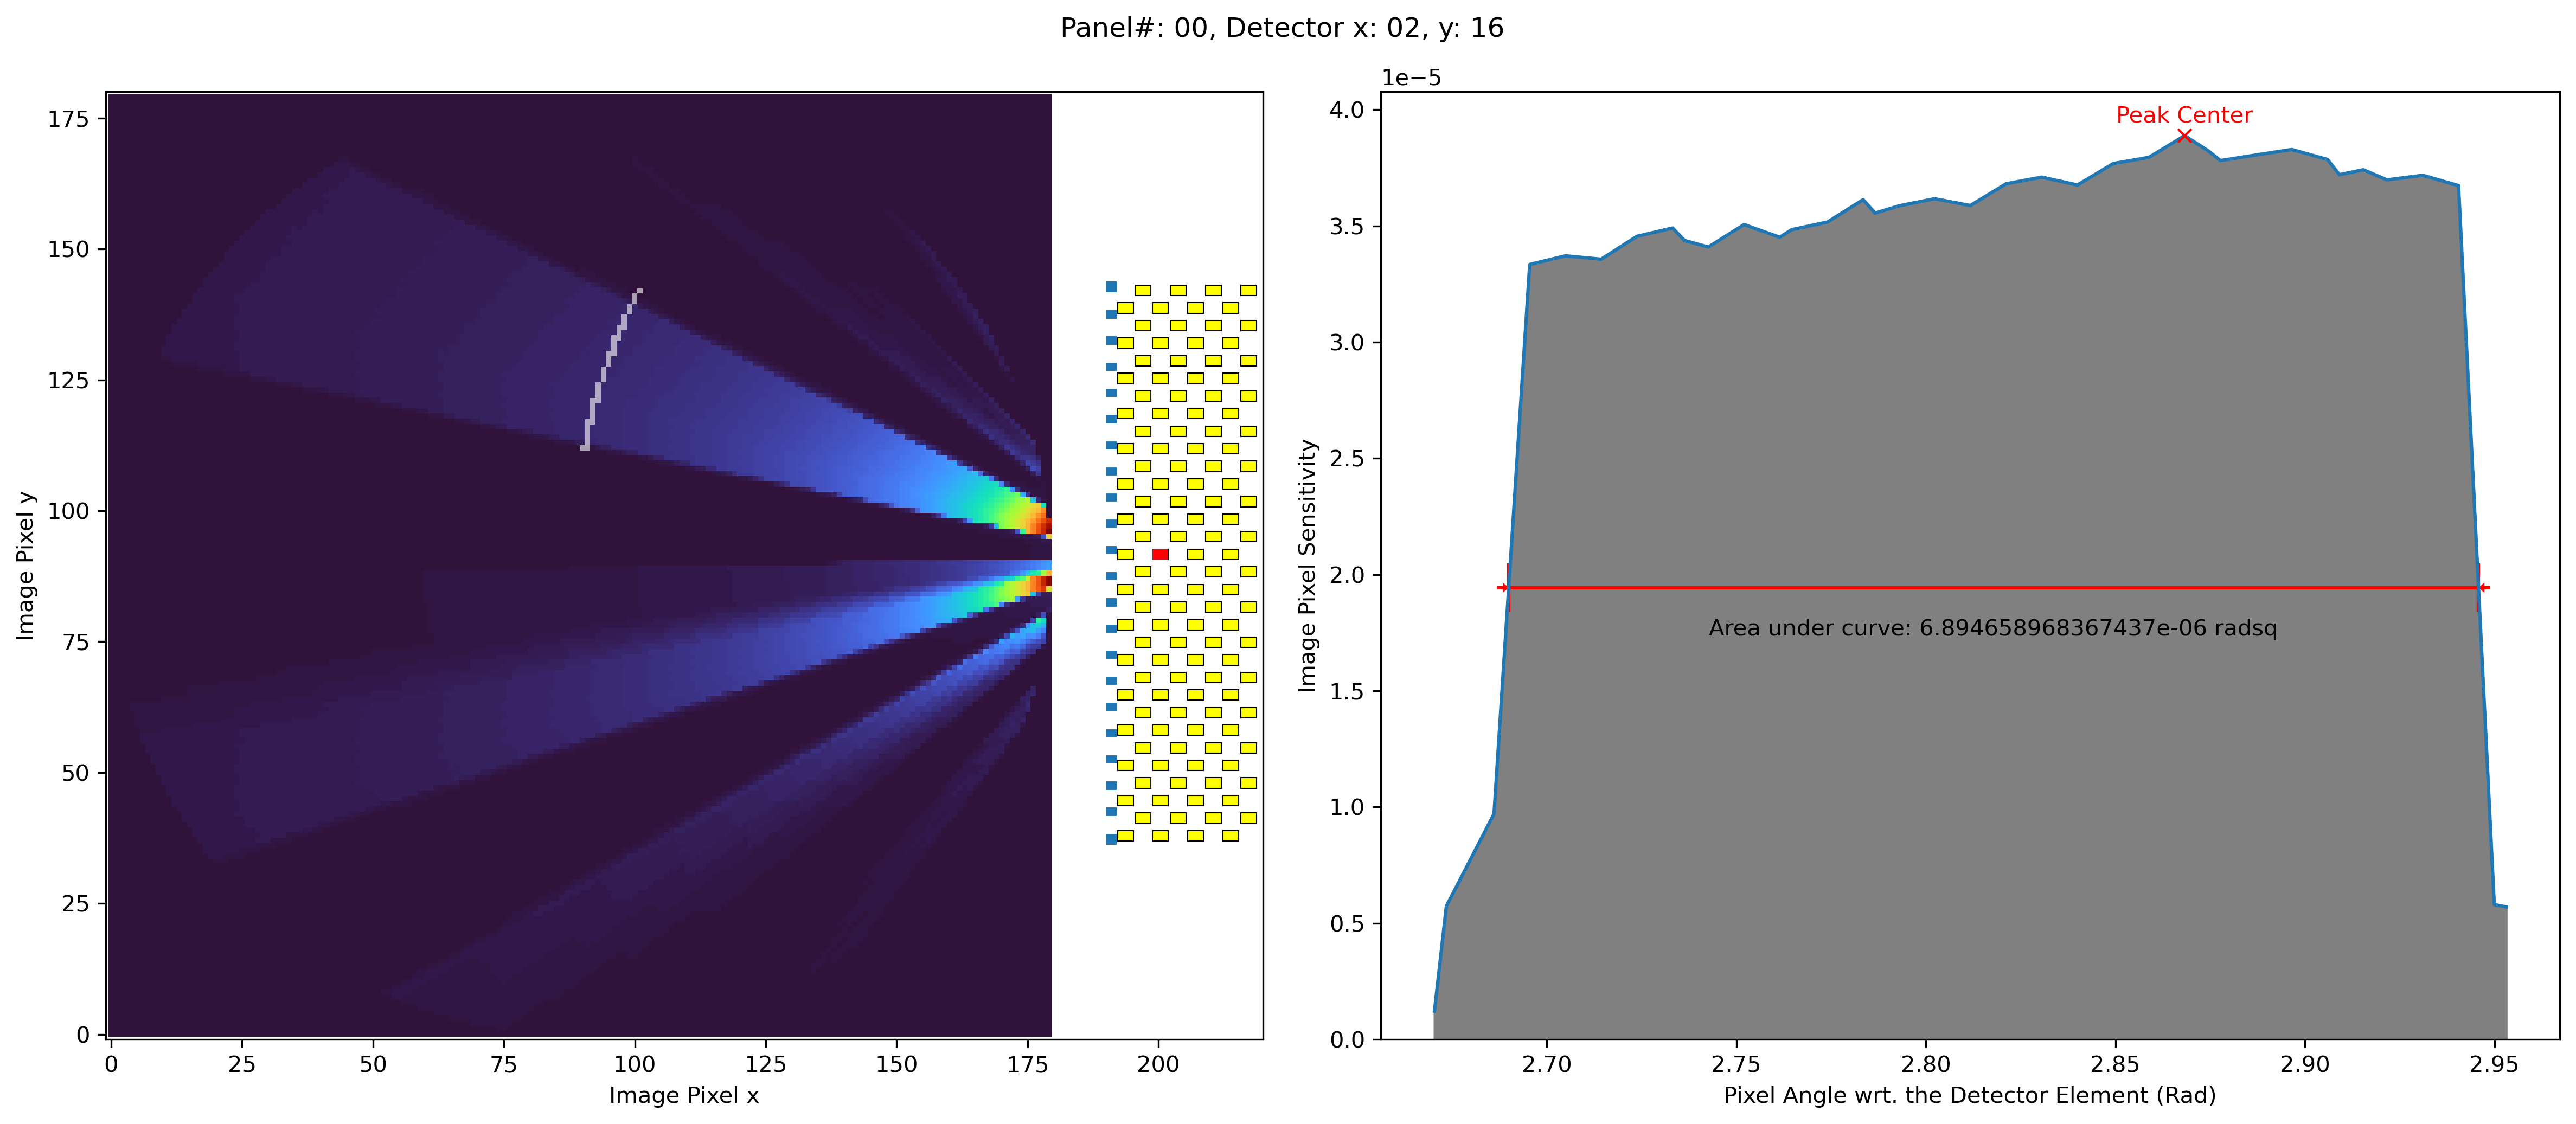

In [17]:
auc = np.trapz(signal,thetas)
print(f"Area under curve {auc}")

n_angles = 1000
arrowScale = 0.005

radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
plt.rcParams["figure.figsize"] = (16,7)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(1,2)

#Draw geometry
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
ax[0].add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax[0].add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    # ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax[0].add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1



ax[0].set_ylim(-1,180)
ax[0].set_xlim(-1,220)
ax[0].add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
print("Radius: ",radius_det)
# ax[0].add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False, linestyle=(0, (8, 8)),linewidth=0.5))
# ax.add_patch(patches.Circle((89,89),radius = 1,color='orange'))
# cbar=ax[0].colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
# fig.tight_layout()
hist_arr = []

pre_x_idx = 0
pre_y_idx = 0
thetas = []
start_angle = math.pi*0.85
angle_interval = math.pi*0.09
end_angle = start_angle+angle_interval
for theta in np.arange(start_angle,end_angle,math.pi/n_angles):
    y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
    x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
    x_idx = math.floor(x_cord)
    y_idx = math.floor(y_cord)
    if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
        if pre_x_idx != x_idx or pre_y_idx != y_idx:
        # print(x_idx,y_idx)
            hist_arr.append(dataImage[dIdxX,0,dIdxY,y_idx,x_idx])
            thetas.append(theta)
            # dataImage[dIdxX,0,dIdxY,y_idx,x_idx]=5e-4
            ax[0].add_patch(patches.Rectangle((x_idx-0.5, y_idx-0.5), 1.0, 1.0, facecolor='w', alpha=0.6))
    pre_x_idx = x_idx
    pre_y_idx = y_idx
ax[0].set_xlabel('Image Pixel x')
ax[0].set_ylabel('Image Pixel y')   
imshow_obj=ax[0].imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')

# Right plot
signal=np.asarray(hist_arr)
thetas=np.asarray(thetas)
peaks, peak_prop = find_peaks(signal, height=0, prominence= 2e-6,distance=5)
mycurve = shapely.geometry.LineString(np.column_stack((thetas,signal)))    
    
ax[1].plot(thetas,signal,"-")
# print(widths[0])

ax[1].plot(thetas[peaks], signal[peaks], "x",color='r')
xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()
xlen = xmax-xmin
ylen = ymax-ymin

peak_idx=0
for peak_x in peaks:
    thisPeakW = 0.5
    hline1 = shapely.geometry.LineString(np.array([[thetas[peak_x]-thisPeakW,signal[peak_x]*0.5],[thetas[peak_x]+thisPeakW,signal[peak_x]*0.5]]))
    intersection = mycurve.intersection(hline1)
    peak_idx = peak_idx + 1
    xp,yp=np.transpose(shapely.get_coordinates(intersection))
    #points on the left of the peak
    left= xp[(xp-thetas[peak_x])<0]
    #points on the right of the peak
    right=xp[(xp-thetas[peak_x])>0]
    #sort the points based on the distance
    sort_index_l = np.argsort(np.abs(left-thetas[peak_x]))
    sort_index_r = np.argsort(np.abs(right-thetas[peak_x]))
    w_p_l = left[sort_index_l[0]]
    w_p_r = right[sort_index_r[0]]
    height = signal[peak_x]*0.5

    
    ax[1].arrow(w_p_l-2*arrowScale*xlen,height, arrowScale*xlen, 0, head_length=arrowScale*xlen, width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].arrow(w_p_r+2*arrowScale*xlen,height, -arrowScale*xlen, 0, head_length=arrowScale*xlen,width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].vlines(w_p_l,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    ax[1].vlines(w_p_r,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
        
    ax[1].hlines(height,w_p_l,w_p_r,ec='r')
    ax[1].text((w_p_r+w_p_l)*0.5, height-ylen*0.05,f'Area under curve: {auc} radsq',ha="center")
    ax[1].text(thetas[peak_x], signal[peak_x]+ylen*0.02,'Peak Center',ha="center", va="center",color='r')
ax[1].set_xlabel('Pixel Angle wrt. the Detector Element (Rad)')
ax[1].set_ylabel('Image Pixel Sensitivity')
ax[1].set_ylim(0)
pltTitle=fig.suptitle('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
# ax[0].text(125,182, 'Projection Line',color='orange')
plt.tight_layout()
plt.fill_between(thetas,signal, color="gray")
fig.savefig("ppdf_line/plot_shade_p{:02d}_dx{:02d}_dy{:02d}_{:.2f}_{:.2f}.png".format(0,dIdxX,dIdxY,start_angle,end_angle))

Radius:  111.4322323208146
[24 90]
0 52 105
[3.30181388e+00 2.44849562e-05] [3.31123866e+00 2.98383075e-05]
[3.44632714e+00 3.79449484e-05] [3.44946873e+00 1.42237795e-05]
52 104 105
[3.30181388e+00 2.44849562e-05] [3.31123866e+00 2.98383075e-05]
[3.44632714e+00 3.79449484e-05] [3.44946873e+00 1.42237795e-05]


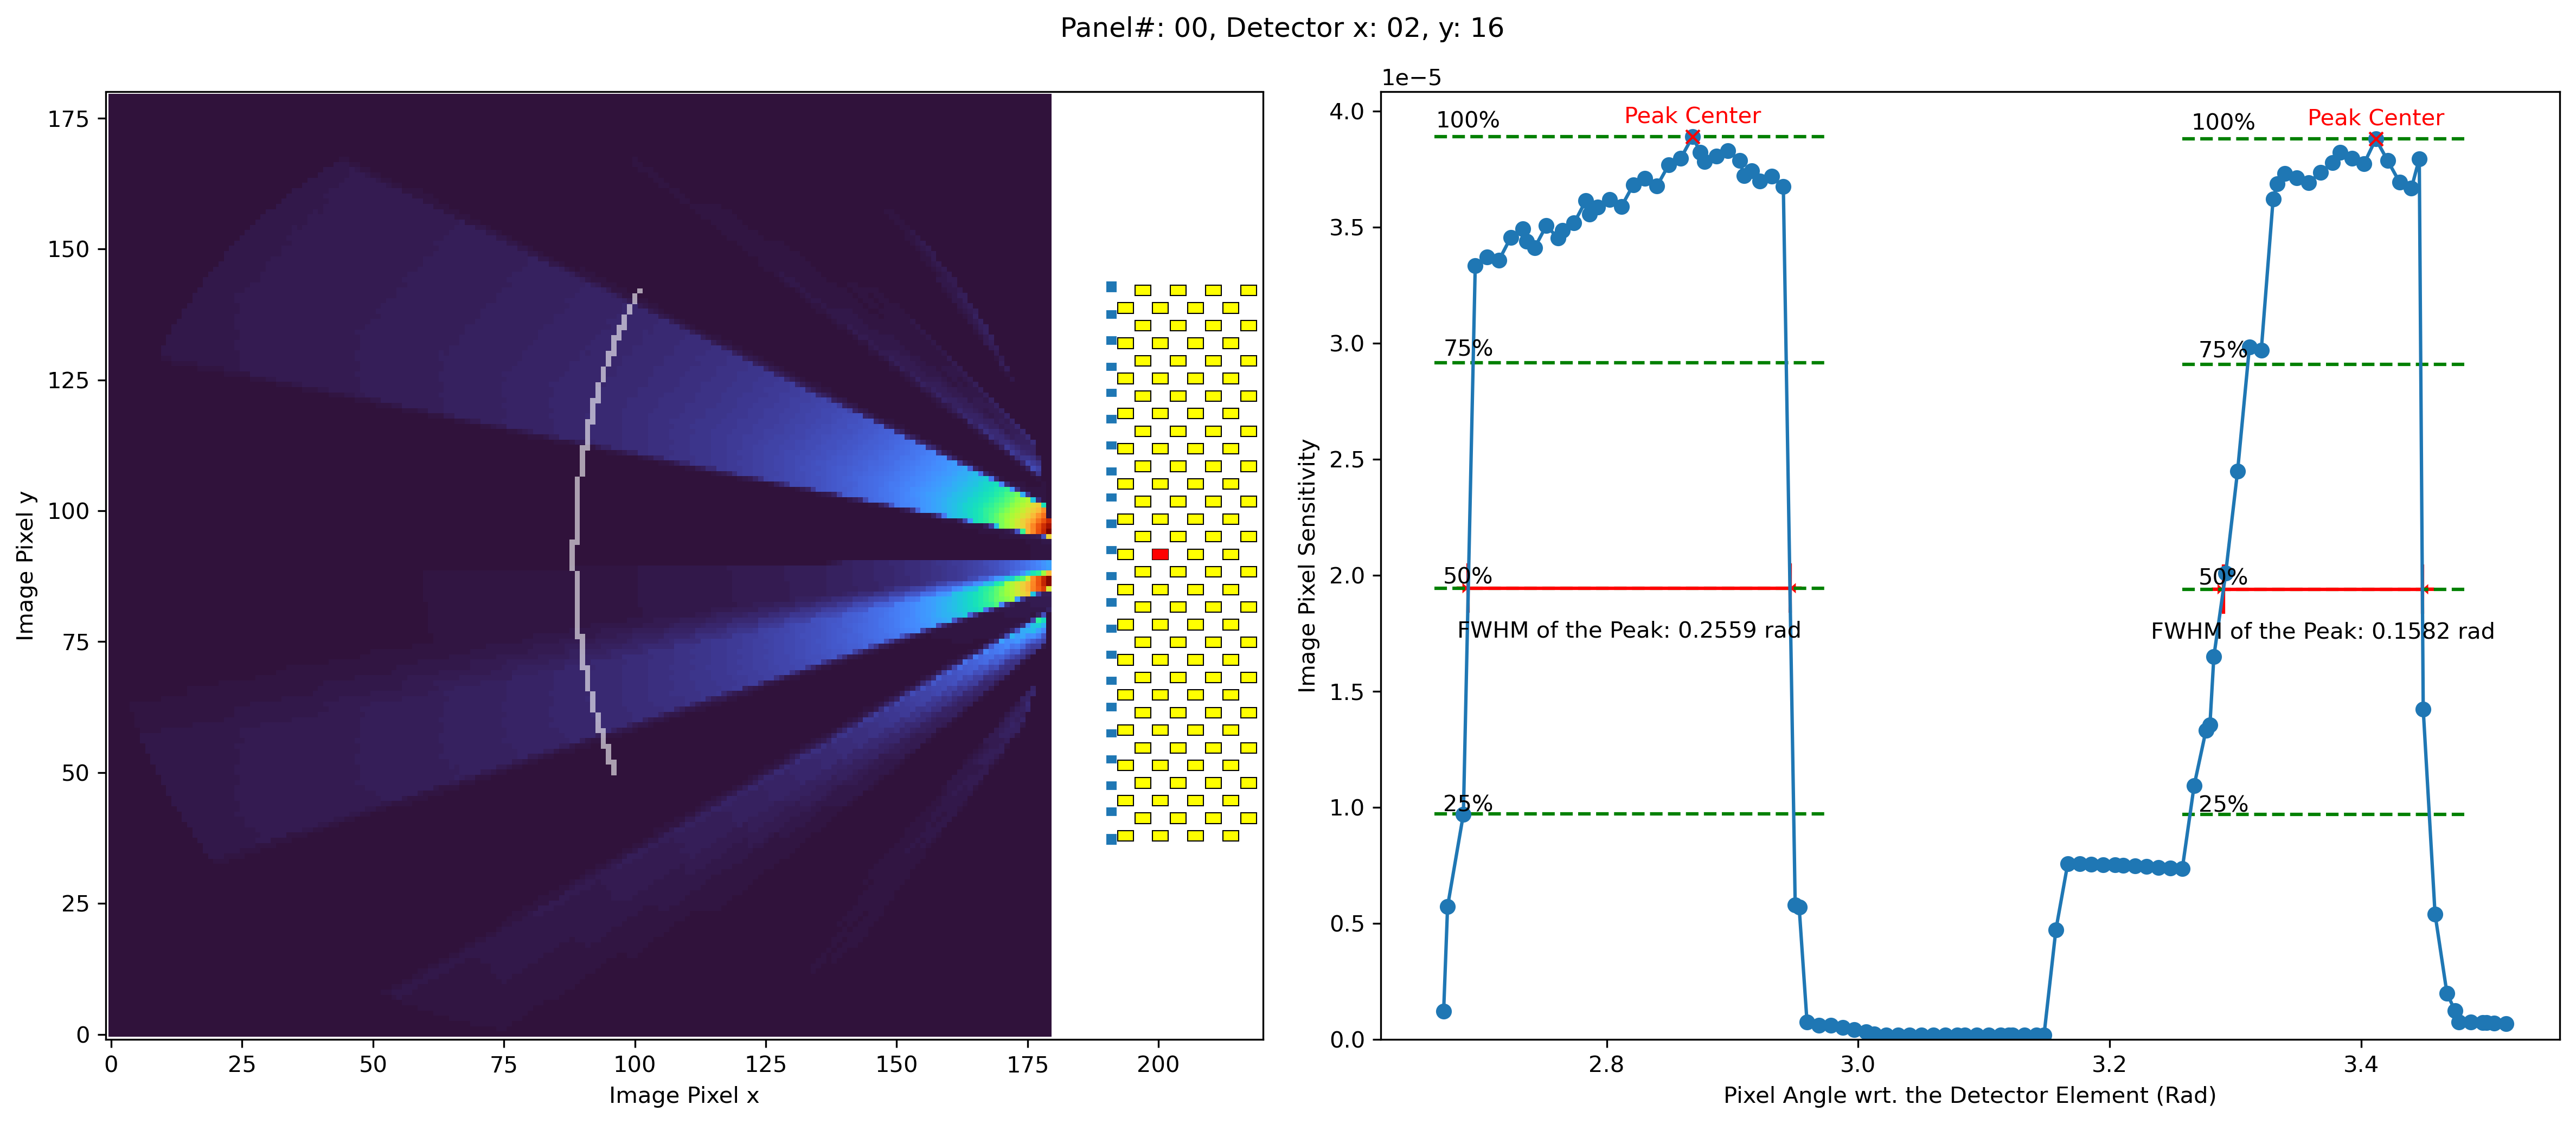

In [18]:
n_angles = 1000
arrowScale = 0.005

radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
plt.rcParams["figure.figsize"] = (16,7)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(1,2)

#Draw geometry
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
ax[0].add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax[0].add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    # ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax[0].add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1



ax[0].set_ylim(-1,180)
ax[0].set_xlim(-1,220)
ax[0].add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
print("Radius: ",radius_det)
# ax[0].add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False, linestyle=(0, (8, 8)),linewidth=0.5))
# ax.add_patch(patches.Circle((89,89),radius = 1,color='orange'))
# cbar=ax[0].colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
# fig.tight_layout()
hist_arr = []

pre_x_idx = 0
pre_y_idx = 0
thetas = []
start_angle = math.pi*0.85
angle_interval = math.pi*0.27
end_angle = start_angle+angle_interval
for theta in np.arange(start_angle,end_angle,math.pi/n_angles):
    y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
    x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
    x_idx = math.floor(x_cord)
    y_idx = math.floor(y_cord)
    if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
        if pre_x_idx != x_idx or pre_y_idx != y_idx:
        # print(x_idx,y_idx)
            hist_arr.append(dataImage[dIdxX,0,dIdxY,y_idx,x_idx])
            thetas.append(theta)
            # dataImage[dIdxX,0,dIdxY,y_idx,x_idx]=5e-4
            ax[0].add_patch(patches.Rectangle((x_idx-0.5, y_idx-0.5), 1.0, 1.0, facecolor='w', alpha=0.6))
    pre_x_idx = x_idx
    pre_y_idx = y_idx
ax[0].set_xlabel('Image Pixel x')
ax[0].set_ylabel('Image Pixel y')   
imshow_obj=ax[0].imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')

# Right plot
signal=np.asarray(hist_arr)
thetas=np.asarray(thetas)
peaks, peak_prop = find_peaks(signal, height=0, prominence= 2e-6,distance=5)
mycurve = shapely.geometry.LineString(np.column_stack((thetas,signal)))    
    
ax[1].plot(thetas,signal,"o-")
# print(widths[0])

ax[1].plot(thetas[peaks], signal[peaks], "x",color='r')
xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()
xlen = xmax-xmin
ylen = ymax-ymin


print(peaks)
peak_idx=0
start = 0
end = len(signal)//len(peaks)
for peak_x in peaks:
    print(start,end,len(signal))
    thisPeakW = 0.5
    hline1 = shapely.geometry.LineString(np.array([[thetas[peak_x]-thisPeakW,signal[peak_x]*0.5],[thetas[peak_x]+thisPeakW,signal[peak_x]*0.5]]))
    intersection = mycurve.intersection(hline1)
    peak_idx = peak_idx + 1
    xp,yp=np.transpose(shapely.get_coordinates(intersection))
    #points on the left of the peak
    left= xp[(xp-thetas[peak_x])<0]
    #points on the right of the peak
    right=xp[(xp-thetas[peak_x])>0]
    #sort the points based on the distance
    sort_index_l = np.argsort(np.abs(left-thetas[peak_x]))
    sort_index_r = np.argsort(np.abs(right-thetas[peak_x]))
    w_p_l = left[sort_index_l[0]]
    w_p_r = right[sort_index_r[0]]
    height = signal[peak_x]*0.5
    height_100 = signal[peak_x]
    height_75 = signal[peak_x]*0.75
    height_50 = signal[peak_x]*0.5
    height_25 = signal[peak_x]*0.25
    
    ax[1].arrow(w_p_l-2*arrowScale*xlen,height, arrowScale*xlen, 0, head_length=arrowScale*xlen, width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].arrow(w_p_r+2*arrowScale*xlen,height, -arrowScale*xlen, 0, head_length=arrowScale*xlen,width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].vlines(w_p_l,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    ax[1].vlines(w_p_r,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    
    #Plot horizontal line at different intensity level
    ax[1].hlines(height_100,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    ax[1].hlines(height_75,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    ax[1].hlines(height_50,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    ax[1].hlines(height_25,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    
    ax[1].text(w_p_l, height_100*1.01,'100%',ha="center")
    ax[1].text(w_p_l, height_75*1.01,'75%',ha="center")
    ax[1].text(w_p_l, height_50*1.01,'50%',ha="center")
    ax[1].text(w_p_l, height_25*1.01,'25%',ha="center")
    
    #Get the intersection points of above lines with the PPDF curve
    pt_25_left, pt_25_right = get_intersection_point_25p_line(signal)
    pt_75_left, pt_75_right = get_intersection_point_75p_line(signal)
    start = end
    end = min(end*2,len(signal)-1)
    
    #Plot vertical line at the intersection of above lines with the PPDF curve.
#     ax[1].vlines(pt_25_left[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].vlines(pt_25_right[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].vlines(pt_75_left[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].vlines(pt_75_right[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].text(pt_25_left[0], ylen*0.95,'{:.4f}'.format(pt_75_left[0]-pt_25_left[0]),ha="left")
#     ax[1].text(pt_75_right[0], ylen*0.95,'{:.4f}'.format(pt_25_right[0]-pt_75_right[0]),ha="left")
    
    ax[1].hlines(height,w_p_l,w_p_r,ec='r')
    ax[1].text((w_p_r+w_p_l)*0.5, height-ylen*0.05,'FWHM of the Peak: {:.4f} rad'.format(w_p_r-w_p_l),ha="center")
    ax[1].text(thetas[peak_x], signal[peak_x]+ylen*0.02,'Peak Center',ha="center", va="center",color='r')
ax[1].set_xlabel('Pixel Angle wrt. the Detector Element (Rad)')
ax[1].set_ylabel('Image Pixel Sensitivity')
ax[1].set_ylim(0)
pltTitle=fig.suptitle('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
# ax[0].text(125,182, 'Projection Line',color='orange')
plt.tight_layout()
fig.savefig("ppdf_line/p{:02d}_dx{:02d}_dy{:02d}_{:.2f}_{:.2f}.png".format(0,dIdxX,dIdxY,start_angle,end_angle))

Radius:  111.4322323208146
[ 39  86 152 187 233]
0 50 250
[3.63482270e+00 2.69726729e-06] [3.64424748e+00 7.62022137e-06]
[3.79818552e+00 4.59991224e-06] [3.80761030e+00 4.47723687e-06]
50 100 250
[3.30181388e+00 2.44849562e-05] [3.31123866e+00 2.98383075e-05]
[3.44632714e+00 3.79449484e-05] [3.44946873e+00 1.42237795e-05]
100 200 250
[3.30181388e+00 2.44849562e-05] [3.31123866e+00 2.98383075e-05]
[3.44632714e+00 3.79449484e-05] [3.44946873e+00 1.42237795e-05]
200 249 250
[3.65053066e+00 1.29834571e-05] [3.65681385e+00 2.15802320e-05]
[3.70707933e+00 1.69635641e-05] [3.71964570e+00 1.35120117e-05]
249 249 250
[3.97097311e+00 1.41405803e-06] [3.98039789e+00 2.70544865e-06]
[3.98353948e+00 2.66939810e-06] [3.99296426 0.        ]


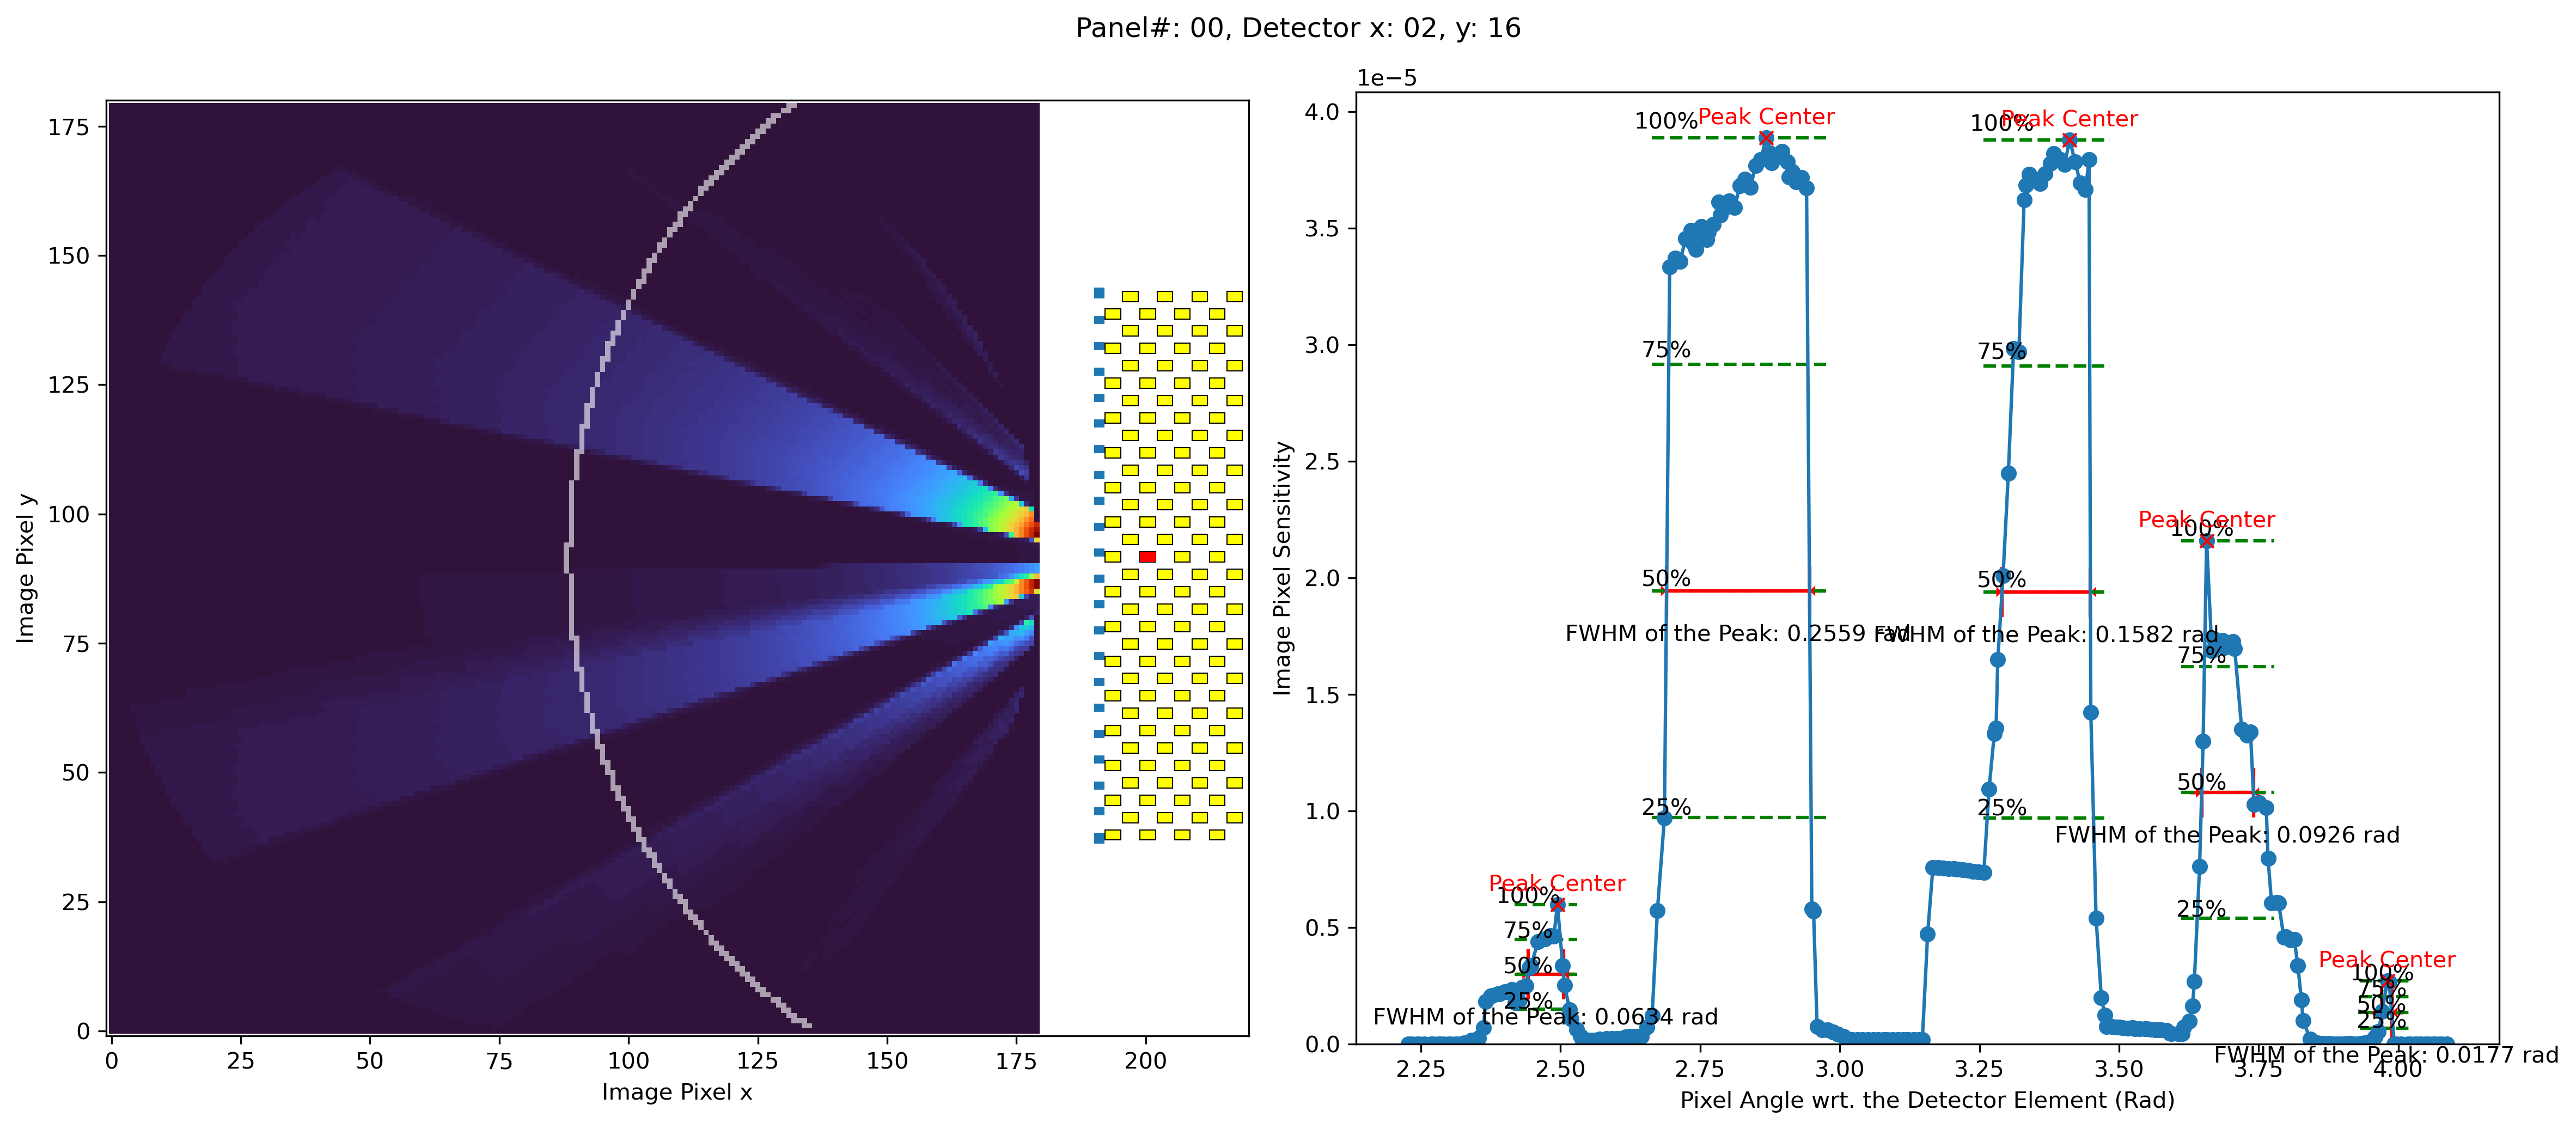

In [19]:
n_angles = 1000
arrowScale = 0.005
dIdxX,dIdxY=2,16
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
plt.rcParams["figure.figsize"] = (16,7)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(1,2)

#Draw geometry
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
ax[0].add_patch(patches.Rectangle((190,(180-107.52)*0.5),plate_thick,107.52))
for ele in np.column_stack((aperture_x, aperture_y)):
    x = ele[0]-plate_thick*0.5
    y = ele[1]-aperture_width*0.5
    ax[0].add_patch(patches.Rectangle((x, y), plate_thick, aperture_width, color='white'))
    # ax.add_patch(patches.Circle((ele[0],ele[1]), radius=0.25, color='red'))   
detIdx=0
for xlayerIdx in range(0,8):
    for ele in np.column_stack((detector_x[xlayerIdx], detector_y)):
        x = ele[0]-3.0*0.5
        y = ele[1]-2.0*0.5
        if (detIdx%2) == 0 :
            ax[0].add_patch(patches.Rectangle((x, y), 3.0, 2.0, facecolor='yellow',linewidth=0.5,edgecolor='black'))
        detIdx = detIdx + 1
    detIdx = detIdx + 1



ax[0].set_ylim(-1,180)
ax[0].set_xlim(-1,220)
ax[0].add_patch(patches.Rectangle((detector_x[dIdxX,dIdxY]-3.0*0.5,detector_y[dIdxY]-2.0*0.5),3.0,2.0,facecolor = 'red'))
radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)
print("Radius: ",radius_det)
# ax[0].add_patch(patches.Circle((detector_x[dIdxX,dIdxY],detector_y[dIdxY]),radius = radius_det,edgecolor = 'red',fill=False, linestyle=(0, (8, 8)),linewidth=0.5))
# ax.add_patch(patches.Circle((89,89),radius = 1,color='orange'))
# cbar=ax[0].colorbar(imshow_obj)
# ax.add_patch(patches.Circle((150,60), radius=0.25, color='red')) 
# fig.tight_layout()
hist_arr = []

pre_x_idx = 0
pre_y_idx = 0
thetas = []
start_angle = 0
angle_interval = 2*math.pi
end_angle = start_angle+angle_interval
for theta in np.arange(start_angle,end_angle,math.pi/n_angles):
    y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
    x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
    x_idx = math.floor(x_cord)
    y_idx = math.floor(y_cord)
    if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
        if pre_x_idx != x_idx or pre_y_idx != y_idx:
        # print(x_idx,y_idx)
            hist_arr.append(dataImage[dIdxX,0,dIdxY,y_idx,x_idx])
            thetas.append(theta)
            # dataImage[dIdxX,0,dIdxY,y_idx,x_idx]=5e-4
            ax[0].add_patch(patches.Rectangle((x_idx-0.5, y_idx-0.5), 1.0, 1.0, facecolor='w', alpha=0.6))
    pre_x_idx = x_idx
    pre_y_idx = y_idx
ax[0].set_xlabel('Image Pixel x')
ax[0].set_ylabel('Image Pixel y')   
imshow_obj=ax[0].imshow(dataImage[dIdxX,0,dIdxY,:,:], cmap=my_cmap,origin='lower')

# Right plot
signal=np.asarray(hist_arr)
thetas=np.asarray(thetas)
peaks, peak_prop = find_peaks(signal, height=0, prominence= 2e-6,distance=5)
mycurve = shapely.geometry.LineString(np.column_stack((thetas,signal)))    
    
ax[1].plot(thetas,signal,"o-")
# print(widths[0])

ax[1].plot(thetas[peaks], signal[peaks], "x",color='r')
xmin,xmax = ax[1].get_xlim()
ymin,ymax = ax[1].get_ylim()
xlen = xmax-xmin
ylen = ymax-ymin


print(peaks)
peak_idx=0
start = 0
end = len(signal)//len(peaks)
for peak_x in peaks:
    print(start,end,len(signal))
    thisPeakW = 0.5
    hline1 = shapely.geometry.LineString(np.array([[thetas[peak_x]-thisPeakW,signal[peak_x]*0.5],[thetas[peak_x]+thisPeakW,signal[peak_x]*0.5]]))
    intersection = mycurve.intersection(hline1)
    peak_idx = peak_idx + 1
    xp,yp=np.transpose(shapely.get_coordinates(intersection))
    #points on the left of the peak
    left= xp[(xp-thetas[peak_x])<0]
    #points on the right of the peak
    right=xp[(xp-thetas[peak_x])>0]
    #sort the points based on the distance
    sort_index_l = np.argsort(np.abs(left-thetas[peak_x]))
    sort_index_r = np.argsort(np.abs(right-thetas[peak_x]))
    w_p_l = left[sort_index_l[0]]
    w_p_r = right[sort_index_r[0]]
    height = signal[peak_x]*0.5
    height_100 = signal[peak_x]
    height_75 = signal[peak_x]*0.75
    height_50 = signal[peak_x]*0.5
    height_25 = signal[peak_x]*0.25
    
    ax[1].arrow(w_p_l-2*arrowScale*xlen,height, arrowScale*xlen, 0, head_length=arrowScale*xlen, width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].arrow(w_p_r+2*arrowScale*xlen,height, -arrowScale*xlen, 0, head_length=arrowScale*xlen,width=0.7*arrowScale*ylen, fc='r',linewidth=0)
    ax[1].vlines(w_p_l,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    ax[1].vlines(w_p_r,height-5*arrowScale*ylen,height+5*arrowScale*ylen,ec='r')
    
    #Plot horizontal line at different intensity level
    ax[1].hlines(height_100,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    ax[1].hlines(height_75,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    ax[1].hlines(height_50,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    ax[1].hlines(height_25,w_p_l*0.99,w_p_r*1.01,ec='g',linestyle='--',)
    
    ax[1].text(w_p_l, height_100*1.01,'100%',ha="center")
    ax[1].text(w_p_l, height_75*1.01,'75%',ha="center")
    ax[1].text(w_p_l, height_50*1.01,'50%',ha="center")
    ax[1].text(w_p_l, height_25*1.01,'25%',ha="center")
    
    #Get the intersection points of above lines with the PPDF curve
    pt_25_left, pt_25_right = get_intersection_point_25p_line(signal)
    pt_75_left, pt_75_right = get_intersection_point_75p_line(signal)
    start = end
    end = min(end*2,len(signal)-1)
    
    #Plot vertical line at the intersection of above lines with the PPDF curve.
#     ax[1].vlines(pt_25_left[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].vlines(pt_25_right[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].vlines(pt_75_left[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].vlines(pt_75_right[0],ymin,ymax,ec='y',linestyle='-',)
#     ax[1].text(pt_25_left[0], ylen*0.95,'{:.4f}'.format(pt_75_left[0]-pt_25_left[0]),ha="left")
#     ax[1].text(pt_75_right[0], ylen*0.95,'{:.4f}'.format(pt_25_right[0]-pt_75_right[0]),ha="left")
    
    ax[1].hlines(height,w_p_l,w_p_r,ec='r')
    ax[1].text((w_p_r+w_p_l)*0.5, height-ylen*0.05,'FWHM of the Peak: {:.4f} rad'.format(w_p_r-w_p_l),ha="center")
    ax[1].text(thetas[peak_x], signal[peak_x]+ylen*0.02,'Peak Center',ha="center", va="center",color='r')
ax[1].set_xlabel('Pixel Angle wrt. the Detector Element (Rad)')
ax[1].set_ylabel('Image Pixel Sensitivity')
ax[1].set_ylim(0)
pltTitle=fig.suptitle('Panel#: {:02d}, Detector x: {:02d}, y: {:02d}'.format(0, dIdxX, dIdxY))
# ax[0].text(125,182, 'Projection Line',color='orange')
plt.tight_layout()
fig.savefig("ppdf_line/p{:02d}_dx{:02d}_dy{:02d}_{:.2f}_{:.2f}.png".format(0,dIdxX,dIdxY,start_angle,end_angle))

In [20]:

def find_fwhm(dIdxX,dIdxY):
    n_angles = 1000
    arrowScale = 0.005

    radius_det = math.sqrt((detector_x[dIdxX,dIdxY]-89)**2 + (detector_y[dIdxY]-89)**2)

    hist_arr = []
    pre_x_idx = 0
    pre_y_idx = 0
    thetas = []
    start_angle = 0
    angle_interval = 2*math.pi
    end_angle = start_angle+angle_interval
    for theta in np.arange(start_angle,end_angle,math.pi/n_angles):
        y_cord = radius_det*math.sin(theta) + detector_y[dIdxY]
        x_cord = radius_det*math.cos(theta) + detector_x[dIdxX,dIdxY]
        x_idx = math.floor(x_cord)
        y_idx = math.floor(y_cord)
        if x_idx > 0 and x_idx < 180 and y_idx > 0 and y_idx < 180:
            if pre_x_idx != x_idx or pre_y_idx != y_idx:
                hist_arr.append(dataImage[dIdxX,0,dIdxY,y_idx,x_idx])
                thetas.append(theta)
        pre_x_idx = x_idx
        pre_y_idx = y_idx


    # Right plot
    signal=np.asarray(hist_arr)
    thetas=np.asarray(thetas)
    peaks, peak_prop = find_peaks(signal, height=0, prominence= 2e-6,distance=5)
    mycurve = shapely.geometry.LineString(np.column_stack((thetas,signal)))    



    fwhm = []
    peak_idx=0
    for peak_x in peaks:
        thisPeakW = 0.5
        hline1 = shapely.geometry.LineString(np.array([[thetas[peak_x]-thisPeakW,signal[peak_x]*0.5],[thetas[peak_x]+thisPeakW,signal[peak_x]*0.5]]))
        intersection = mycurve.intersection(hline1)
        peak_idx = peak_idx + 1
        xp,yp=np.transpose(shapely.get_coordinates(intersection))
        #points on the left of the peak
        left= xp[(xp-thetas[peak_x])<0]
        #points on the right of the peak
        right=xp[(xp-thetas[peak_x])>0]
        #sort the points based on the distance
        sort_index_l = np.argsort(np.abs(left-thetas[peak_x]))
        sort_index_r = np.argsort(np.abs(right-thetas[peak_x]))
        
        try:
            w_p_l = left[sort_index_l[0]]
            w_p_r = right[sort_index_r[0]]
        except Exception as e:
            continue

        fwhm.append(w_p_r-w_p_l)
    
    return fwhm


In [21]:
fwhm_aggregate = []
for x in range(NDetX_):
    dIdxX=x
    for y in range(NDetY_):
        dIdxY=y
        if (dIdxX%2==0 and dIdxY%2!=0) or (dIdxX%2!=0 and dIdxY%2==0):
            continue
        print(dIdxX,dIdxY)
        fwhm = find_fwhm(dIdxX,dIdxY)
        fwhm_aggregate.append(sum(fwhm))

0 0
0 2
0 4
0 6
0 8
0 10
0 12
0 14
0 16
0 18
0 20
0 22
0 24
0 26
0 28
0 30
1 1
1 3
1 5
1 7
1 9
1 11
1 13
1 15
1 17
1 19
1 21
1 23
1 25
1 27
1 29
1 31
2 0
2 2
2 4
2 6
2 8
2 10
2 12
2 14
2 16
2 18
2 20
2 22
2 24
2 26
2 28
2 30
3 1
3 3
3 5
3 7
3 9
3 11
3 13
3 15
3 17
3 19
3 21
3 23
3 25
3 27
3 29
3 31
4 0
4 2
4 4
4 6
4 8
4 10
4 12
4 14
4 16
4 18
4 20
4 22
4 24
4 26
4 28
4 30
5 1
5 3
5 5
5 7
5 9
5 11
5 13
5 15
5 17
5 19
5 21
5 23
5 25
5 27
5 29
5 31
6 0
6 2
6 4
6 6
6 8
6 10
6 12
6 14
6 16
6 18
6 20
6 22
6 24
6 26
6 28
6 30
7 1
7 3
7 5
7 7
7 9
7 11
7 13
7 15
7 17
7 19
7 21
7 23
7 25
7 27
7 29
7 31


In [22]:
print(fwhm_aggregate)

[0.03912374563106957, 0.10497995560533457, 0.2901056119620353, 0.022605049723287918, 0.10101542010851672, 0.3091351556522559, 0.1519068024205632, 0.02452158237329982, 0.2298007404086948, 0.29745418955729397, 0.0273658858968151, 0.065599173408311, 0.29407089046671553, 1.0219013935450096, 0.041121474350522824, 0.2848103821777639, 0.2951039413695369, 0.7262875679983551, 0.8950462441316782, 0.7230917207922114, 0.9569594304915894, 1.0261839886687634, 0.7789424660817215, 0.9300092970901845, 1.0324889831810928, 0.9506138278551983, 0.7427783294676469, 1.0004819073476838, 1.0139277618523348, 0.7191711684088977, 0.8747310798915606, 0.7445301384055987, 0.39655102073990633, 0.31615729243875457, 0.5114123408487958, 0.6428559189915055, 0.7881660410704852, 0.6247723962075011, 0.6854917592810894, 0.8241968941716138, 0.5877758560374322, 0.5742290215503592, 0.7346081441850694, 0.6240034913293115, 0.545921423113668, 0.339052416001969, 0.39317056908072123, 0.49297478974369513, 0.23568010745599022, 0.34517

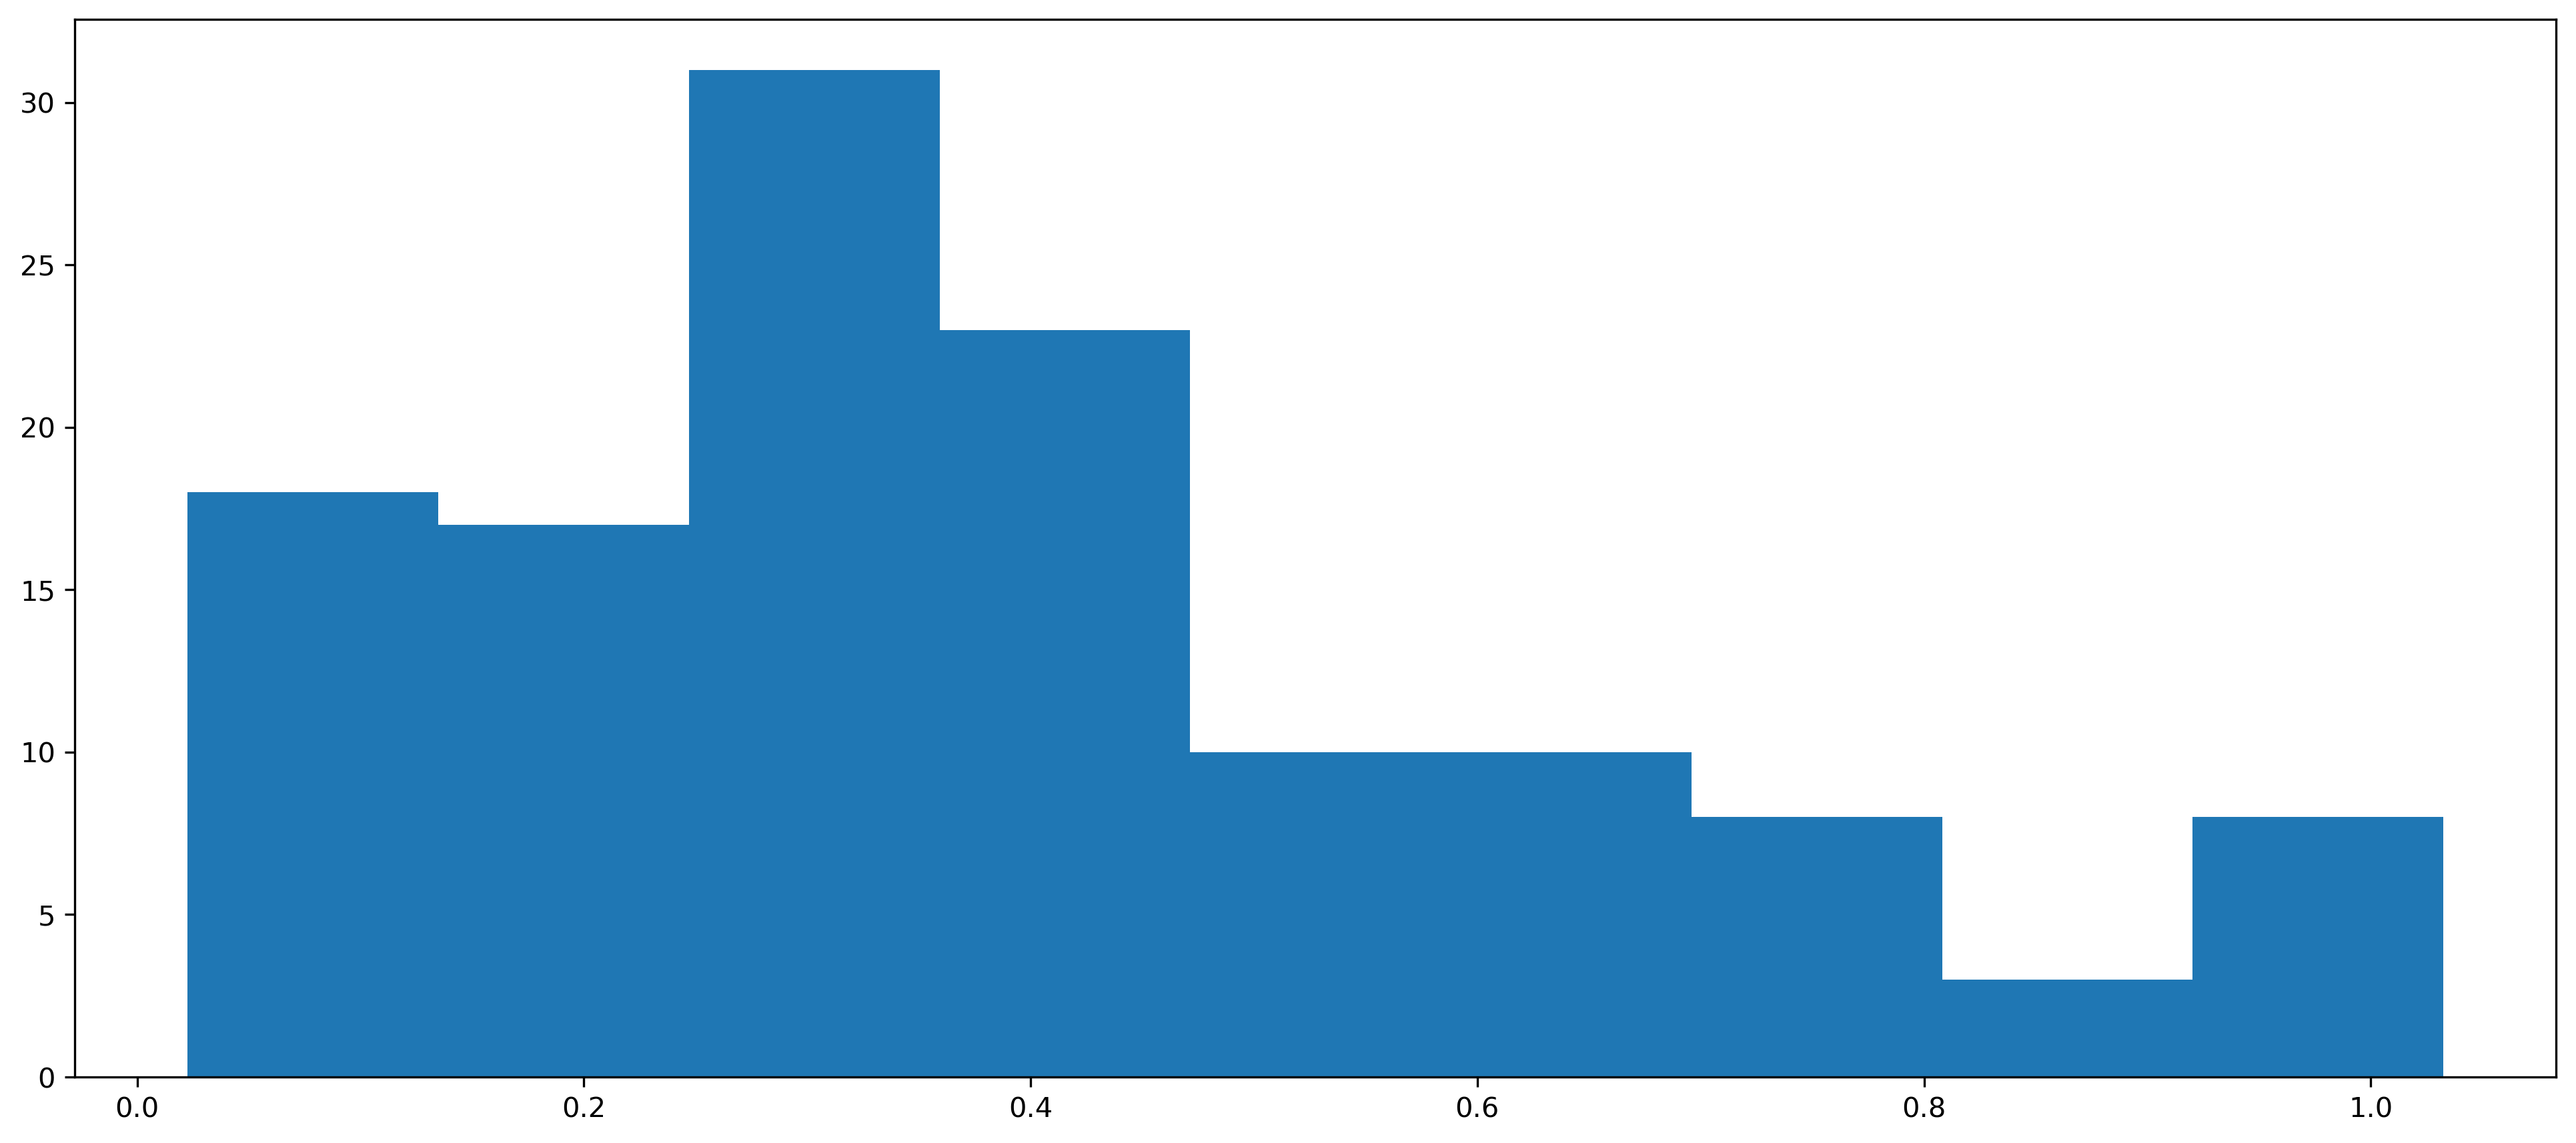

In [23]:
import numpy as np
import matplotlib.pyplot as plt

_=plt.hist(fwhm_aggregate, bins='auto')
plt.show()

0 0
0 2
0 4
0 6
0 8
0 10
0 12
0 14
0 16
0 18
0 20
0 22
0 24
0 26
0 28
0 30
1 1
1 3
1 5
1 7
1 9
1 11
1 13
1 15
1 17
1 19
1 21
1 23
1 25
1 27
1 29
1 31
2 0
2 2
2 4
2 6
2 8
2 10
2 12
2 14
2 16
2 18
2 20
2 22
2 24
2 26
2 28
2 30
3 1
3 3
3 5
3 7
3 9
3 11
3 13
3 15
3 17
3 19
3 21
3 23
3 25
3 27
3 29
3 31
4 0
4 2
4 4
4 6
4 8
4 10
4 12
4 14
4 16
4 18
4 20
4 22
4 24
4 26
4 28
4 30
5 1
5 3
5 5
5 7
5 9
5 11
5 13
5 15
5 17
5 19
5 21
5 23
5 25
5 27
5 29
5 31
6 0
6 2
6 4
6 6
6 8
6 10
6 12
6 14
6 16
6 18
6 20
6 22
6 24
6 26
6 28
6 30
7 1
7 3
7 5
7 7
7 9
7 11
7 13
7 15
7 17
7 19
7 21
7 23
7 25
7 27
7 29
7 31
[0.03912374563106957, 0.10497995560533457, 0.2901056119620353, 0.022605049723287918, 0.10101542010851672, 0.3091351556522559, 0.1519068024205632, 0.02452158237329982, 0.2298007404086948, 0.29745418955729397, 0.0273658858968151, 0.065599173408311, 0.29407089046671553, 0.5109506967725048, 0.041121474350522824, 0.14240519108888194, 0.0983679804565123, 0.18157189199958879, 0.22376156103291955, 0.24103

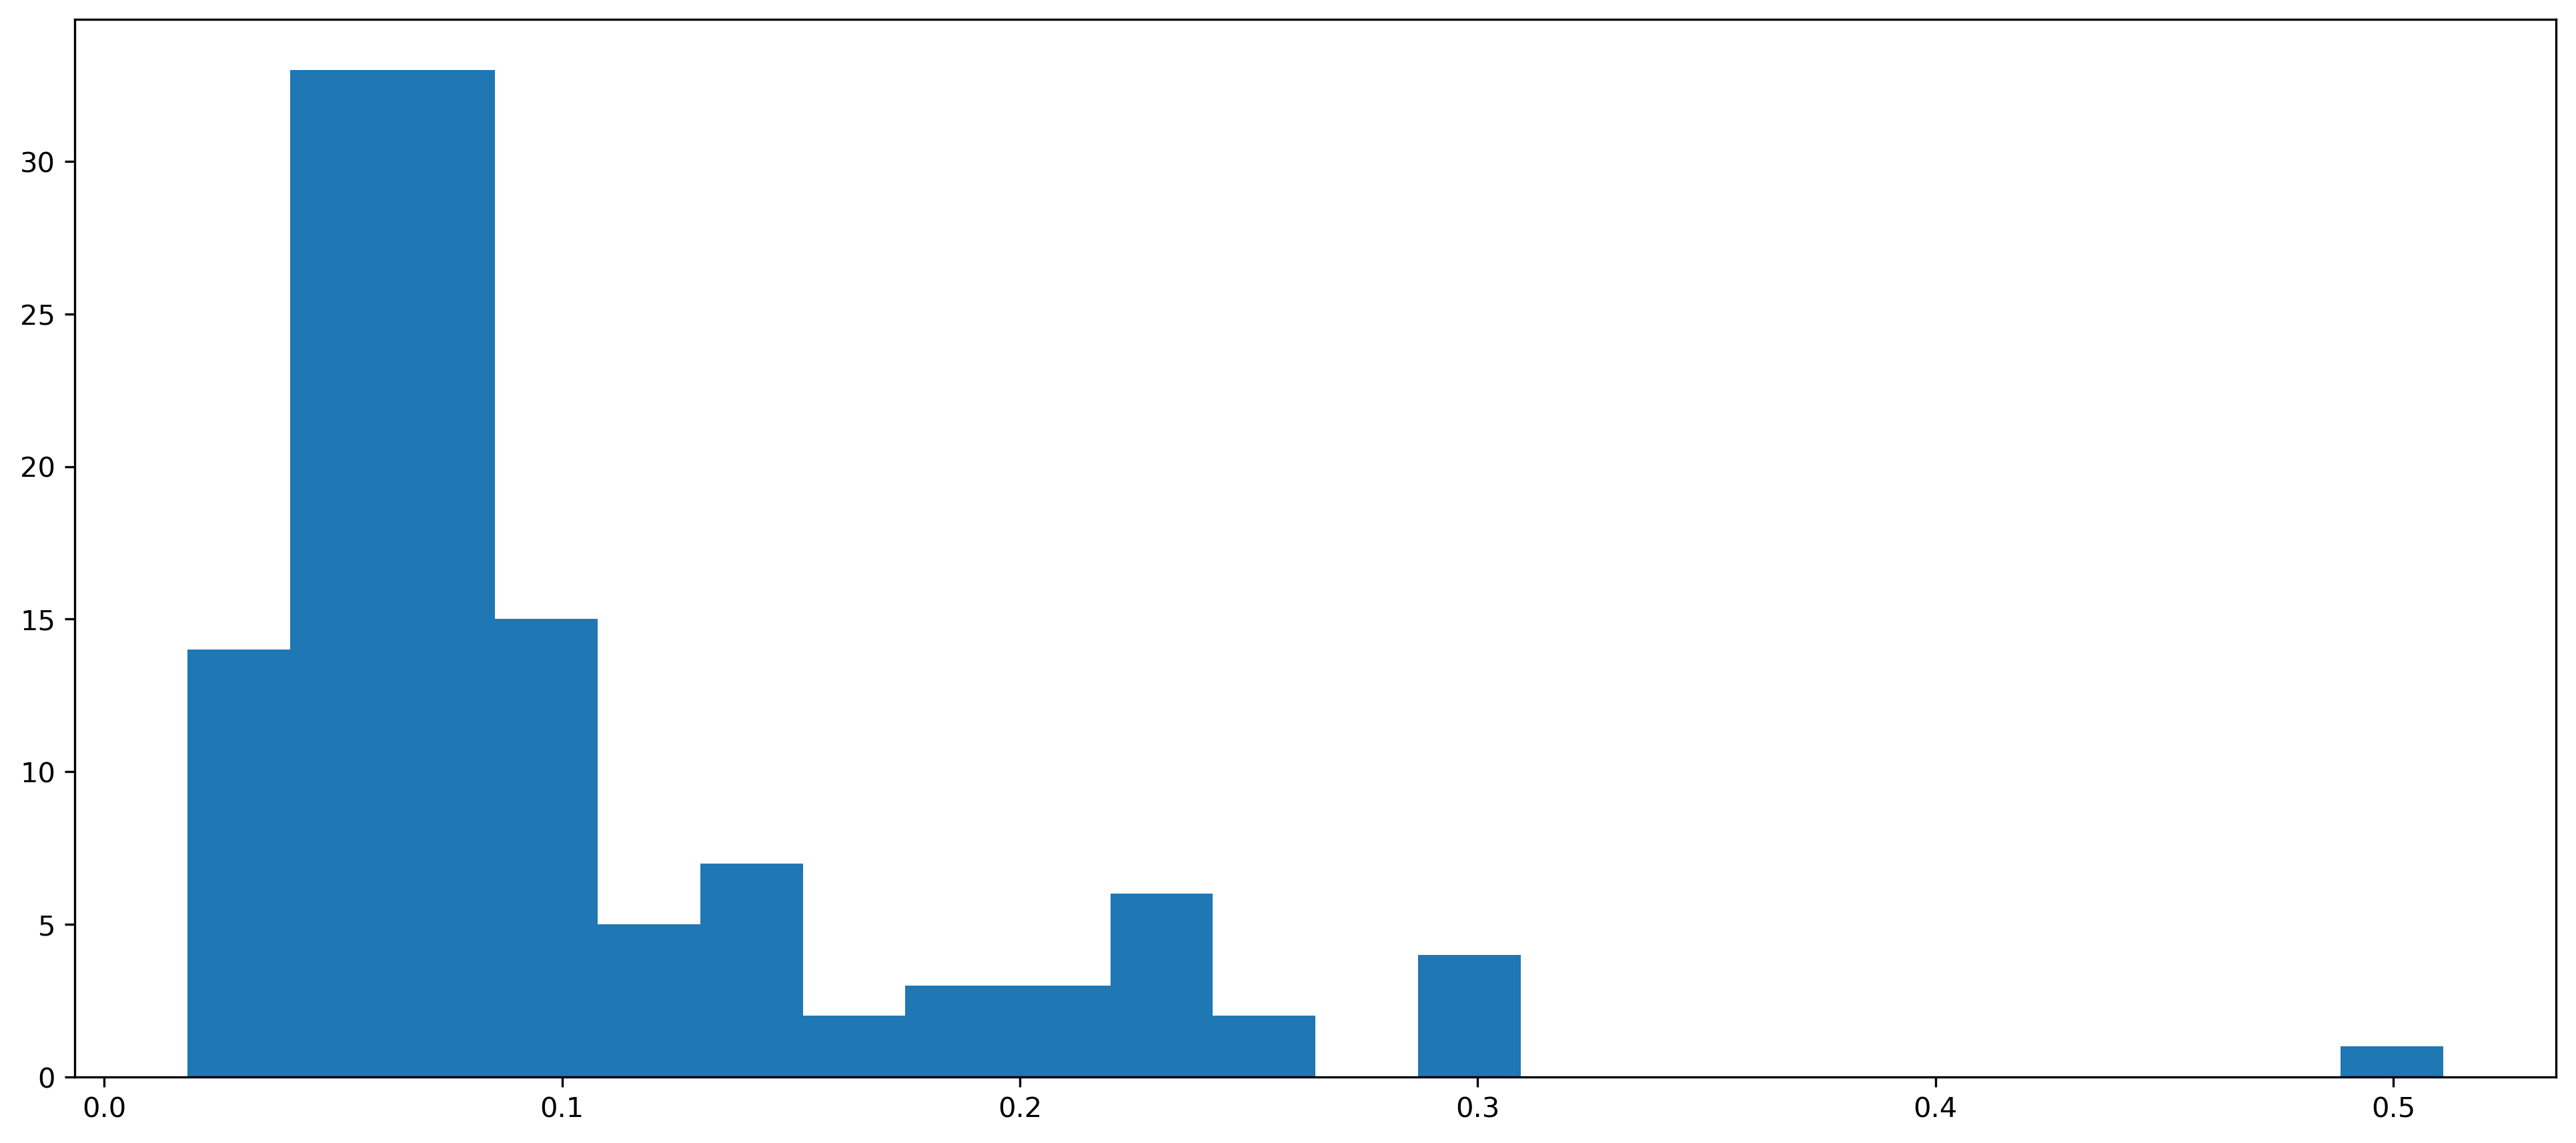

In [24]:
fwhm_aggregate = []
for x in range(8):
    dIdxX=x
    for y in range(32):
        dIdxY=y
        if (dIdxX%2==0 and dIdxY%2!=0) or (dIdxX%2!=0 and dIdxY%2==0):
            continue
        print(dIdxX,dIdxY)
        fwhm = find_fwhm(dIdxX,dIdxY)
#         print(fwhm)
        fwhm_aggregate.append(sum(fwhm)/len(fwhm))
        
import numpy as np
import matplotlib.pyplot as plt
print(fwhm_aggregate)
_=plt.hist(fwhm_aggregate, bins='auto')
plt.show()

0 0
0 2
0 4
0 6
0 8
0 10
0 12
0 14
0 16
0 18
0 20
0 22
0 24
0 26
0 28
0 30
1 1
1 3
1 5
1 7
1 9
1 11
1 13
1 15
1 17
1 19
1 21
1 23
1 25
1 27
1 29
1 31
2 0
2 2
2 4
2 6
2 8
2 10
2 12
2 14
2 16
2 18
2 20
2 22
2 24
2 26
2 28
2 30
3 1
3 3
3 5
3 7
3 9
3 11
3 13
3 15
3 17
3 19
3 21
3 23
3 25
3 27
3 29
3 31
4 0
4 2
4 4
4 6
4 8
4 10
4 12
4 14
4 16
4 18
4 20
4 22
4 24
4 26
4 28
4 30
5 1
5 3
5 5
5 7
5 9
5 11
5 13
5 15
5 17
5 19
5 21
5 23
5 25
5 27
5 29
5 31
6 0
6 2
6 4
6 6
6 8
6 10
6 12
6 14
6 16
6 18
6 20
6 22
6 24
6 26
6 28
6 30
7 1
7 3
7 5
7 7
7 9
7 11
7 13
7 15
7 17
7 19
7 21
7 23
7 25
7 27
7 29
7 31
[0.03912374563106957, 0.10497995560533457, 0.2901056119620353, 0.022605049723287918, 0.10101542010851672, 0.3091351556522559, 0.1519068024205632, 0.02452158237329982, 0.2298007404086948, 0.29745418955729397, 0.0273658858968151, 0.065599173408311, 0.29407089046671553, 1.0219013935450096, 0.041121474350522824, 0.2848103821777639, 0.26368946420598993, 0.5398132993920677, 0.6918062494341592, 0.6227554

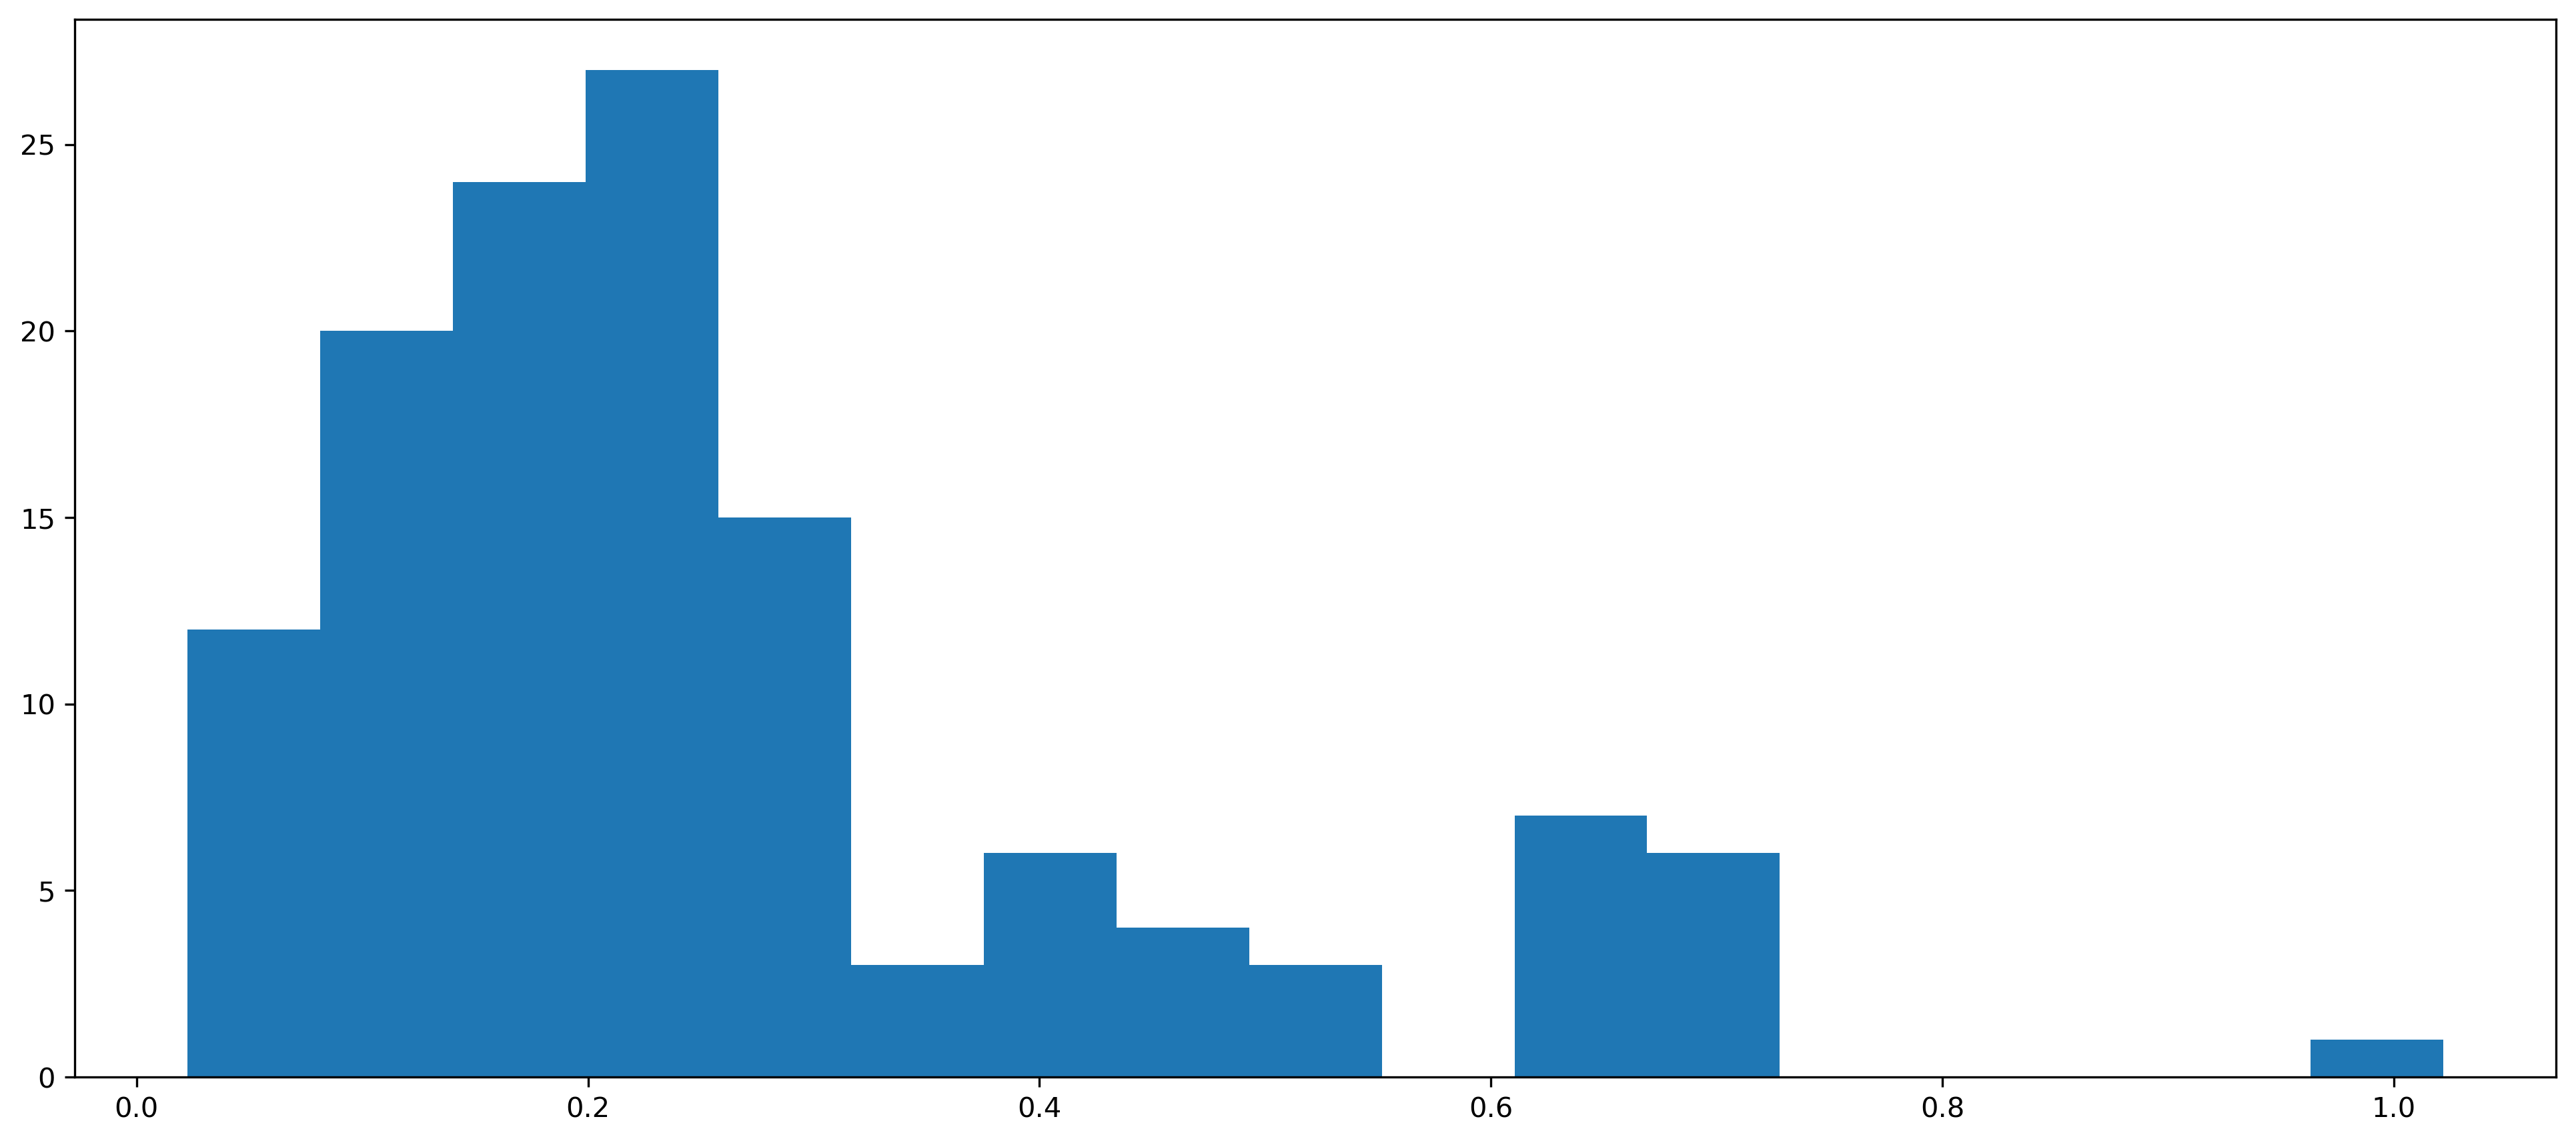

In [25]:
fwhm_aggregate = []
for x in range(8):
    dIdxX=x
    for y in range(32):
        dIdxY=y
        if (dIdxX%2==0 and dIdxY%2!=0) or (dIdxX%2!=0 and dIdxY%2==0):
            continue
        print(dIdxX,dIdxY)
        fwhm = find_fwhm(dIdxX,dIdxY)
#         print(fwhm)
        fwhm.sort(reverse=True)
        fwhm_aggregate.append(sum(fwhm[0:2]))
        
import numpy as np
import matplotlib.pyplot as plt
print(fwhm_aggregate)
_=plt.hist(fwhm_aggregate, bins='auto')
plt.show()

In [26]:
fwhm_aggregate = {}
for x in range(NDetX_):
    dIdxX=x
    fwhm_aggregate[x] = []
    for y in range(NDetY_):
        dIdxY=y
        if (dIdxX%2==0 and dIdxY%2!=0) or (dIdxX%2!=0 and dIdxY%2==0):
            continue
        print(dIdxX,dIdxY)
        fwhm = find_fwhm(dIdxX,dIdxY)
        fwhm_aggregate[x].append(sum(fwhm))

0 0
0 2
0 4
0 6
0 8
0 10
0 12
0 14
0 16
0 18
0 20
0 22
0 24
0 26
0 28
0 30
1 1
1 3
1 5
1 7
1 9
1 11
1 13
1 15
1 17
1 19
1 21
1 23
1 25
1 27
1 29
1 31
2 0
2 2
2 4
2 6
2 8
2 10
2 12
2 14
2 16
2 18
2 20
2 22
2 24
2 26
2 28
2 30
3 1
3 3
3 5
3 7
3 9
3 11
3 13
3 15
3 17
3 19
3 21
3 23
3 25
3 27
3 29
3 31
4 0
4 2
4 4
4 6
4 8
4 10
4 12
4 14
4 16
4 18
4 20
4 22
4 24
4 26
4 28
4 30
5 1
5 3
5 5
5 7
5 9
5 11
5 13
5 15
5 17
5 19
5 21
5 23
5 25
5 27
5 29
5 31
6 0
6 2
6 4
6 6
6 8
6 10
6 12
6 14
6 16
6 18
6 20
6 22
6 24
6 26
6 28
6 30
7 1
7 3
7 5
7 7
7 9
7 11
7 13
7 15
7 17
7 19
7 21
7 23
7 25
7 27
7 29
7 31


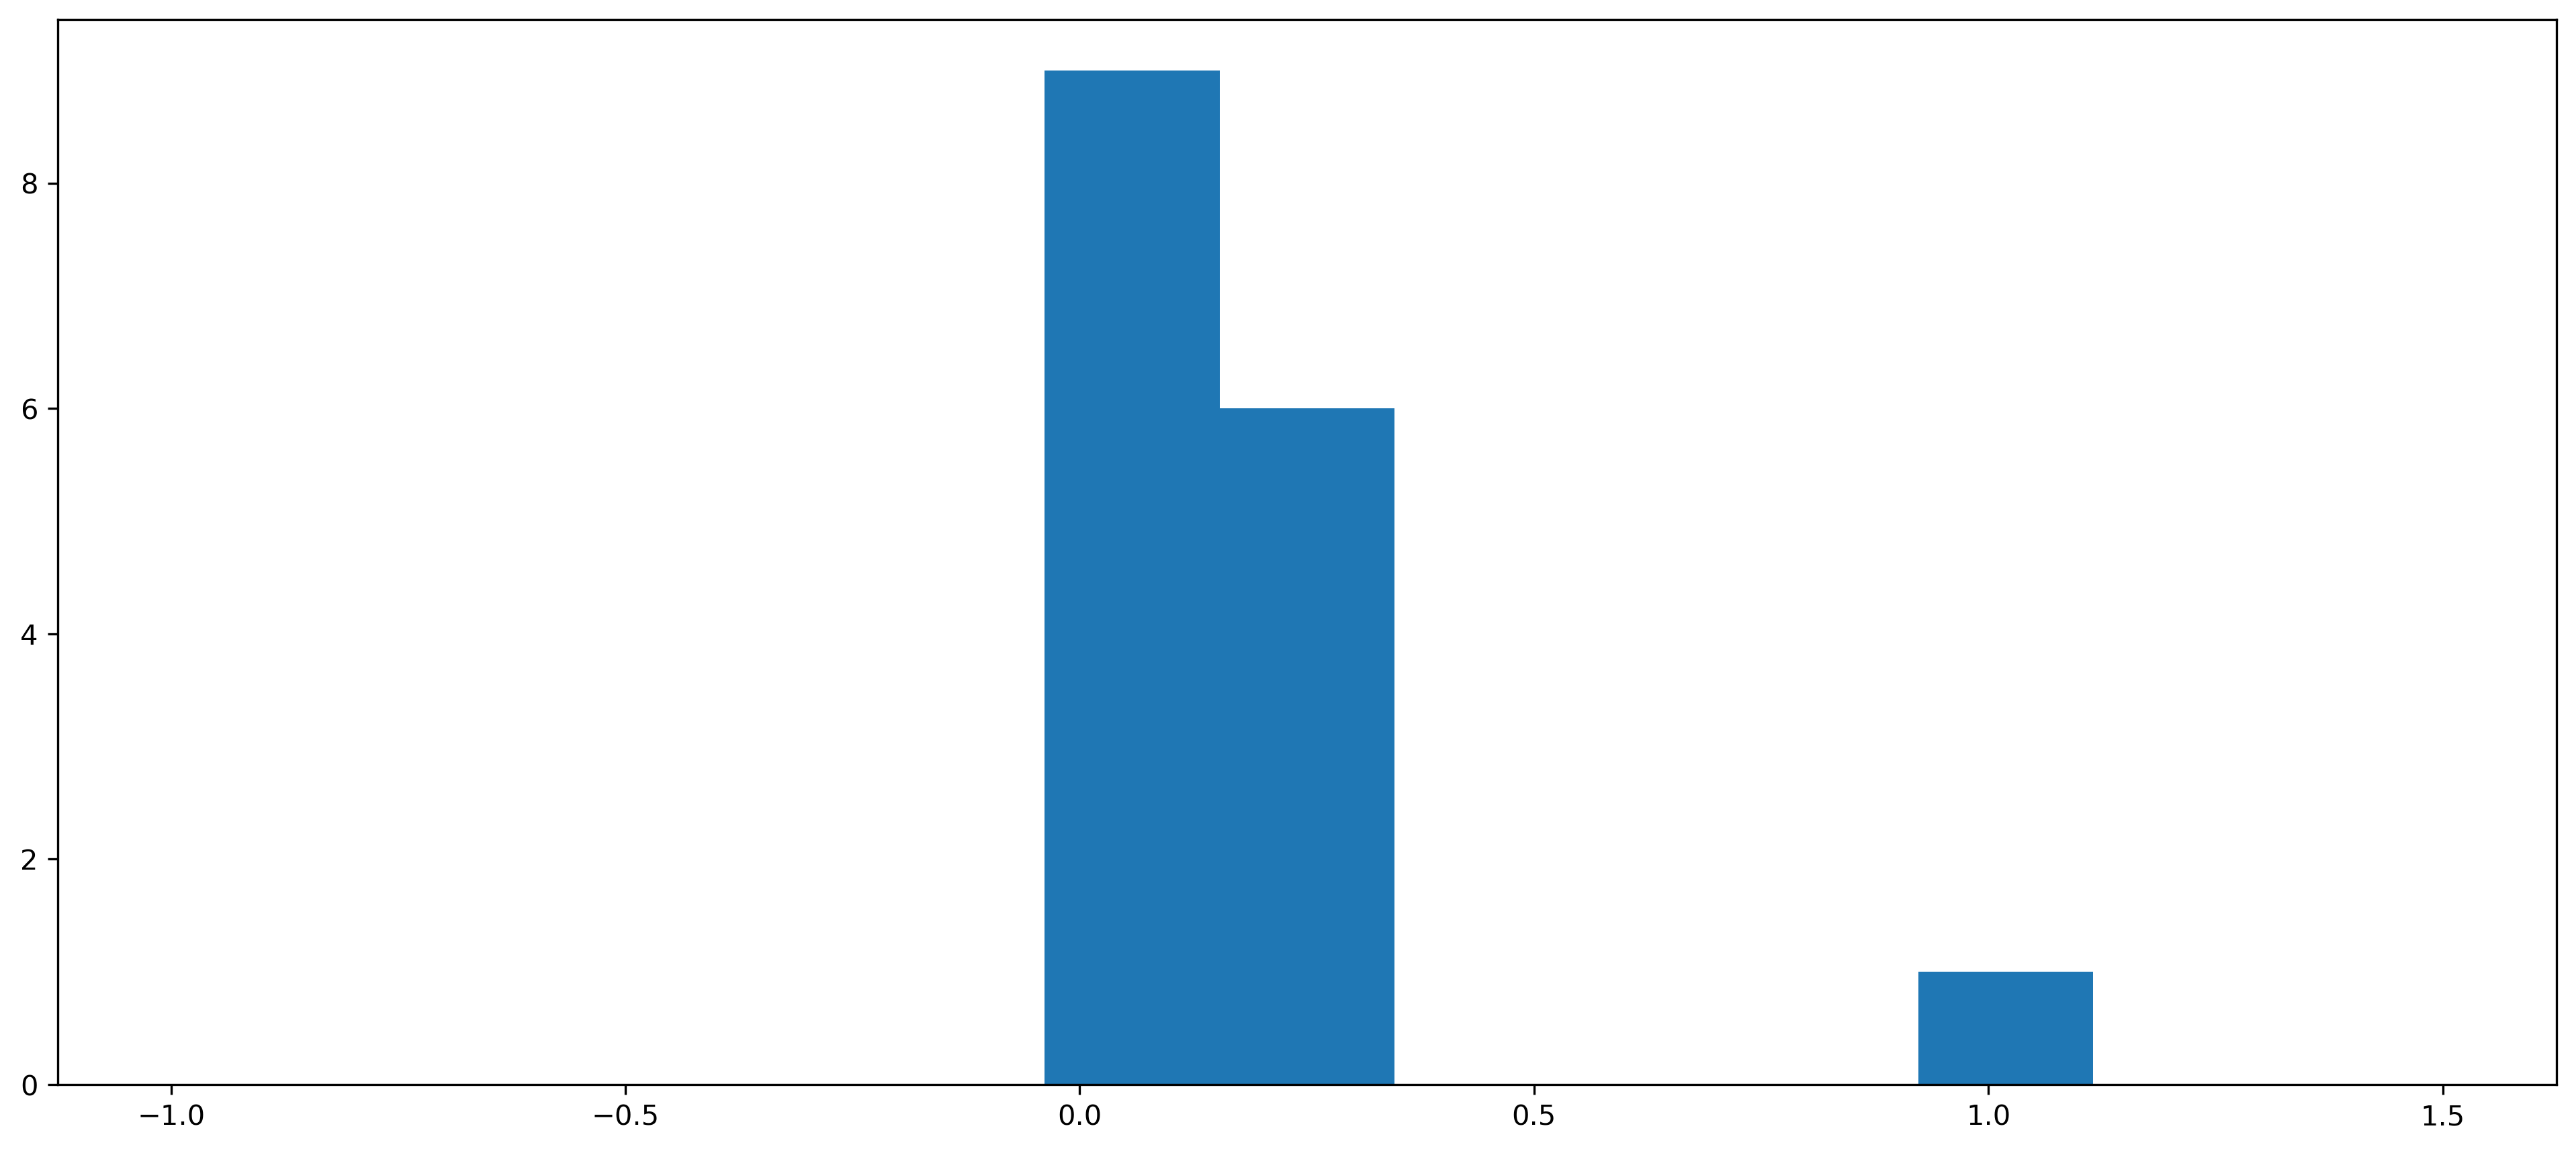

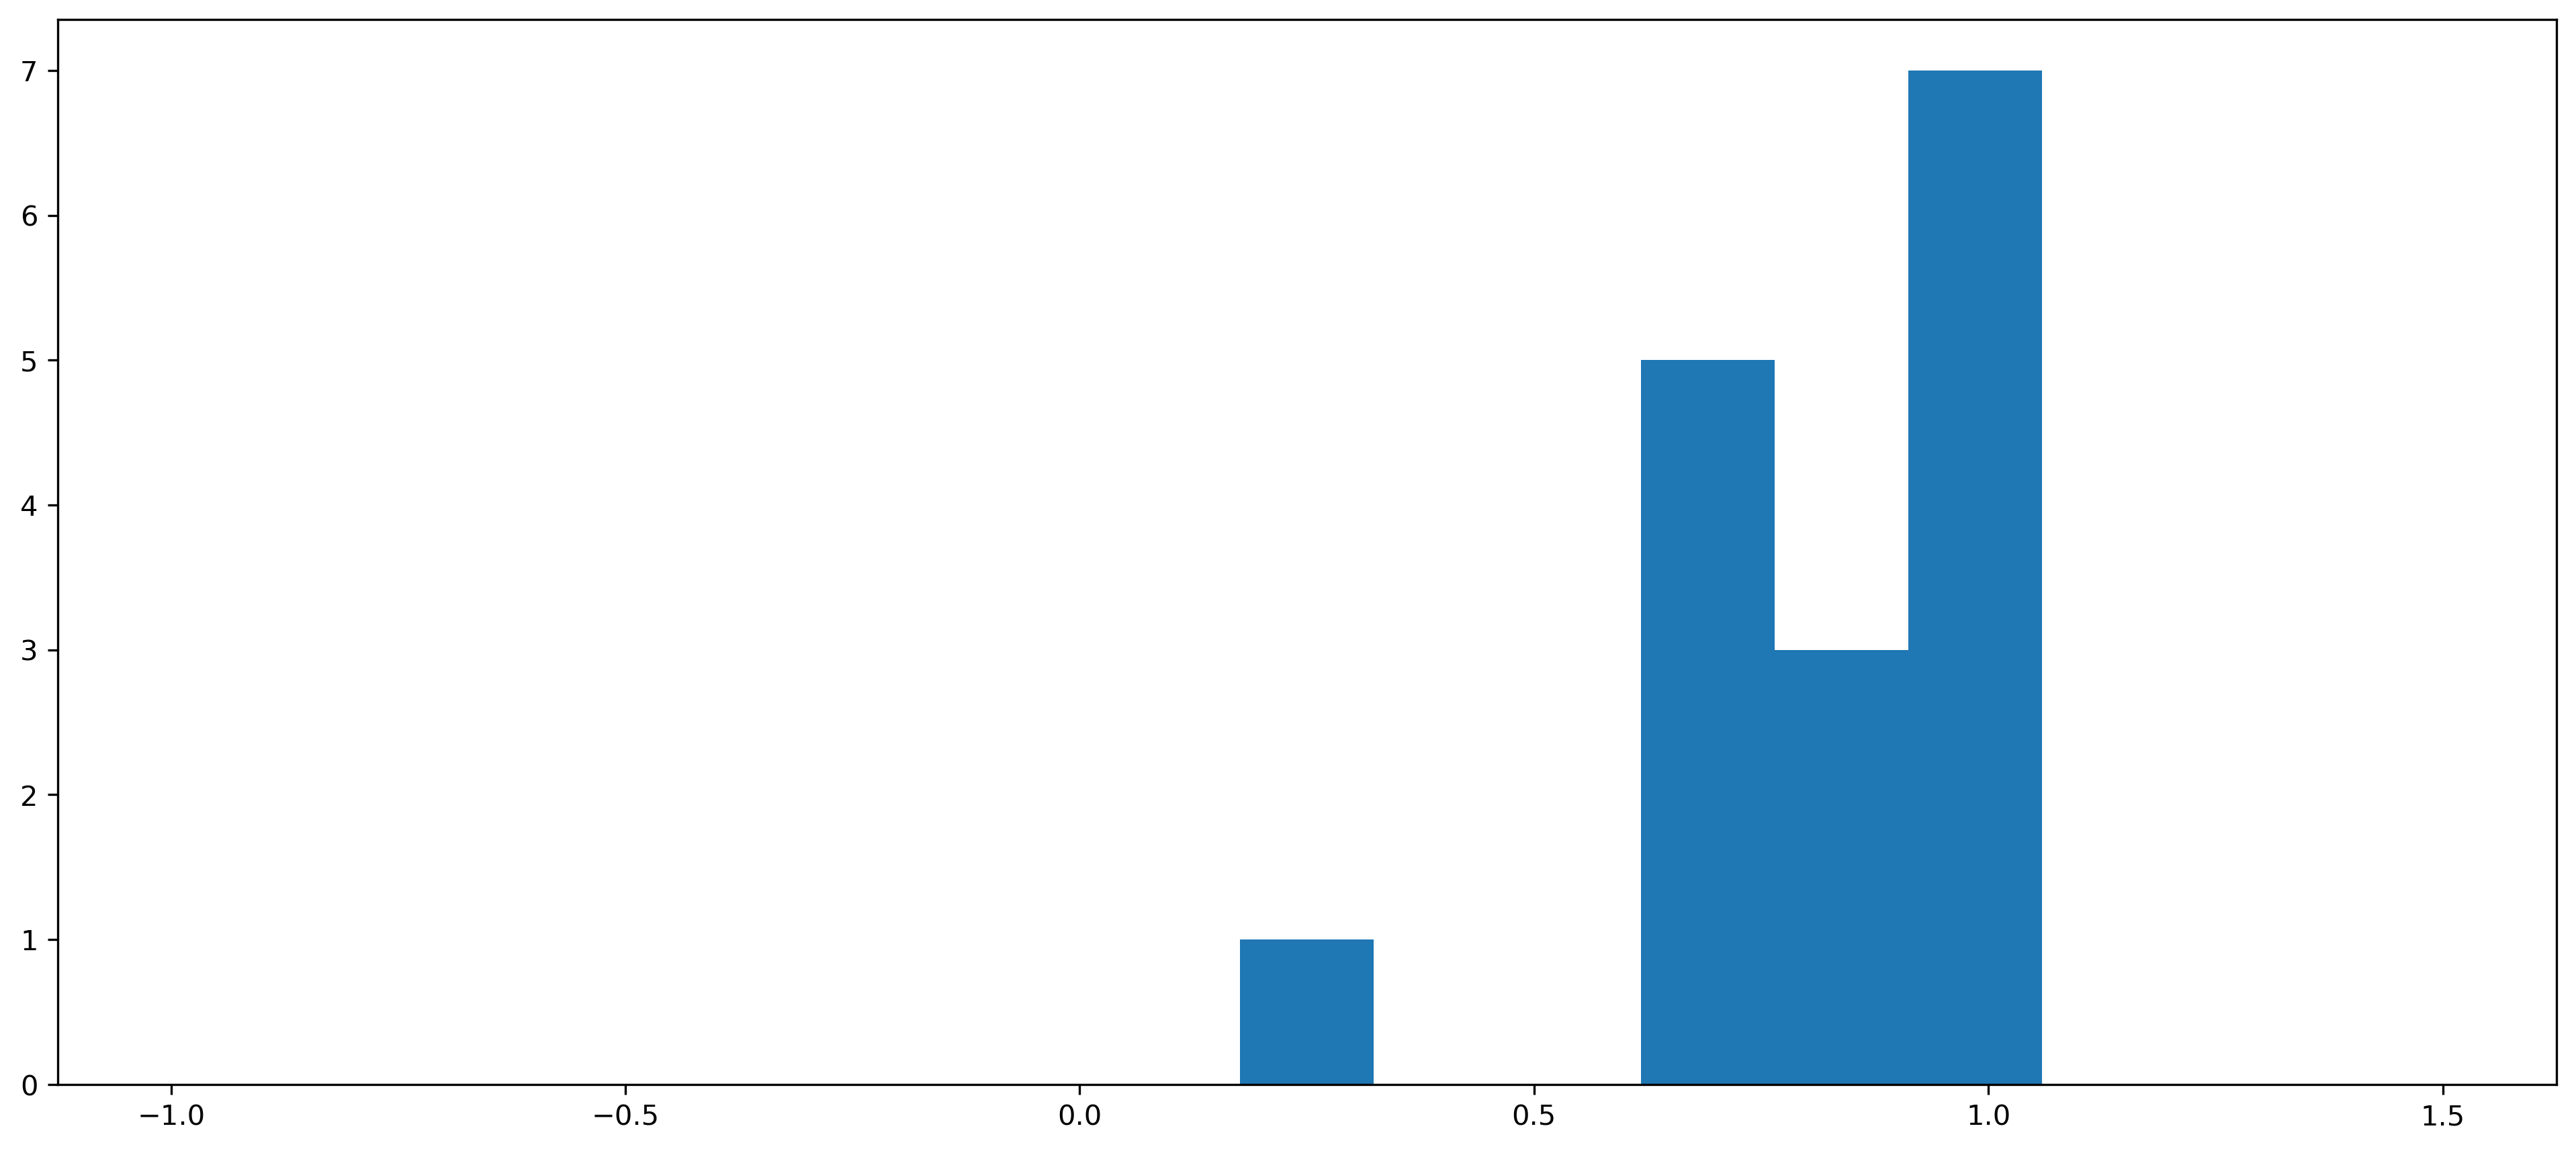

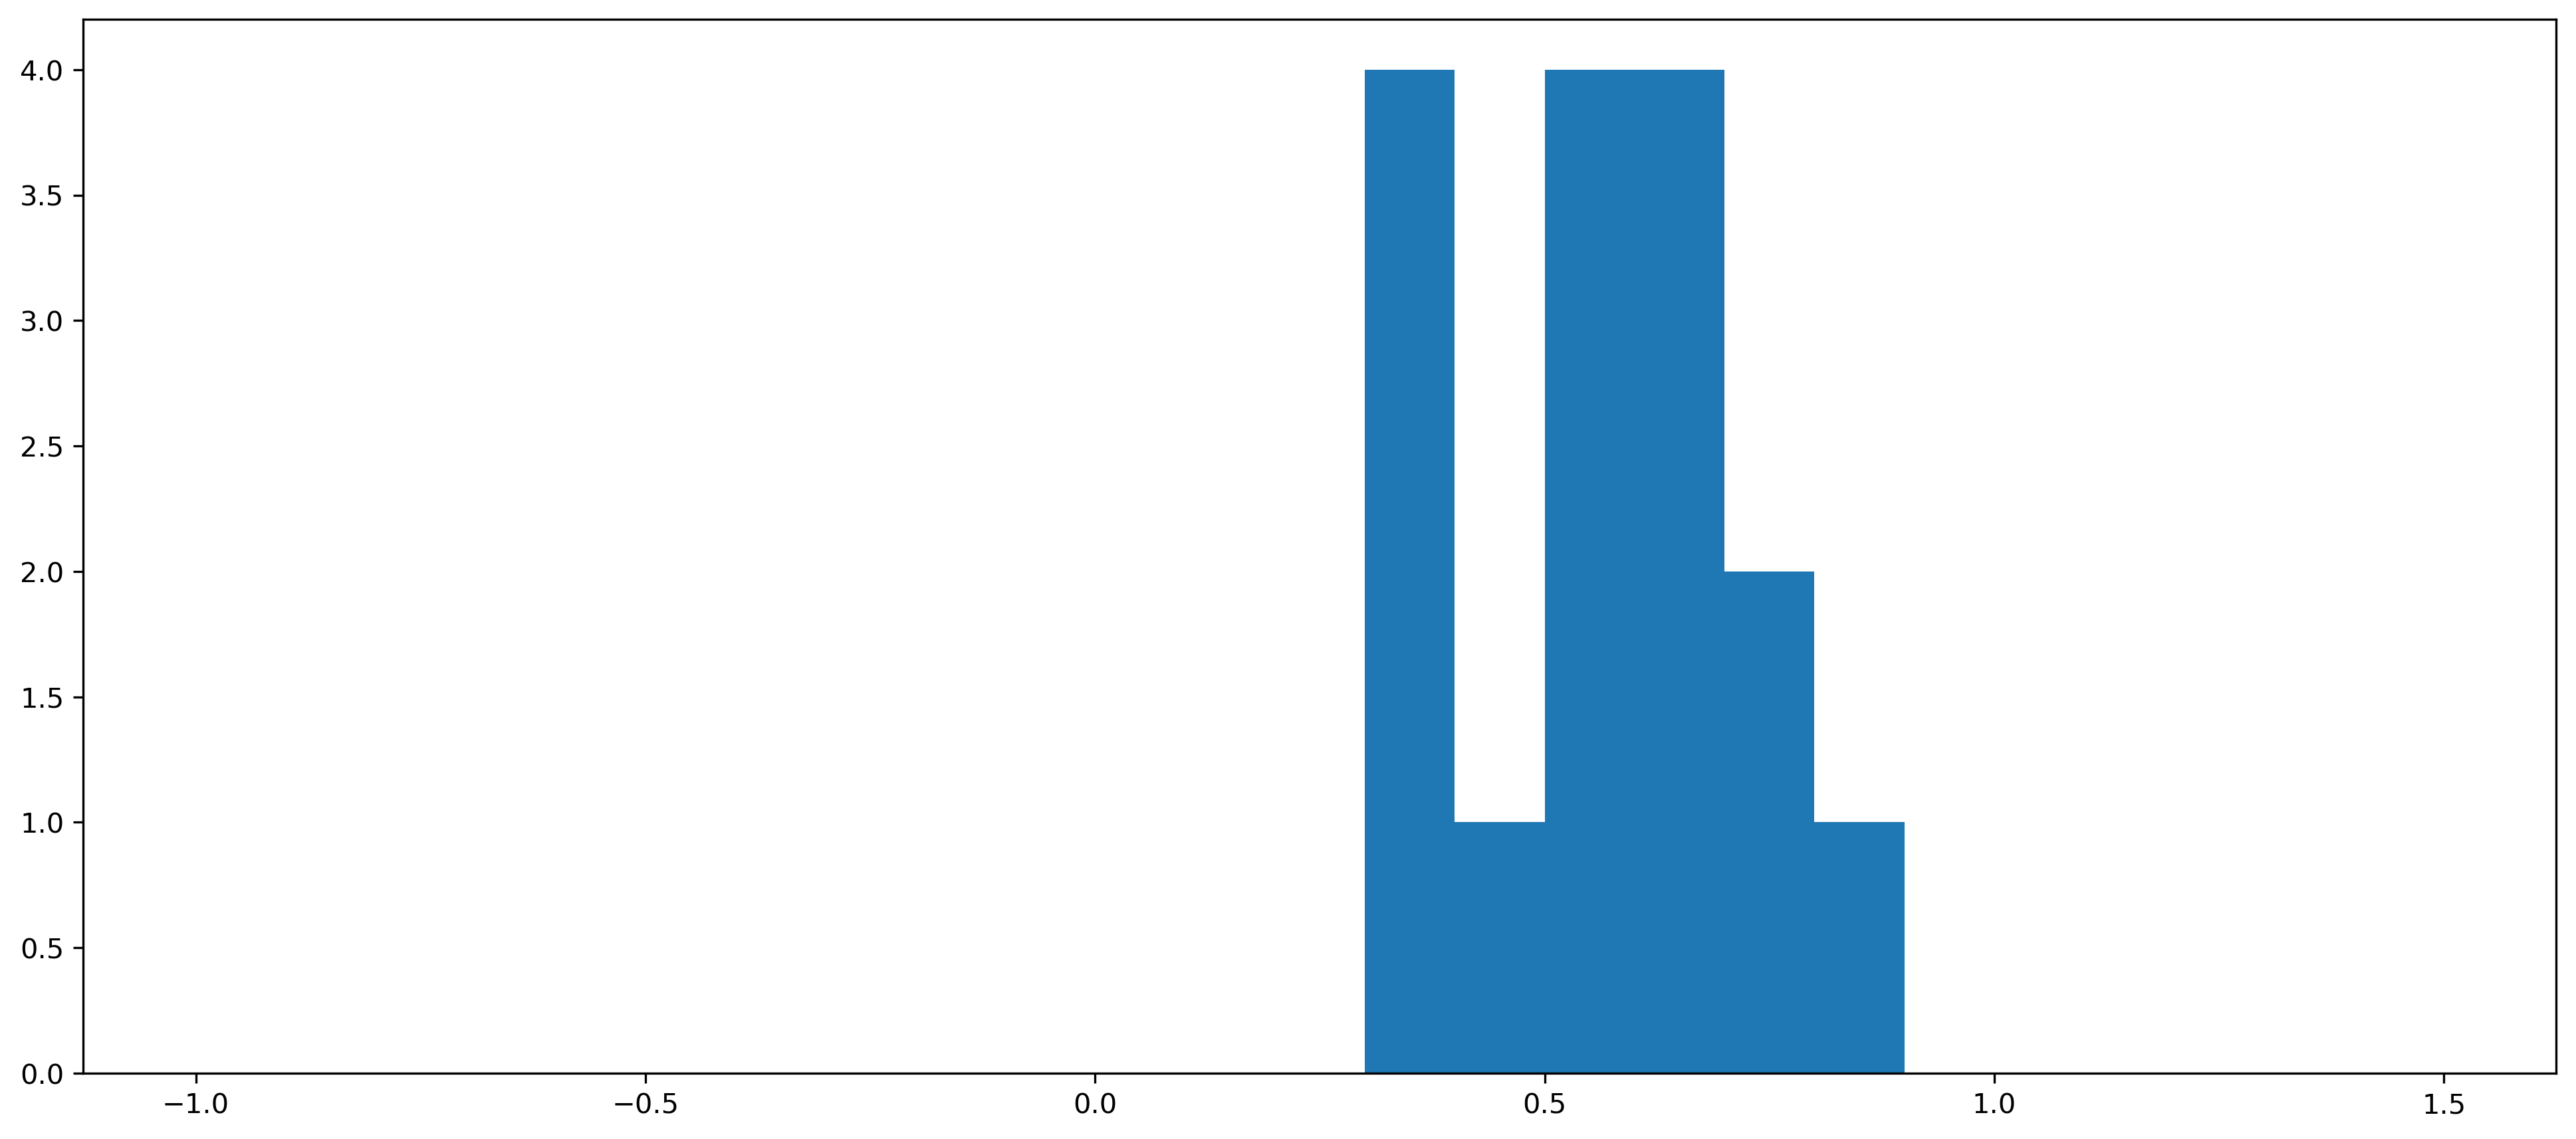

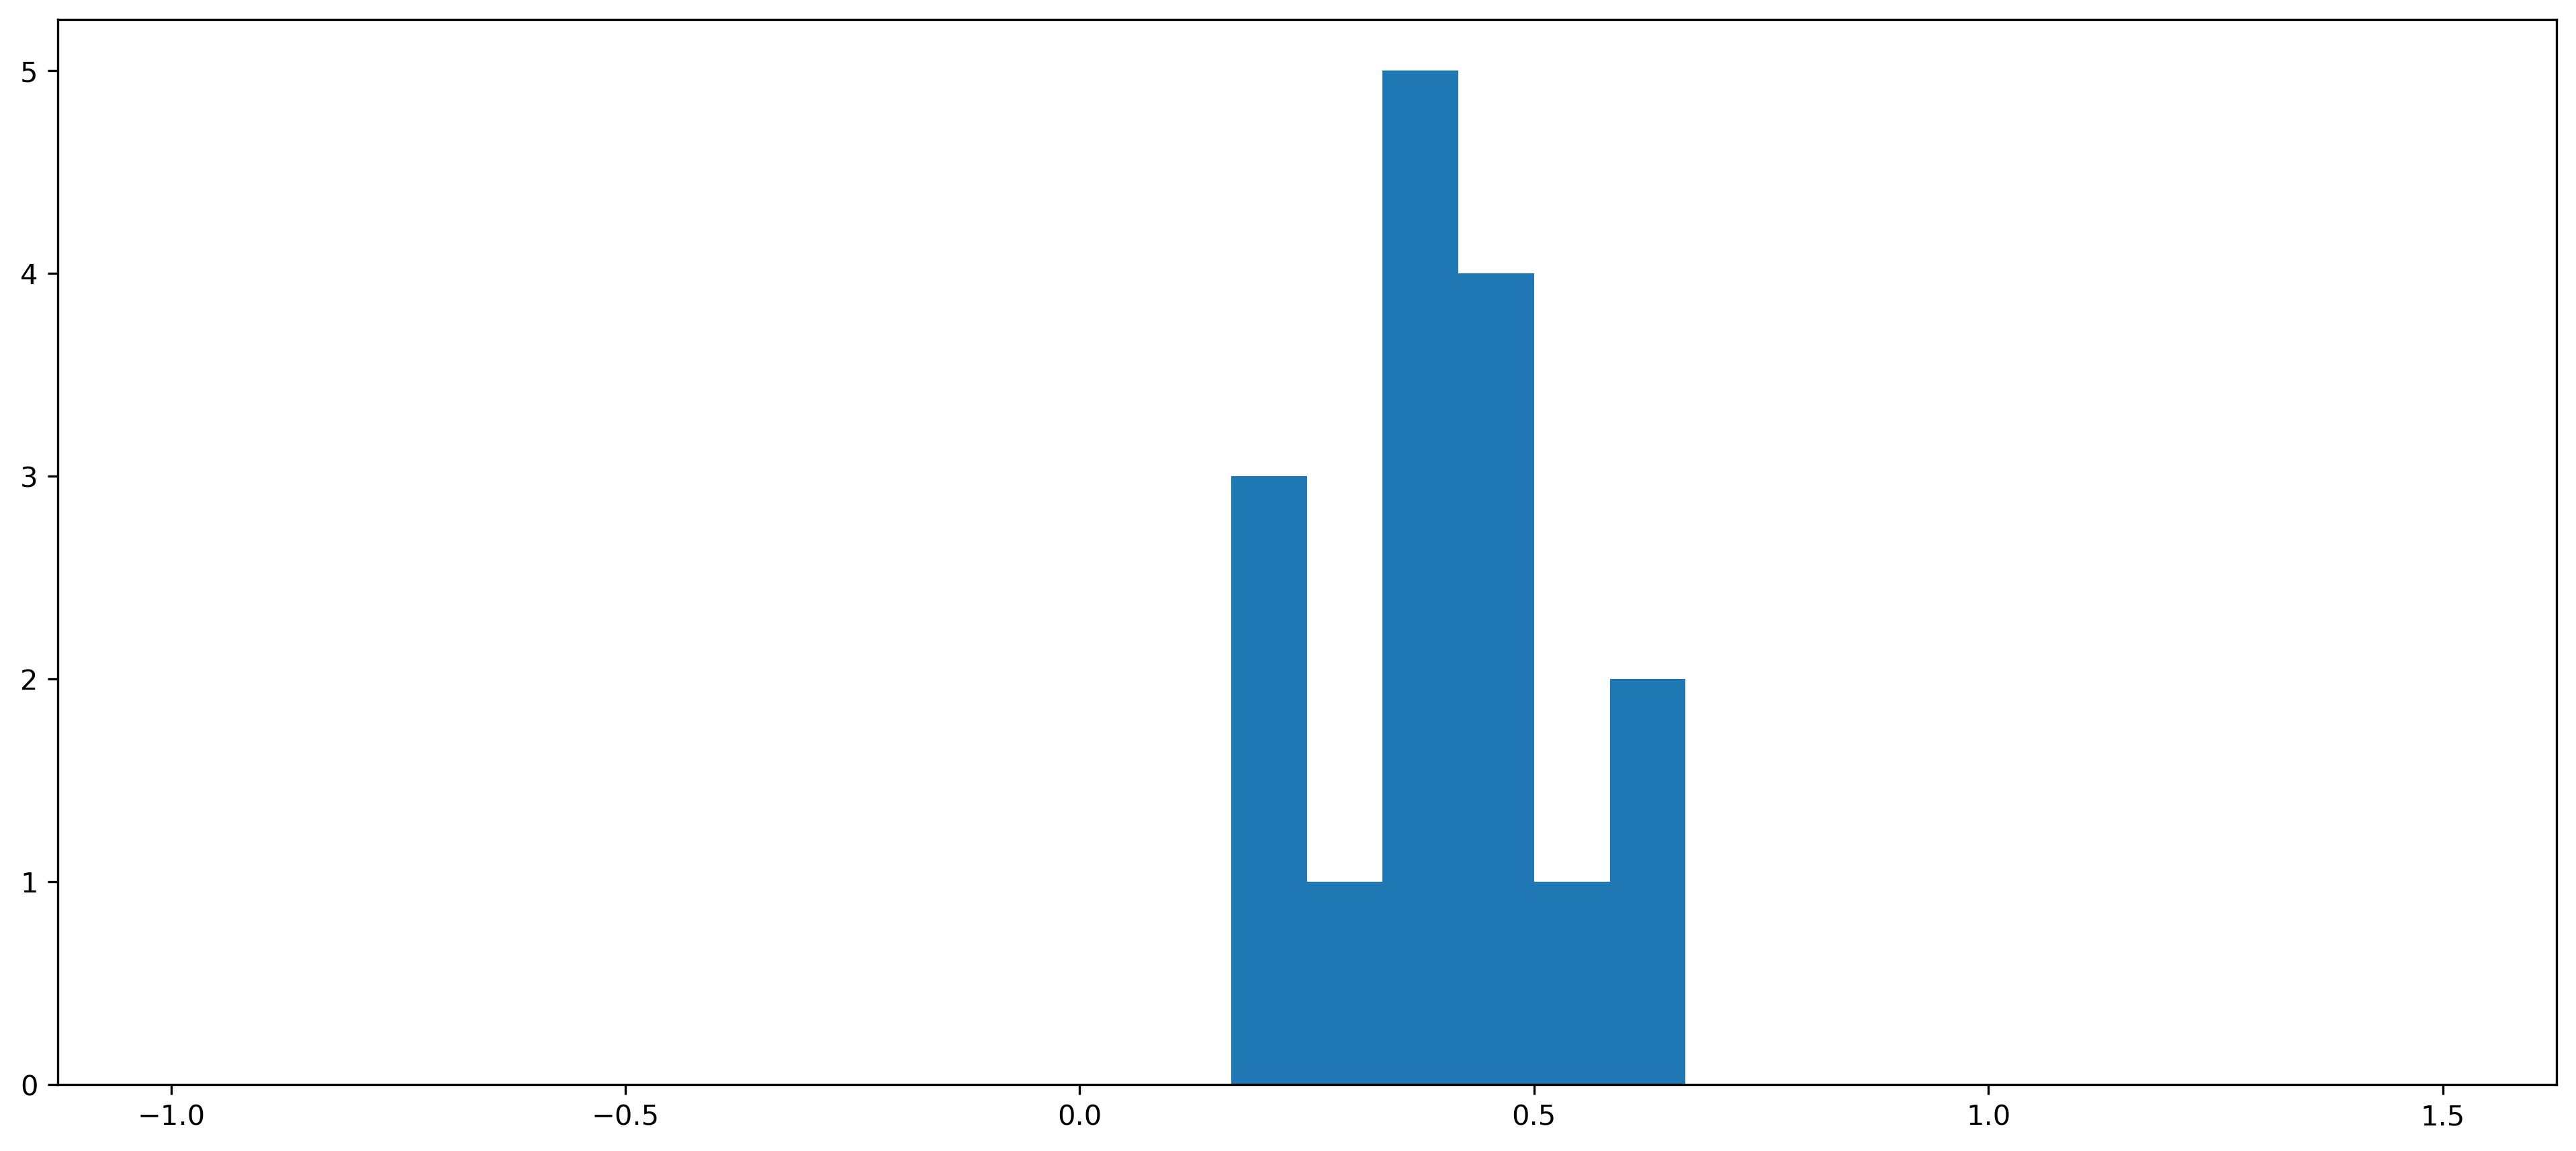

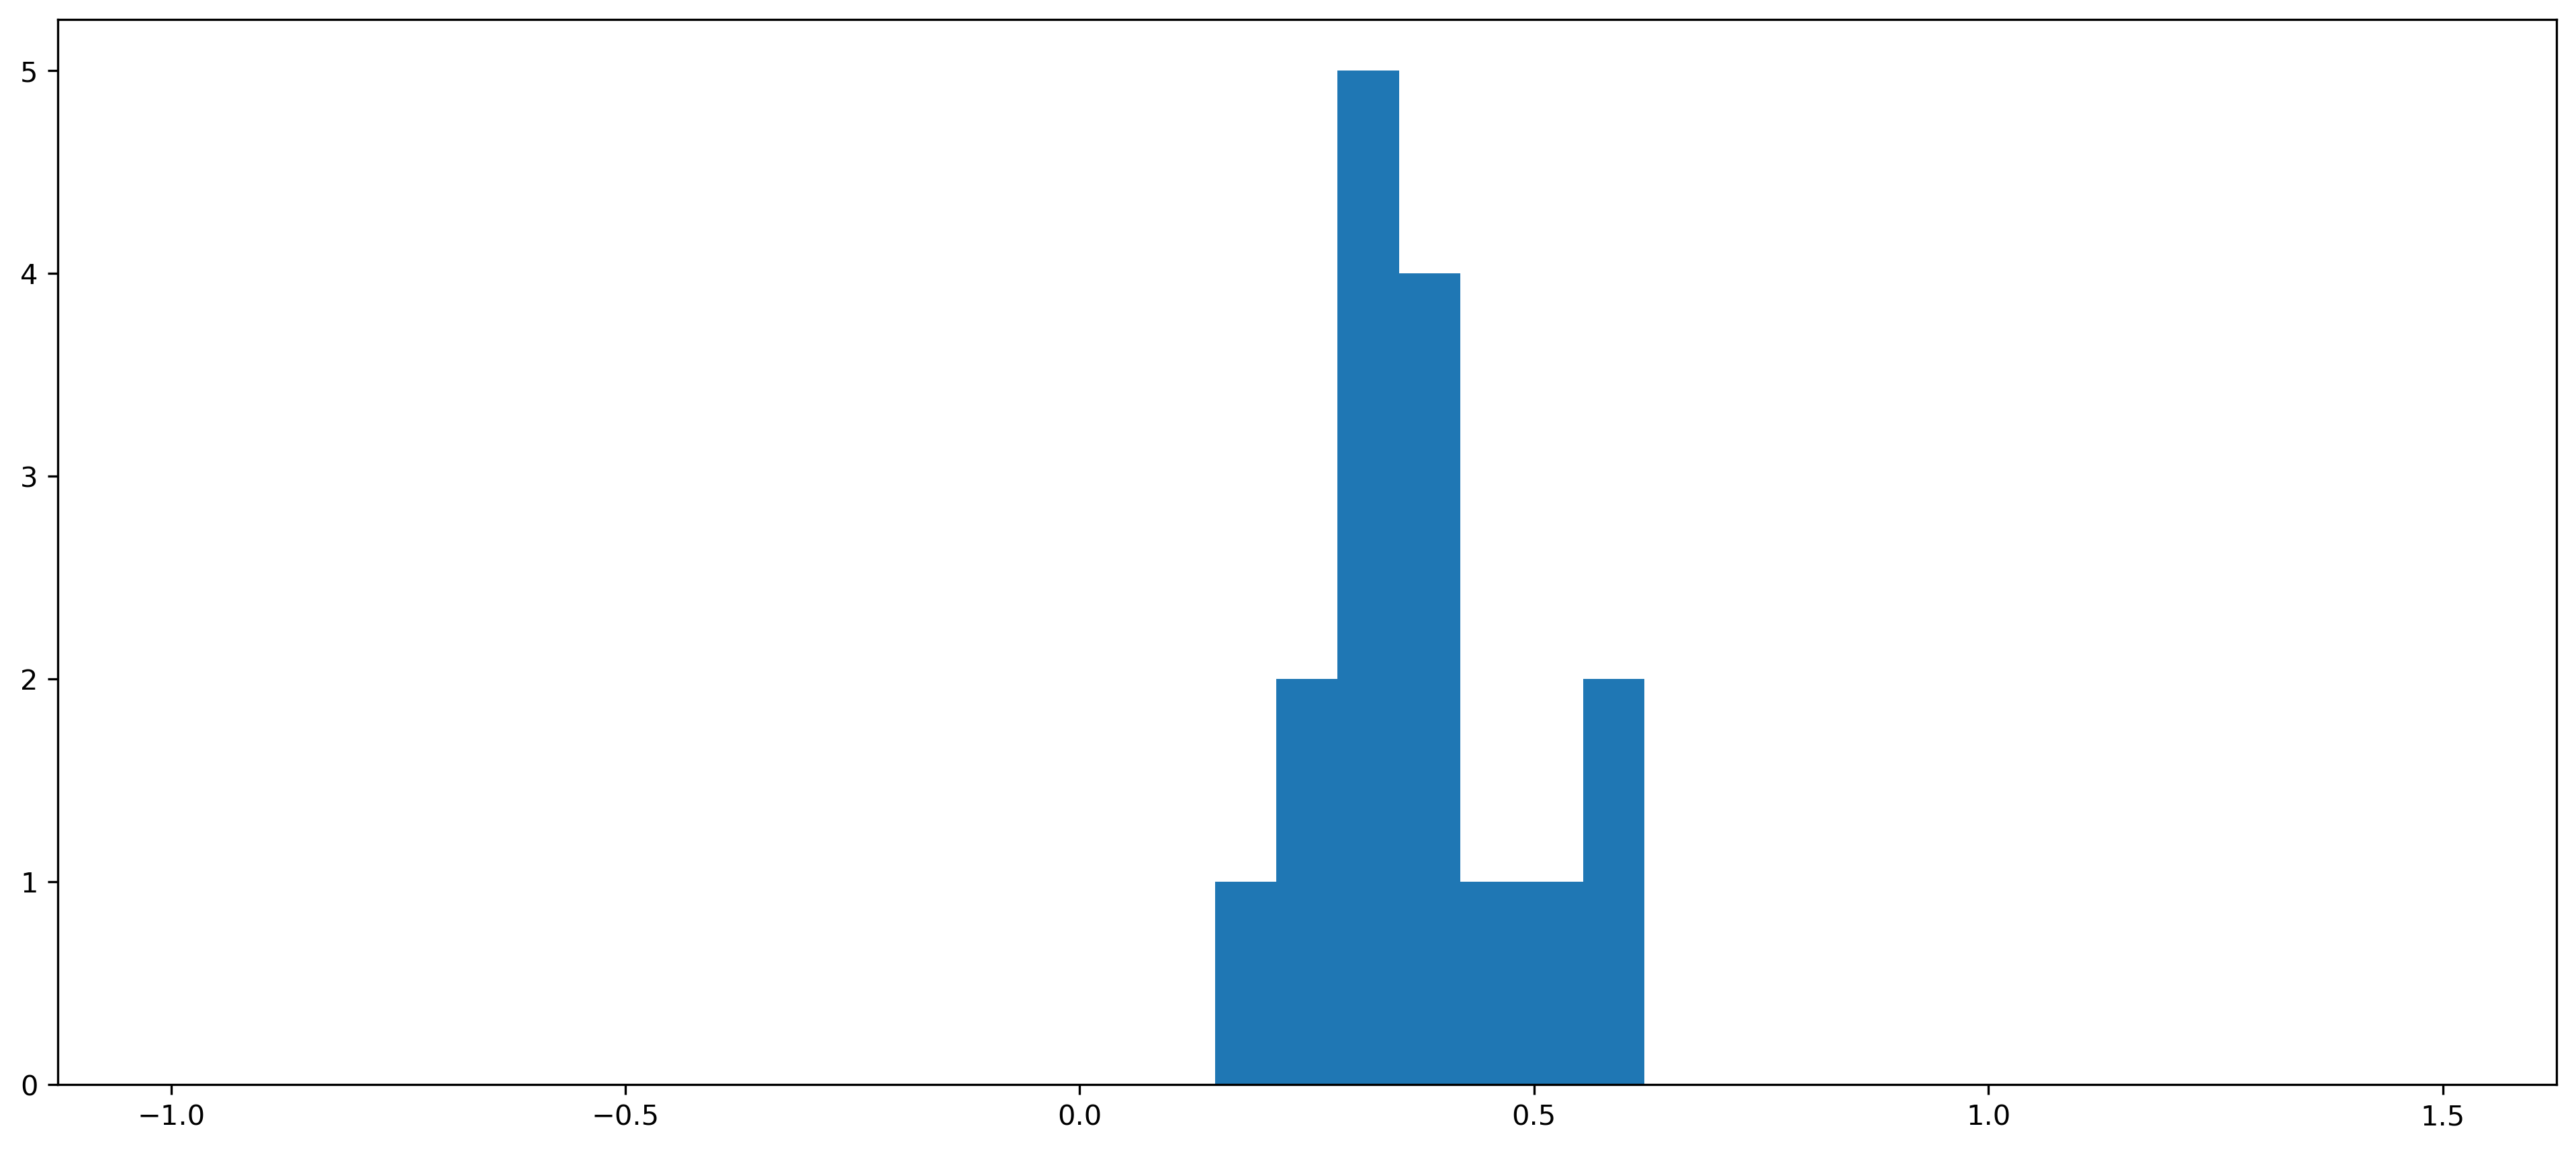

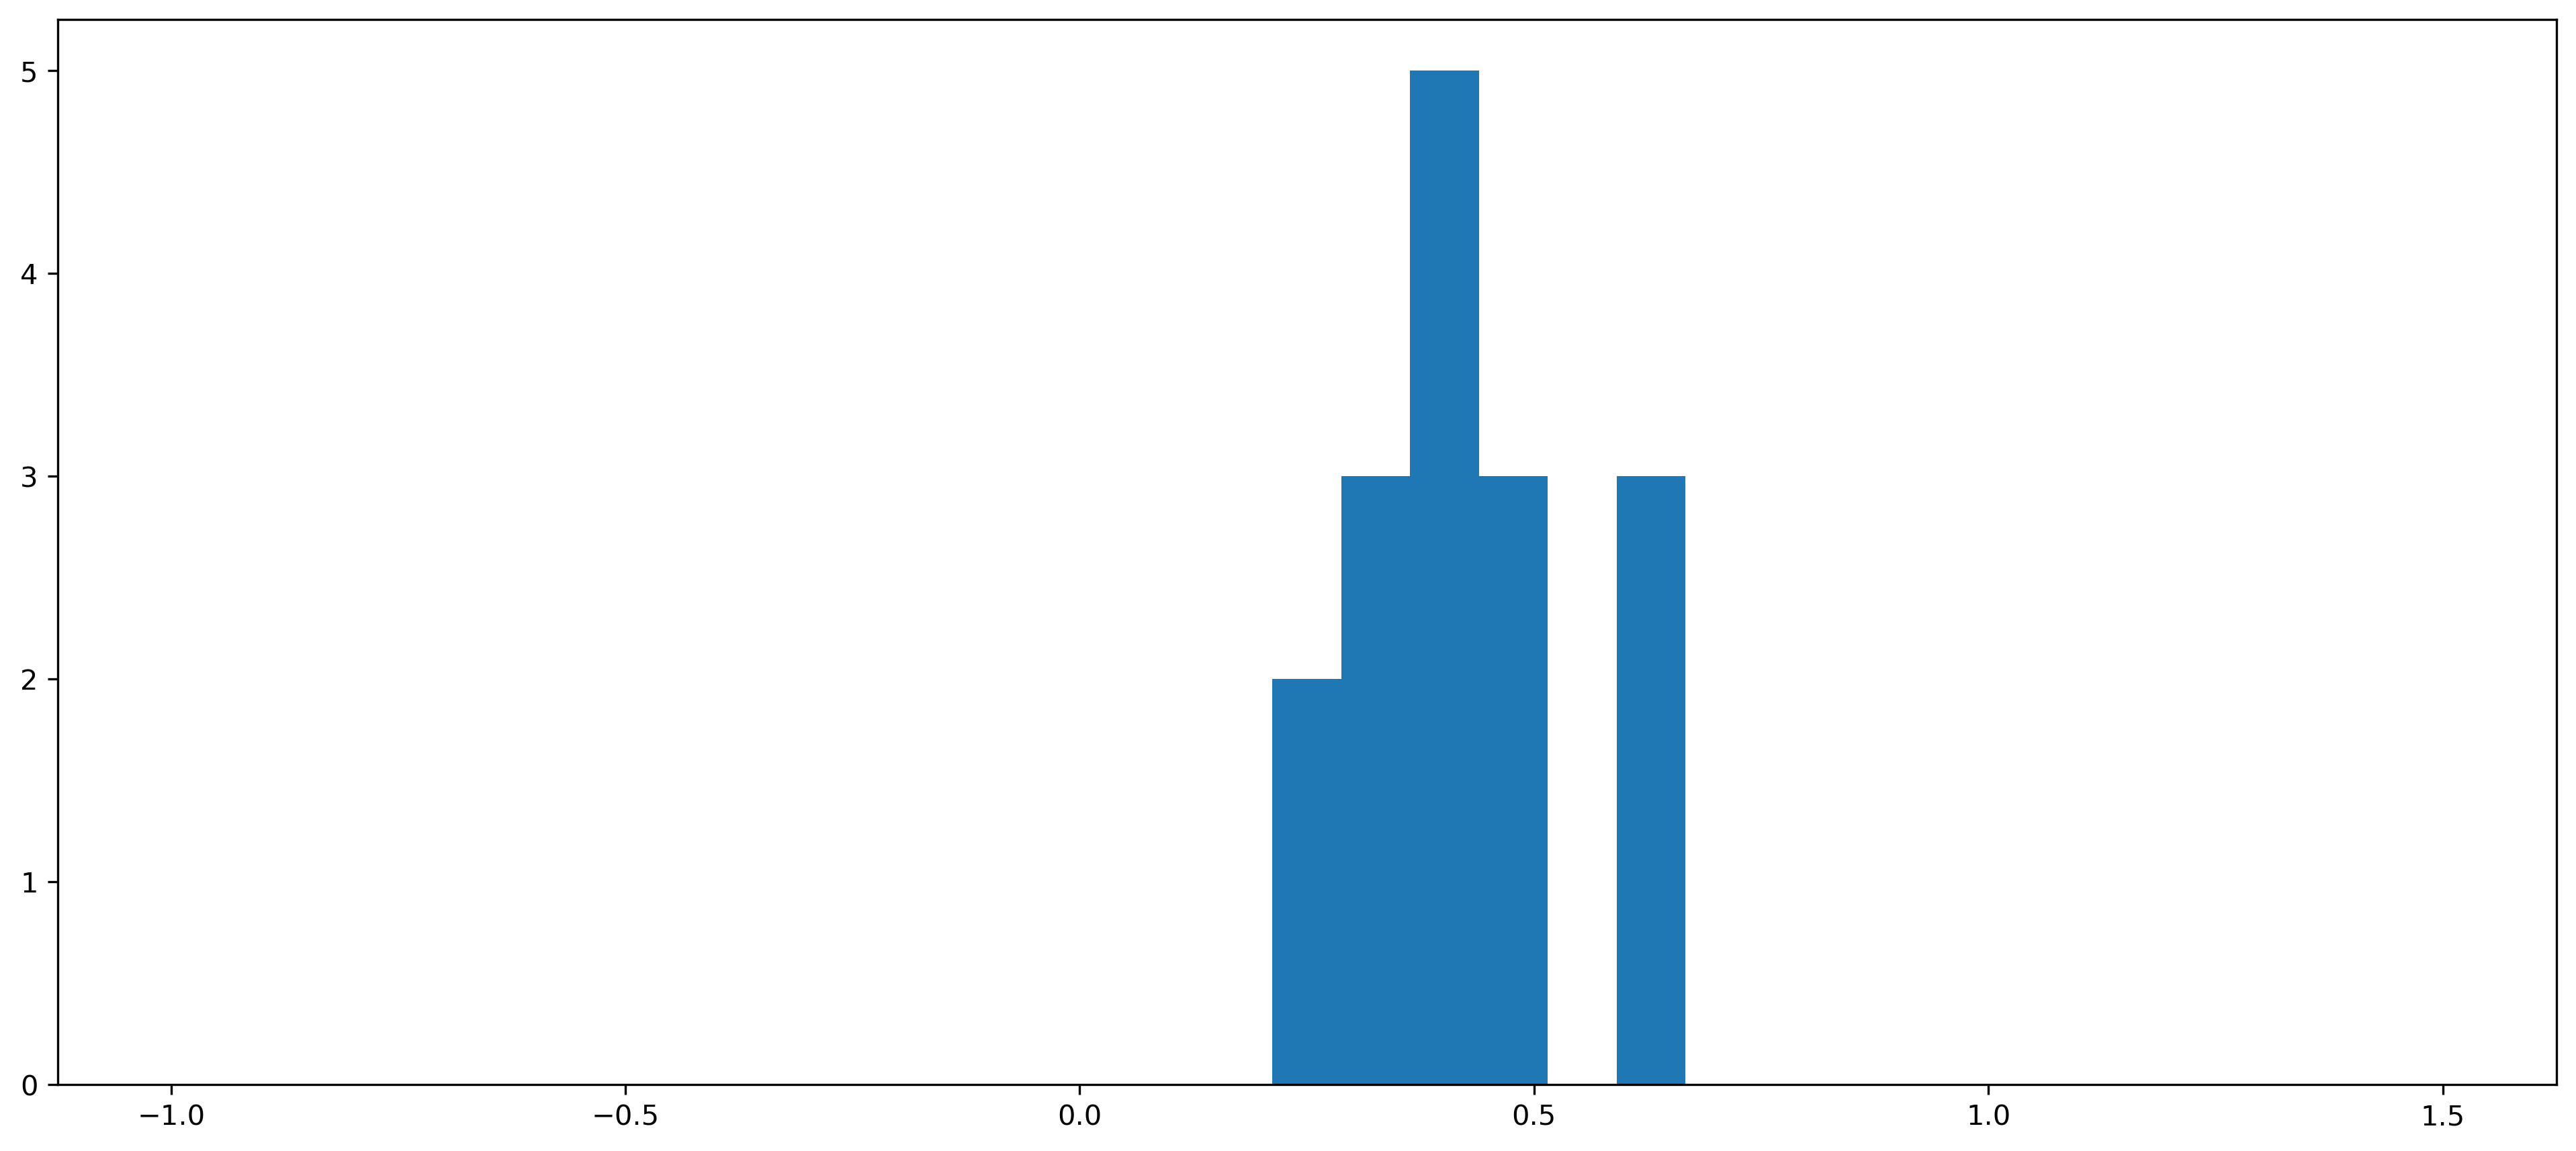

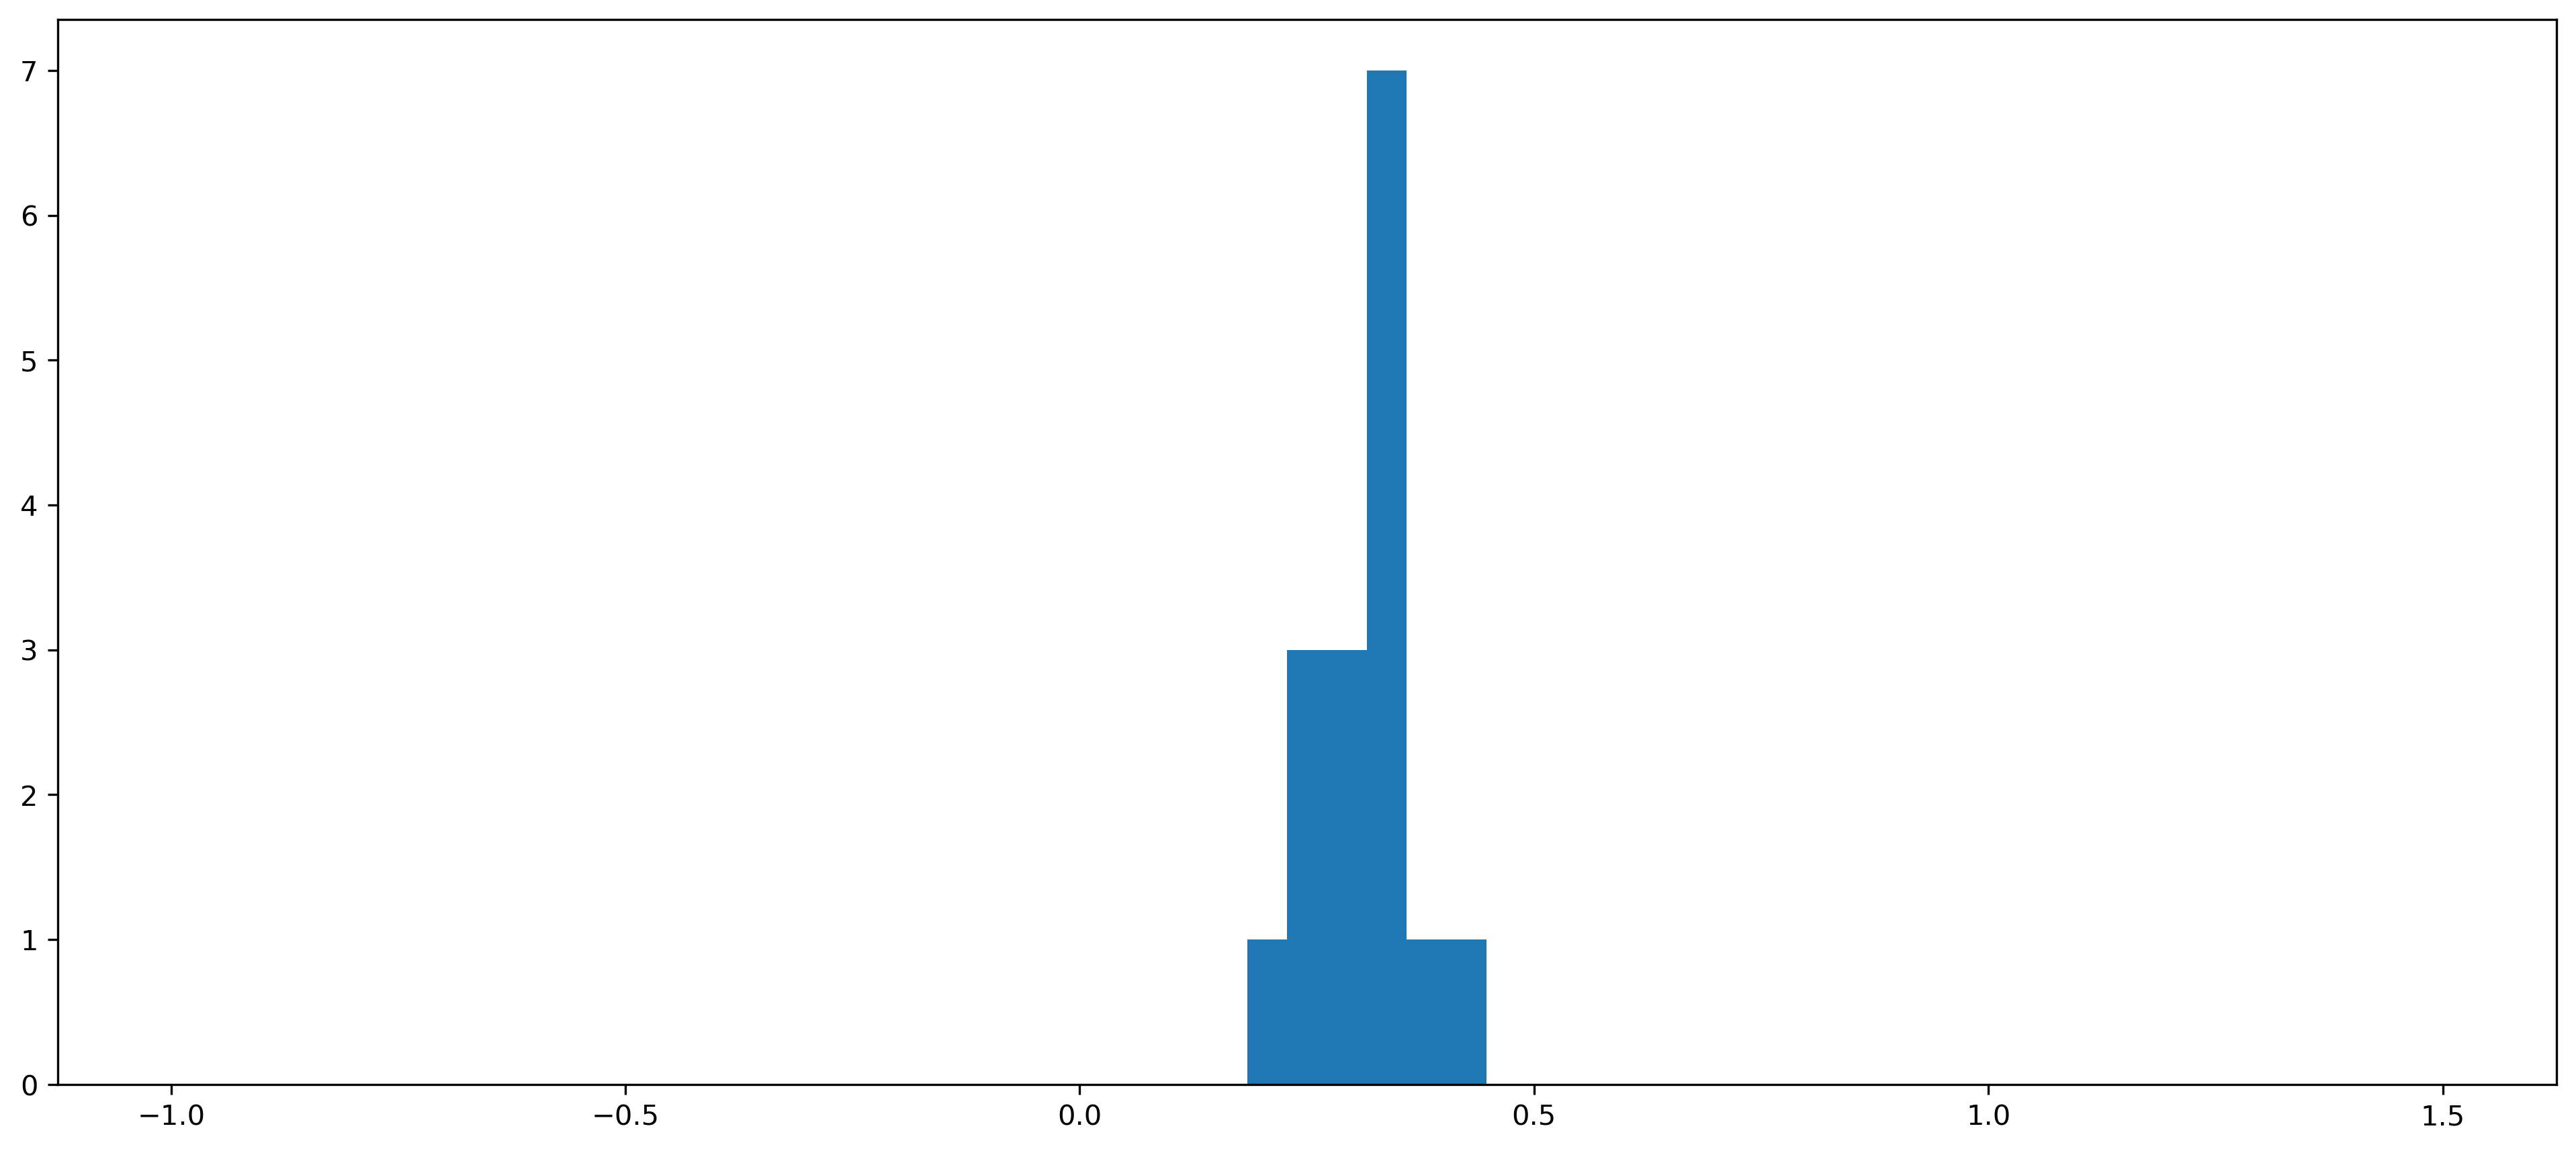

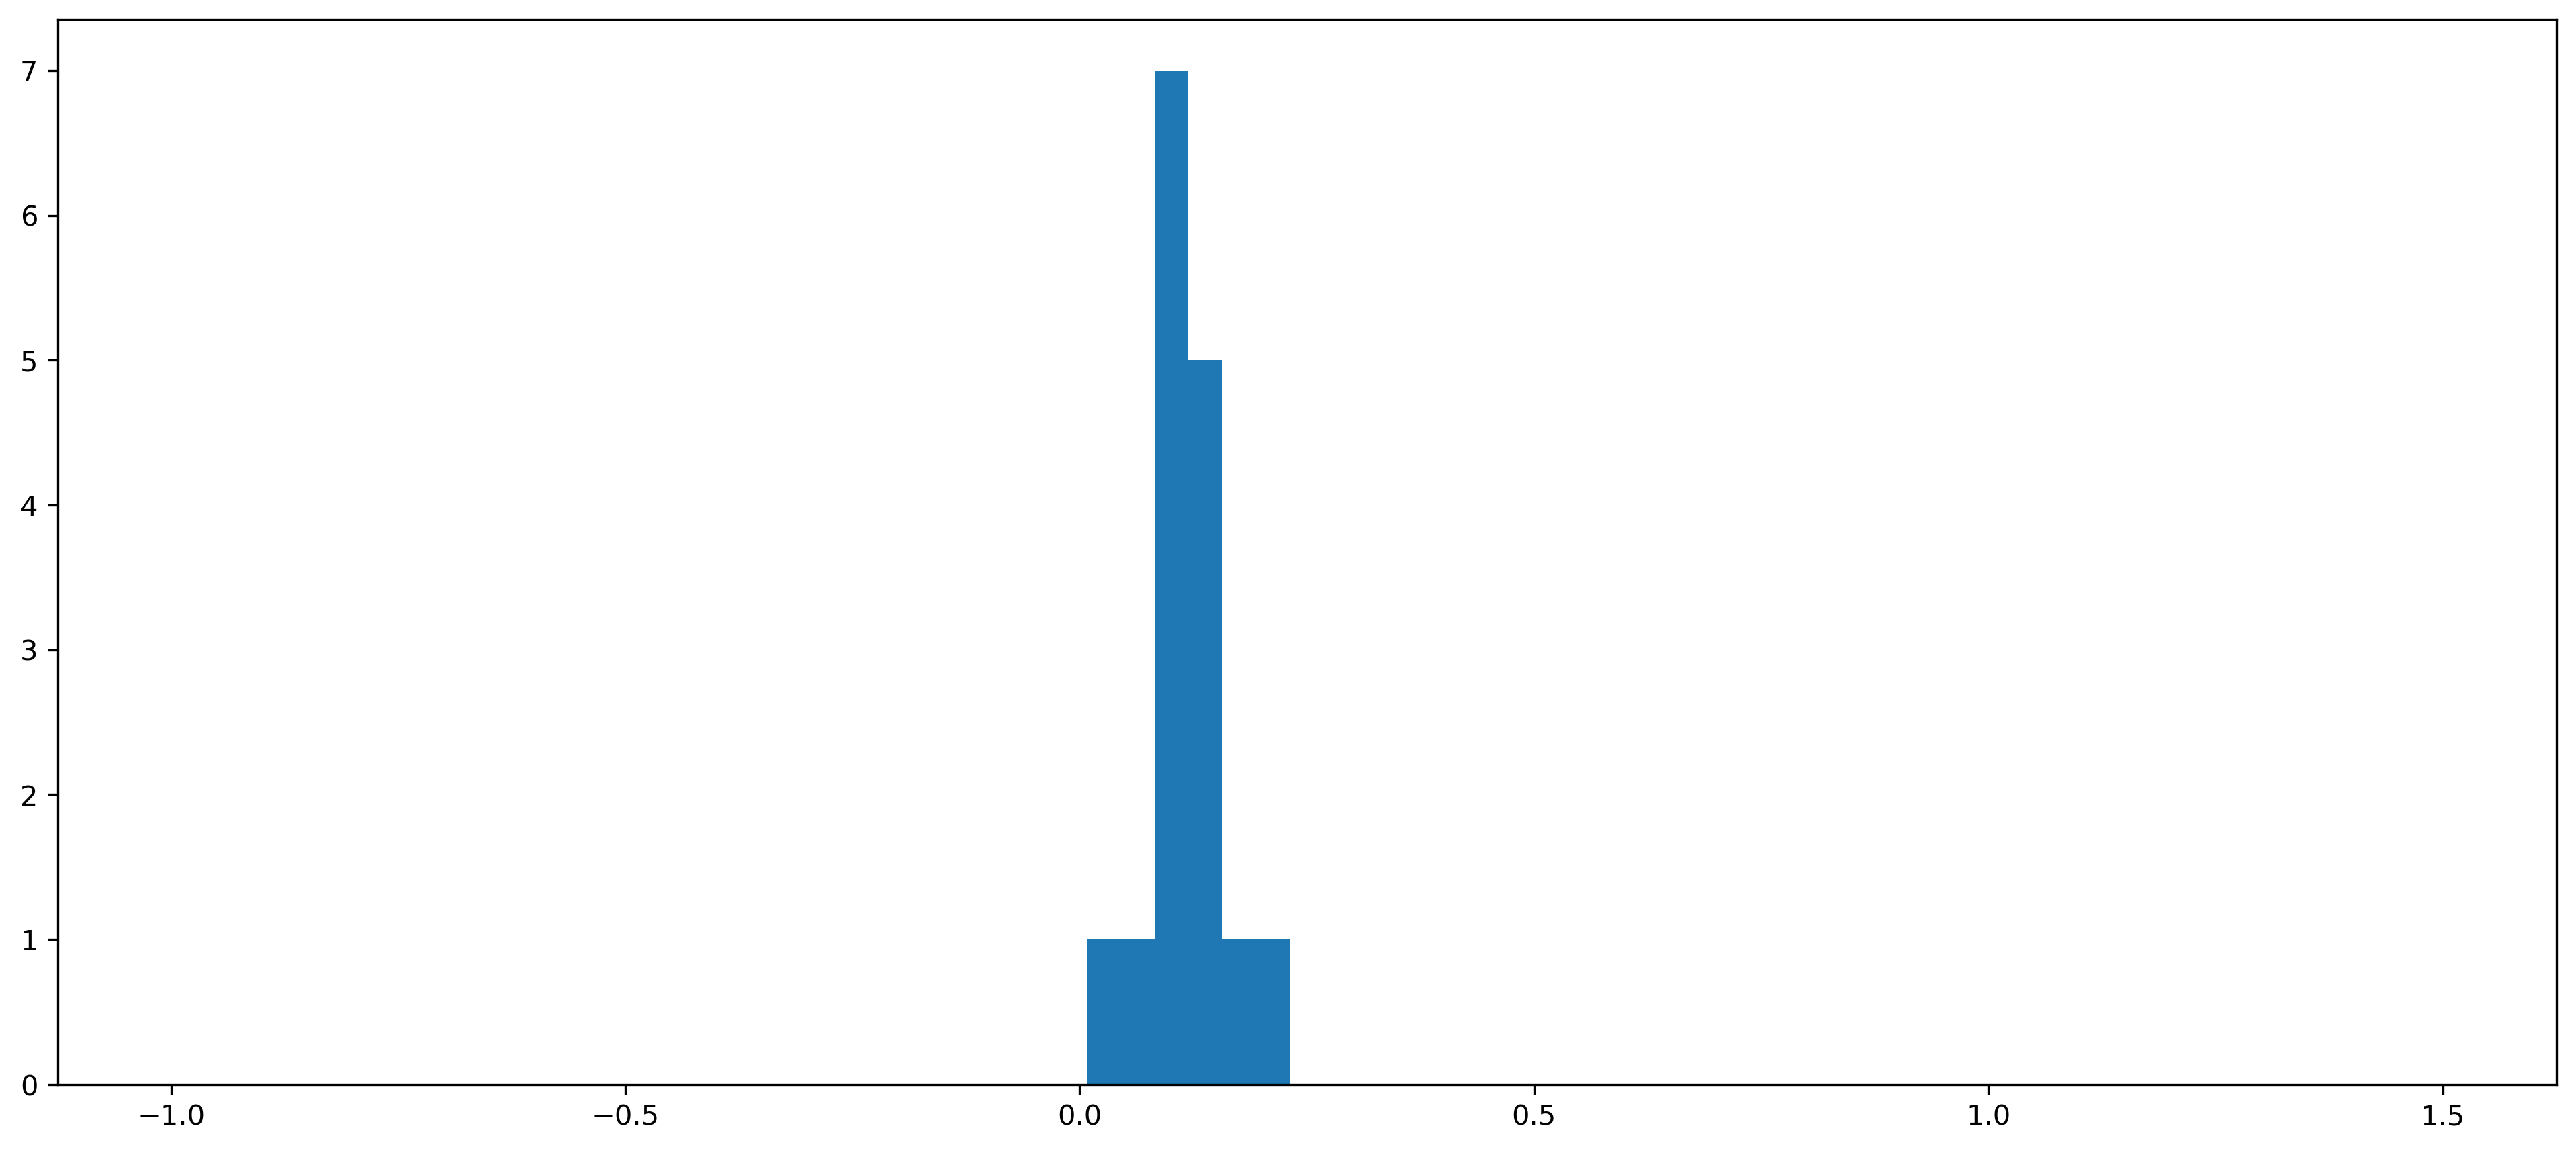

In [29]:
import numpy as np
import matplotlib.pyplot as plt

for x in fwhm_aggregate:
    _=plt.hist(fwhm_aggregate[x], bins='auto', range=(-1.0,1.5))
    plt.show()